# Master thesis - Imbalanced learning and model interpretation in credit scoring

620146 Sinan Wang

# Table of Contents

    1. Model performance analysis
    2. Resampling methods on logit performance analysis
       2.1 Aggregate by resampling methods
           2.1.1 Read results tables
           2.1.2 Plot
           2.1.3 Calculate average rank of resampling approaches
           2.1.4 Perform Friedman test
           2.1.5 Perform Nemenyi_test
       2.2 Aggregate by IR
           2.2.1 Read results tables
           2.2.2 Calculate average rank of resampling approaches
           2.2.3 Perform Friedman test
           2.2.4  Perform Nemenyi_test
       2.3 Aggregate by IR and resampling methods
           2.3.1 Read results tables
           2.3.2 Calculate average rank of resampling approaches
           2.3.3 Perform Friedman test
           2.3.4  Perform Nemenyi_test
    3. Resampling methods on XGBoost performance analysis
       3.1 Aggregate by resampling methods
           3.1.1 Read results tables
           3.1.2 Plot
           3.1.3 Calculate average rank of resampling approaches
           3.1.4 Perform Friedman test
           3.1.5 Perform Nemenyi_test
       3.2 Aggregate by IR
           3.2.1 Read results tables
           3.2.2 Calculate average rank of resampling approaches
           3.2.3 Perform Friedman test
           3.2.4  Perform Nemenyi_test
       3.3 Aggregate by IR and resampling methods
           3.3.1 Read results tables
           3.3.2 Calculate average rank of resampling approaches
           3.3.3 Perform Friedman test
           3.3.4  Perform Nemenyi_test
    4. Shap correlation analysis
    5. PFI correlation analysis
       
       
 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import friedmanchisquare, wilcoxon
from scipy.stats import rankdata
from scipy import stats
import scikit_posthocs as sp
import statsmodels.stats.multitest as smt
import statistics


%load_ext autoreload
%autoreload 2

# 1. Model performance analysis

In [2]:
#read model evaluation results
hmeq_eva = pd.read_csv("../HMEQ/result/hmeq_models.csv", sep=",", index_col=0)
hmeq_eva.rename(columns = {'AUC_validation':'hmeq_AUC','G-means':'hmeq_G-means',
                         'F1-score':'hmeq_F1-score' }, inplace = True)

ucig_eva = pd.read_csv("../UCI_G/result/ucig_models.csv", sep=",", index_col=0)
ucig_eva.rename(columns = {'AUC_validation':'ucig_AUC','G-means':'ucig_G-means',
                         'F1-score':'ucig_F1-score' }, inplace = True)

ucid_eva = pd.read_csv("../UCI_D/result/ucid_models.csv", sep=",", index_col=0)
ucid_eva.rename(columns = {'AUC_validation':'ucid_AUC','G-means':'ucid_G-means',
                         'F1-score':'ucid_F1-score' }, inplace = True)

ucip_eva = pd.read_csv("../UCI_P/result/ucip_models.csv", sep=",", index_col=0)
ucip_eva.rename(columns = {'AUC_validation':'ucip_AUC','G-means':'ucip_G-means',
                         'F1-score':'ucip_F1-score' }, inplace = True)

kaggle_eva = pd.read_csv("../GMC/result/kaggle_models.csv", sep=",", index_col=0)
kaggle_eva.rename(columns = {'AUC_validation':'kaggle_AUC','G-means':'kaggle_G-means',
                         'F1-score':'kaggle_F1-score' }, inplace = True)
kaggle_eva

,Model,kaggle_AUC,kaggle_G-means,kaggle_F1-score
0,logit,0.698,0.153,0.044
1,RF,0.838,0.309,0.161
2,xgb,0.867,0.344,0.197
3,NN,0.835,0.231,0.096


In [3]:
#generate 3 tables respectively for auc, gmeans, fmeasure
#auc table
model_auc=pd.concat([hmeq_eva['Model'],hmeq_eva['hmeq_AUC'],ucid_eva['ucid_AUC']
             ,ucig_eva['ucig_AUC'],ucip_eva['ucip_AUC'],
             kaggle_eva['kaggle_AUC']],axis=1)

#gmeans table
model_Gmeans=pd.concat([hmeq_eva['Model'],hmeq_eva['hmeq_G-means'],ucid_eva['ucid_G-means'],
                         ucig_eva['ucig_G-means'],ucip_eva['ucip_G-means'], kaggle_eva['kaggle_G-means']],axis=1)

#fmeasure table
model_F1score=pd.concat([hmeq_eva['Model'],hmeq_eva['hmeq_F1-score'],ucid_eva['ucid_F1-score'],
                         ucig_eva['ucig_F1-score'],ucip_eva['ucip_F1-score'],
             kaggle_eva['kaggle_F1-score']],axis=1)

model_F1score

,Model,hmeq_F1-score,ucid_F1-score,ucig_F1-score,ucip_F1-score,kaggle_F1-score
0,logit,0.196,0.000,0.0,0.000,0.044
1,RF,0.333,0.074,0.0,0.193,0.161
2,xgb,0.333,0.051,0.0,0.459,0.197
3,NN,0.269,0.035,0.0,0.000,0.096


In [4]:
#concate into one dataframe for later analysis
model_F1score= model_F1score.set_index('Model')
model_F1score_tr= model_F1score.transpose()

model_Gmeans= model_Gmeans.set_index('Model')
model_Gmeans_tr= model_Gmeans.transpose()

model_auc= model_auc.set_index('Model')
model_auc_tr= model_auc.transpose()

#concate
frames = [model_auc_tr,model_Gmeans_tr,model_F1score_tr]
models = pd.concat(frames)
models

Model,logit,RF,xgb,NN
hmeq_AUC,0.754,0.954,0.934,0.776
ucid_AUC,0.672,0.715,0.748,0.744
ucig_AUC,0.589,0.520,0.592,0.622
ucip_AUC,0.668,0.831,0.906,0.728
kaggle_AUC,0.698,0.838,0.867,0.835
hmeq_G-means,0.333,0.447,0.447,0.394
ucid_G-means,0.000,0.202,0.165,0.135
ucig_G-means,0.000,0.000,0.000,0.000
ucip_G-means,0.000,0.345,0.551,0.000
kaggle_G-means,0.153,0.309,0.344,0.231


In [5]:
#OUPUT table
from function_analysis import rank_cal
ranks_d = rank_cal(models)
models_table=models.copy()
models_table.loc[len(models_table)]=ranks_d
models_table.rename(index ={15: 'AR'},inplace=True)
models_table =models_table.round(3)
models_table

Index(['logit', 'RF', 'xgb', 'NN'], dtype='object', name='Model')


Model,logit,RF,xgb,NN
hmeq_AUC,0.754,0.954,0.934,0.776
ucid_AUC,0.672,0.715,0.748,0.744
ucig_AUC,0.589,0.520,0.592,0.622
ucip_AUC,0.668,0.831,0.906,0.728
kaggle_AUC,0.698,0.838,0.867,0.835
hmeq_G-means,0.333,0.447,0.447,0.394
ucid_G-means,0.000,0.202,0.165,0.135
ucig_G-means,0.000,0.000,0.000,0.000
ucip_G-means,0.000,0.345,0.551,0.000
kaggle_G-means,0.153,0.309,0.344,0.231


In [6]:
import os
path = './result'
os.makedirs(path, exist_ok=True)
models_table.to_csv(path + '/models_table.csv', index =True, encoding = 'utf-8-sig') 

In [7]:
#Friedman test
#The null-hypothesis of the Friedman test is that all resampling
#methods perform the same; also, the rejection of this
#null hypothesis implies that one or more of the resampling
#methods have a different performance.
friedmanchisquare(models['logit'],models['RF'],models['xgb'],models['NN'])
#since this p-value is less than 0.05, we can reject the null hypothesis

FriedmanchisquareResult(statistic=28.238095238095237, pvalue=3.2371927478355046e-06)

In [8]:
from function_analysis import nemenyi_test
nemenyi_test(models)

       logit     RF    xgb     NN
logit  1.000  0.002  0.001  0.255
RF     0.002  1.000  0.729  0.325
xgb    0.001  0.729  1.000  0.036
NN     0.255  0.325  0.036  1.000


,logit,RF,xgb,NN
logit,False,True,True,False
RF,True,False,False,False
xgb,True,False,False,True
NN,False,False,True,False


# 2. Resampling methods on logit performance analysis

## 2.1 aggregate by approaches

### 2.1.1 Read results tables

In [9]:
#concat auc of resampling methods accross 5 data sets
#hmeq
hmeq_logauc = pd.read_csv("../HMEQ/result/hmeq_logit_auc.csv", sep=",")
hmeq_logauc = hmeq_logauc.set_index('Approaches')
hmeq_logauc.rename(columns = {'1:15':'hmeq_1:15','1:10':'hmeq_1:10',
                         '1:5':'hmeq_1:5','1:1':'hmeq_1:1','average_rank':'hmeq_average_rank' }, inplace = True)
hmeq_logauc_tr = hmeq_logauc.transpose()
hmeq_logauc_tr
#ucig
ucig_logauc = pd.read_csv("../UCI_G/result/ucig_logit_auc.csv", sep=",")
ucig_logauc = ucig_logauc.set_index('Approaches')
ucig_logauc.rename(columns = {'1:15':'ucig_1:15','1:10':'ucig_1:10',
                         '1:5':'ucig_1:5','1:1':'ucig_1:1','average_rank':'ucig_average_rank' }, inplace = True)
ucig_logauc_tr = ucig_logauc.transpose()
#ucid
ucid_logauc = pd.read_csv("../UCI_D/result/ucid_logit_auc.csv", sep=",")
ucid_logauc = ucid_logauc.set_index('Approaches')
ucid_logauc.rename(columns = {'1:15':'ucid_1:15','1:10':'ucid_1:10',
                         '1:5':'ucid_1:5','1:1':'ucid_1:1', 'average_rank':'ucid_average_rank'}, inplace = True)
ucid_logauc_tr = ucid_logauc.transpose()
#ucip
ucip_logauc = pd.read_csv("../UCI_P/result/ucip_logit_auc.csv", sep=",")
ucip_logauc = ucip_logauc.set_index('Approaches')
ucip_logauc.rename(columns = {'1:15':'ucip_1:15','1:10':'ucip_1:10',
                         '1:5':'ucip_1:5','1:1':'ucip_1:1','average_rank':'ucip_average_rank' }, inplace = True)
ucip_logauc_tr = ucip_logauc.transpose()
#kaggle
kaggle_logauc = pd.read_csv("../GMC/result/kaggle_logit_auc.csv", sep=",")
kaggle_logauc = kaggle_logauc.set_index('Approaches')
kaggle_logauc.rename(columns = {'1:15':'kaggle_1:15','1:10':'kaggle_1:10',
                         '1:5':'kaggle_1:5','1:1':'kaggle_1:1', 'average_rank':'kaggle_average_rank' }, inplace = True)
kaggle_logauc_tr = kaggle_logauc.transpose()

#concate
frames = [hmeq_logauc_tr,ucig_logauc_tr,ucid_logauc_tr, ucip_logauc_tr,kaggle_logauc_tr]
logit_auc = pd.concat(frames)
#logit_auc = logit_auc.drop(['SVMSMOTE', 'NearMiss2'], axis=1)

print(logit_auc.shape)
logit_auc.head()

(20, 9)


Approaches,RandomOverSampler,SMOTE,BorderlineSMOTE,RandomUnderSampler,NearMiss,InstanceHardnessThreshold,SMOTEENN,SMOTETomek,logit
hmeq_1:15,0.760,0.775,0.751,0.748,0.745,0.757,0.775,0.761,0.754
hmeq_1:10,0.757,0.755,0.743,0.756,0.709,0.762,0.764,0.751,0.754
hmeq_1:5,0.769,0.747,0.744,0.753,0.695,0.758,0.756,0.747,0.754
hmeq_1:1,0.762,0.751,0.756,0.752,0.708,0.758,0.752,0.752,0.754
ucig_1:15,0.558,0.631,0.611,0.605,0.513,0.615,0.478,0.638,0.589


In [10]:
#concat gmeans of resampling methods accross 5 data sets
#hmeq
hmeq_loggmeans = pd.read_csv("../HMEQ/result/hmeq_logit_gmeans.csv", sep=",")
hmeq_loggmeans = hmeq_loggmeans.set_index('Approaches')
hmeq_loggmeans.rename(columns = {'1:15':'hmeq_1:15','1:10':'hmeq_1:10',
                         '1:5':'hmeq_1:5','1:1':'hmeq_1:1','average_rank':'hmeq_average_rank' }, inplace = True)
hmeq_loggmeans_tr = hmeq_loggmeans.transpose()

#ucig
ucig_loggmeans = pd.read_csv("../UCI_G/result/ucig_logit_gmeans.csv", sep=",")
ucig_loggmeans = ucig_loggmeans.set_index('Approaches')
ucig_loggmeans.rename(columns = {'1:15':'ucig_1:15','1:10':'ucig_1:10',
                         '1:5':'ucig_1:5','1:1':'ucig_1:1','average_rank':'ucig_average_rank' }, inplace = True)
ucig_loggmeans_tr = ucig_loggmeans.transpose()
#ucid
ucid_loggmeans = pd.read_csv("../UCI_D/result/ucid_logit_gmeans.csv", sep=",")
ucid_loggmeans = ucid_loggmeans.set_index('Approaches')
ucid_loggmeans.rename(columns = {'1:15':'ucid_1:15','1:10':'ucid_1:10',
                         '1:5':'ucid_1:5','1:1':'ucid_1:1', 'average_rank':'ucid_average_rank'}, inplace = True)
ucid_loggmeans_tr = ucid_loggmeans.transpose()
#ucip
ucip_loggmeans = pd.read_csv("../UCI_P/result/ucip_logit_gmeans.csv", sep=",")
ucip_loggmeans = ucip_loggmeans.set_index('Approaches')
ucip_loggmeans.rename(columns = {'1:15':'ucip_1:15','1:10':'ucip_1:10',
                         '1:5':'ucip_1:5','1:1':'ucip_1:1','average_rank':'ucip_average_rank' }, inplace = True)
ucip_loggmeans_tr = ucip_loggmeans.transpose()
#kaggle
kaggle_loggmeans = pd.read_csv("../GMC/result/kaggle_logit_gmeans.csv", sep=",")
kaggle_loggmeans = kaggle_loggmeans.set_index('Approaches')
kaggle_loggmeans.rename(columns = {'1:15':'kaggle_1:15','1:10':'kaggle_1:10',
                         '1:5':'kaggle_1:5','1:1':'kaggle_1:1', 'average_rank':'kaggle_average_rank' }, inplace = True)
kaggle_loggmeans_tr = kaggle_loggmeans.transpose()

#concate
frames = [hmeq_loggmeans_tr,ucig_loggmeans_tr,ucid_loggmeans_tr, ucip_loggmeans_tr,kaggle_loggmeans_tr]
logit_gmeans = pd.concat(frames)
#logit_gmeans= logit_gmeans.drop(['SVMSMOTE', 'NearMiss2'], axis=1)

print(logit_gmeans.shape)
logit_gmeans.head()

(20, 9)


Approaches,RandomOverSampler,SMOTE,BorderlineSMOTE,RandomUnderSampler,NearMiss,InstanceHardnessThreshold,SMOTEENN,SMOTETomek,logit
hmeq_1:15,0.333,0.258,0.364,0.333,0.393,0.418,0.258,0.365,0.333
hmeq_1:10,0.393,0.364,0.393,0.393,0.522,0.510,0.298,0.364,0.333
hmeq_1:5,0.465,0.443,0.490,0.488,0.627,0.543,0.489,0.443,0.333
hmeq_1:1,0.704,0.668,0.679,0.680,0.612,0.543,0.663,0.668,0.333
ucig_1:15,0.000,0.000,0.000,0.000,0.000,0.345,0.000,0.000,0.000


In [11]:
#concat fmeasure of resampling methods accross 5 data sets
#hmeq
hmeq_logfmeasure = pd.read_csv("../HMEQ/result/hmeq_logit_fmeasure.csv", sep=",")
hmeq_logfmeasure = hmeq_logfmeasure.set_index('Approaches')
hmeq_logfmeasure.rename(columns = {'1:15':'hmeq_1:15','1:10':'hmeq_1:10',
                         '1:5':'hmeq_1:5','1:1':'hmeq_1:1','average_rank':'hmeq_average_rank' }, inplace = True)
hmeq_logfmeasure_tr = hmeq_logfmeasure.transpose()
hmeq_logfmeasure_tr
#ucig
ucig_logfmeasure = pd.read_csv("../UCI_G/result/ucig_logit_fmeasure.csv", sep=",")
ucig_logfmeasure = ucig_logfmeasure.set_index('Approaches')
ucig_logfmeasure.rename(columns = {'1:15':'ucig_1:15','1:10':'ucig_1:10',
                         '1:5':'ucig_1:5','1:1':'ucig_1:1','average_rank':'ucig_average_rank' }, inplace = True)
ucig_logfmeasure_tr = ucig_logfmeasure.transpose()
#ucid
ucid_logfmeasure = pd.read_csv("../UCI_D/result/ucid_logit_fmeasure.csv", sep=",")
ucid_logfmeasure = ucid_logfmeasure.set_index('Approaches')
ucid_logfmeasure.rename(columns = {'1:15':'ucid_1:15','1:10':'ucid_1:10',
                         '1:5':'ucid_1:5','1:1':'ucid_1:1', 'average_rank':'ucid_average_rank'}, inplace = True)
ucid_logfmeasure_tr = ucid_logfmeasure.transpose()
#ucip
ucip_logfmeasure = pd.read_csv("../UCI_P/result/ucip_logit_fmeasure.csv", sep=",")
ucip_logfmeasure = ucip_logfmeasure.set_index('Approaches')
ucip_logfmeasure.rename(columns = {'1:15':'ucip_1:15','1:10':'ucip_1:10',
                         '1:5':'ucip_1:5','1:1':'ucip_1:1','average_rank':'ucip_average_rank' }, inplace = True)
ucip_logfmeasure_tr = ucip_logfmeasure.transpose()
#kaggle
kaggle_logfmeasure = pd.read_csv("../GMC/result/kaggle_logit_fmeasure.csv", sep=",")
kaggle_logfmeasure = kaggle_logfmeasure.set_index('Approaches')
kaggle_logfmeasure.rename(columns = {'1:15':'kaggle_1:15','1:10':'kaggle_1:10',
                         '1:5':'kaggle_1:5','1:1':'kaggle_1:1', 'average_rank':'kaggle_average_rank' }, inplace = True)
kaggle_logfmeasure_tr = kaggle_logfmeasure.transpose()

#concate
frames = [hmeq_logfmeasure_tr,ucig_logfmeasure_tr,ucid_logfmeasure_tr, ucip_logfmeasure_tr,kaggle_logfmeasure_tr]
logit_fmeasure = pd.concat(frames)
#logit_fmeasure = logit_fmeasure.drop(['SVMSMOTE','NearMiss2'], axis =1)

print(logit_fmeasure.shape)
logit_fmeasure.head()

(20, 9)


Approaches,RandomOverSampler,SMOTE,BorderlineSMOTE,RandomUnderSampler,NearMiss,InstanceHardnessThreshold,SMOTEENN,SMOTETomek,logit
hmeq_1:15,0.192,0.125,0.218,0.192,0.241,0.235,0.125,0.226,0.196
hmeq_1:10,0.237,0.203,0.233,0.233,0.228,0.293,0.160,0.203,0.196
hmeq_1:5,0.253,0.250,0.297,0.278,0.173,0.255,0.293,0.250,0.196
hmeq_1:1,0.210,0.179,0.197,0.186,0.121,0.255,0.173,0.179,0.196
ucig_1:15,0.000,0.000,0.000,0.000,0.000,0.125,0.000,0.000,0.000


In [12]:
#concate 3 performance metrics
frames = [hmeq_logauc_tr,ucig_logauc_tr,ucid_logauc_tr, ucip_logauc_tr,kaggle_logauc_tr,
          hmeq_loggmeans_tr,ucig_loggmeans_tr,ucid_loggmeans_tr, ucip_loggmeans_tr,kaggle_loggmeans_tr,
          hmeq_logfmeasure_tr,ucig_logfmeasure_tr,ucid_logfmeasure_tr, ucip_logfmeasure_tr,kaggle_logfmeasure_tr]
logit_3dim = pd.concat(frames)
print(logit_3dim.shape)
logit_3dim.head()

(60, 9)


Approaches,RandomOverSampler,SMOTE,BorderlineSMOTE,RandomUnderSampler,NearMiss,InstanceHardnessThreshold,SMOTEENN,SMOTETomek,logit
hmeq_1:15,0.760,0.775,0.751,0.748,0.745,0.757,0.775,0.761,0.754
hmeq_1:10,0.757,0.755,0.743,0.756,0.709,0.762,0.764,0.751,0.754
hmeq_1:5,0.769,0.747,0.744,0.753,0.695,0.758,0.756,0.747,0.754
hmeq_1:1,0.762,0.751,0.756,0.752,0.708,0.758,0.752,0.752,0.754
ucig_1:15,0.558,0.631,0.611,0.605,0.513,0.615,0.478,0.638,0.589


### 2.1.2 Plot

  Resampling methods   IR15   IR10    IR5    IR1
0                ROS  0.670  0.693  0.709  0.742
1              SMOTE  0.690  0.701  0.708  0.731
2             BSMOTE  0.694  0.695  0.717  0.742
3                RUS  0.695  0.693  0.682  0.743
4           Nearmiss  0.666  0.626  0.604  0.565
5                IHT  0.720  0.724  0.734  0.734
6              SMENN  0.658  0.692  0.733  0.740
7              SMTMK  0.689  0.698  0.708  0.733


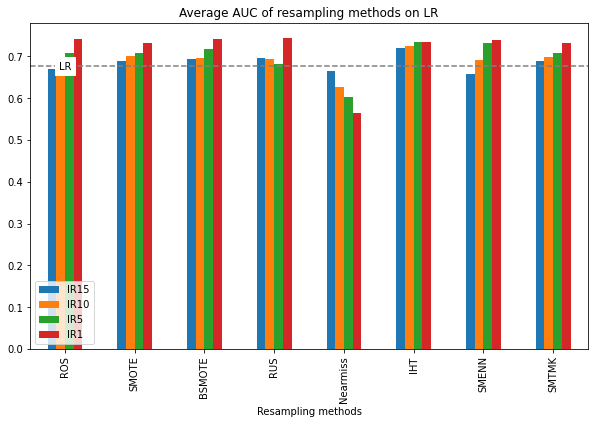

In [109]:
# calculate mean auc of five datasets in case of certain approach and certain ir
#logit 
logit_meanauc =statistics.mean([logit_auc.iloc[0,8], logit_auc.iloc[4,8], 
                        logit_auc.iloc[8,8], logit_auc.iloc[12,8], logit_auc.iloc[16,8]]).round(3)

#ros
ros15 =statistics.mean([logit_auc.iloc[0,0], logit_auc.iloc[4,0], 
                        logit_auc.iloc[8,0], logit_auc.iloc[12,0], logit_auc.iloc[16,0]]).round(3)
ros10 =statistics.mean([logit_auc.iloc[1,0], logit_auc.iloc[5,0], 
                        logit_auc.iloc[9,0], logit_auc.iloc[13,0], logit_auc.iloc[17,0]]).round(3)
ros5 =statistics.mean([logit_auc.iloc[2,0], logit_auc.iloc[6,0], 
                        logit_auc.iloc[10,0], logit_auc.iloc[14,0], logit_auc.iloc[18,0]]).round(3)
ros1 =statistics.mean([logit_auc.iloc[3,0], logit_auc.iloc[7,0], 
                        logit_auc.iloc[11,0], logit_auc.iloc[15,0], logit_auc.iloc[19,0]]).round(3)

#smote
smote15 =statistics.mean([logit_auc.iloc[0,1], logit_auc.iloc[4,1], 
                        logit_auc.iloc[8,1], logit_auc.iloc[12,1], logit_auc.iloc[16,1]]).round(3)
smote10 =statistics.mean([logit_auc.iloc[1,1], logit_auc.iloc[5,1], 
                        logit_auc.iloc[9,1], logit_auc.iloc[13,1], logit_auc.iloc[17,1]]).round(3)
smote5 =statistics.mean([logit_auc.iloc[2,1], logit_auc.iloc[6,1], 
                        logit_auc.iloc[10,1], logit_auc.iloc[14,1], logit_auc.iloc[18,1]]).round(3)
smote1 =statistics.mean([logit_auc.iloc[3,1], logit_auc.iloc[7,1], 
                        logit_auc.iloc[11,1], logit_auc.iloc[15,1], logit_auc.iloc[19,1]]).round(3)

#bsmote
bsmote15 =statistics.mean([logit_auc.iloc[0,2], logit_auc.iloc[4,2], 
                        logit_auc.iloc[8,2], logit_auc.iloc[12,2], logit_auc.iloc[16,2]]).round(3)
bsmote10 =statistics.mean([logit_auc.iloc[1,2], logit_auc.iloc[5,2], 
                        logit_auc.iloc[9,2], logit_auc.iloc[13,2], logit_auc.iloc[17,2]]).round(3)
bsmote5 =statistics.mean([logit_auc.iloc[2,2], logit_auc.iloc[6,2], 
                        logit_auc.iloc[10,2], logit_auc.iloc[14,2], logit_auc.iloc[18,2]]).round(3)
bsmote1 =statistics.mean([logit_auc.iloc[3,2], logit_auc.iloc[7,2], 
                        logit_auc.iloc[11,2], logit_auc.iloc[15,2], logit_auc.iloc[19,2]]).round(3)

#rus
rus15 =statistics.mean([logit_auc.iloc[0,3], logit_auc.iloc[4,3], 
                        logit_auc.iloc[8,3], logit_auc.iloc[12,3], logit_auc.iloc[16,3]]).round(3)
rus10 =statistics.mean([logit_auc.iloc[1,3], logit_auc.iloc[5,3], 
                        logit_auc.iloc[9,3], logit_auc.iloc[13,3], logit_auc.iloc[17,3]]).round(3)
rus5 =statistics.mean([logit_auc.iloc[2,3], logit_auc.iloc[6,3], 
                        logit_auc.iloc[10,3], logit_auc.iloc[14,3], logit_auc.iloc[18,3]]).round(3)
rus1 =statistics.mean([logit_auc.iloc[3,3], logit_auc.iloc[7,3], 
                        logit_auc.iloc[11,3], logit_auc.iloc[15,3], logit_auc.iloc[19,3]]).round(3)

#nn
nn15 =statistics.mean([logit_auc.iloc[0,4], logit_auc.iloc[4,4], 
                        logit_auc.iloc[8,4], logit_auc.iloc[12,4], logit_auc.iloc[16,4]]).round(3)
nn10 =statistics.mean([logit_auc.iloc[1,4], logit_auc.iloc[5,4], 
                        logit_auc.iloc[9,4], logit_auc.iloc[13,4], logit_auc.iloc[17,4]]).round(3)
nn5 =statistics.mean([logit_auc.iloc[2,4], logit_auc.iloc[6,4], 
                        logit_auc.iloc[10,4], logit_auc.iloc[14,4], logit_auc.iloc[18,4]]).round(3)
nn1 =statistics.mean([logit_auc.iloc[3,4], logit_auc.iloc[7,4], 
                        logit_auc.iloc[11,4], logit_auc.iloc[15,4], logit_auc.iloc[19,4]]).round(3)

#iht
iht15 =statistics.mean([logit_auc.iloc[0,5], logit_auc.iloc[4,5], 
                        logit_auc.iloc[8,5], logit_auc.iloc[12,5], logit_auc.iloc[16,5]]).round(3)
iht10 =statistics.mean([logit_auc.iloc[1,5], logit_auc.iloc[5,5], 
                        logit_auc.iloc[9,5], logit_auc.iloc[13,5], logit_auc.iloc[17,5]]).round(3)
iht5 =statistics.mean([logit_auc.iloc[2,5], logit_auc.iloc[6,5], 
                        logit_auc.iloc[10,5], logit_auc.iloc[14,5], logit_auc.iloc[18,5]]).round(3)
iht1 =statistics.mean([logit_auc.iloc[3,5], logit_auc.iloc[7,5], 
                        logit_auc.iloc[11,5], logit_auc.iloc[15,5], logit_auc.iloc[19,5]]).round(3)

#smenn
smenn15 =statistics.mean([logit_auc.iloc[0,6], logit_auc.iloc[4,6], 
                        logit_auc.iloc[8,6], logit_auc.iloc[12,6], logit_auc.iloc[16,6]]).round(3)
smenn10 =statistics.mean([logit_auc.iloc[1,6], logit_auc.iloc[5,6], 
                        logit_auc.iloc[9,6], logit_auc.iloc[13,6], logit_auc.iloc[17,6]]).round(3)
smenn5 =statistics.mean([logit_auc.iloc[2,6], logit_auc.iloc[6,6], 
                        logit_auc.iloc[10,6], logit_auc.iloc[14,6], logit_auc.iloc[18,6]]).round(3)
smenn1 =statistics.mean([logit_auc.iloc[3,6], logit_auc.iloc[7,6], 
                        logit_auc.iloc[11,6], logit_auc.iloc[15,6], logit_auc.iloc[19,6]]).round(3)

#smt
smt15 =statistics.mean([logit_auc.iloc[0,7], logit_auc.iloc[4,7], 
                        logit_auc.iloc[8,7], logit_auc.iloc[12,7], logit_auc.iloc[16,7]]).round(3)
smt10 =statistics.mean([logit_auc.iloc[1,7], logit_auc.iloc[5,7], 
                        logit_auc.iloc[9,7], logit_auc.iloc[13,7], logit_auc.iloc[17,7]]).round(3)
smt5 =statistics.mean([logit_auc.iloc[2,7], logit_auc.iloc[6,7], 
                        logit_auc.iloc[10,7], logit_auc.iloc[14,7], logit_auc.iloc[18,7]]).round(3)
smt1 =statistics.mean([logit_auc.iloc[3,7], logit_auc.iloc[7,7], 
                        logit_auc.iloc[11,7], logit_auc.iloc[15,7], logit_auc.iloc[19,7]]).round(3)

# create data
df = pd.DataFrame([['ROS', ros15, ros10, ros5, ros1], ['SMOTE', smote15, smote10, smote5, smote1], 
                   ['BSMOTE', bsmote15, bsmote10, bsmote5, bsmote1],['RUS', rus15, rus10, rus5, rus1], 
                   ['Nearmiss', nn15, nn10, nn5, nn1], ['IHT', iht15, iht10, iht5, iht1],
                   ['SMENN', smenn15, smenn10, smenn5, smenn1], ['SMTMK', smt15, smt10, smt5, smt1]],
                  columns=['Resampling methods', 'IR15', 'IR10', 'IR5', 'IR1'])
# view data
print(df)

# plot grouped bar chart
df.plot(x='Resampling methods',
        kind='bar',
        stacked=False,
        title='Average AUC of resampling methods on LR')

#add a dash line of avaerage logit auc

plt.axhline(y= logit_meanauc,color='grey', linestyle ='dashed')
plt.text(0, logit_meanauc, 'LR', fontsize=10, va='center', ha='center', backgroundcolor='w')

#adjust the size of plot    
plt.rcParams["figure.figsize"] = [10, 6]
plt.savefig('./result/logit_auc.jpg')
plt.show()

  Resampling methods   IR15   IR10    IR5    IR1
0                ROS  0.102  0.190  0.296  0.646
1              SMOTE  0.091  0.190  0.309  0.613
2             BSMOTE  0.137  0.214  0.406  0.604
3                RUS  0.153  0.202  0.265  0.672
4           Nearmiss  0.182  0.430  0.523  0.498
5                IHT  0.440  0.518  0.597  0.600
6              SMENN  0.132  0.185  0.379  0.617
7              SMTMK  0.112  0.193  0.313  0.614


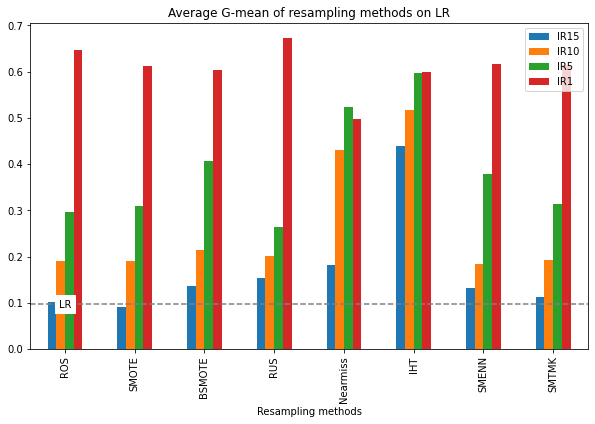

In [14]:
# calculate mean gmeans of five datasets in case of certain approach and certain ir
#logit 
logit_meangmeans =statistics.mean([logit_gmeans.iloc[0,8], logit_gmeans.iloc[4,8], 
                        logit_gmeans.iloc[8,8], logit_gmeans.iloc[12,8], logit_gmeans.iloc[16,8]]).round(3)

#ros
ros15 =statistics.mean([logit_gmeans.iloc[0,0], logit_gmeans.iloc[4,0], 
                        logit_gmeans.iloc[8,0], logit_gmeans.iloc[12,0], logit_gmeans.iloc[16,0]]).round(3)
ros10 =statistics.mean([logit_gmeans.iloc[1,0], logit_gmeans.iloc[5,0], 
                        logit_gmeans.iloc[9,0], logit_gmeans.iloc[13,0], logit_gmeans.iloc[17,0]]).round(3)
ros5 =statistics.mean([logit_gmeans.iloc[2,0], logit_gmeans.iloc[6,0], 
                        logit_gmeans.iloc[10,0], logit_gmeans.iloc[14,0], logit_gmeans.iloc[18,0]]).round(3)
ros1 =statistics.mean([logit_gmeans.iloc[3,0], logit_gmeans.iloc[7,0], 
                        logit_gmeans.iloc[11,0], logit_gmeans.iloc[15,0], logit_gmeans.iloc[19,0]]).round(3)

#smote
smote15 =statistics.mean([logit_gmeans.iloc[0,1], logit_gmeans.iloc[4,1], 
                        logit_gmeans.iloc[8,1], logit_gmeans.iloc[12,1], logit_gmeans.iloc[16,1]]).round(3)
smote10 =statistics.mean([logit_gmeans.iloc[1,1], logit_gmeans.iloc[5,1], 
                        logit_gmeans.iloc[9,1], logit_gmeans.iloc[13,1], logit_gmeans.iloc[17,1]]).round(3)
smote5 =statistics.mean([logit_gmeans.iloc[2,1], logit_gmeans.iloc[6,1], 
                        logit_gmeans.iloc[10,1], logit_gmeans.iloc[14,1], logit_gmeans.iloc[18,1]]).round(3)
smote1 =statistics.mean([logit_gmeans.iloc[3,1], logit_gmeans.iloc[7,1], 
                        logit_gmeans.iloc[11,1], logit_gmeans.iloc[15,1], logit_gmeans.iloc[19,1]]).round(3)

#bsmote
bsmote15 =statistics.mean([logit_gmeans.iloc[0,2], logit_gmeans.iloc[4,2], 
                        logit_gmeans.iloc[8,2], logit_gmeans.iloc[12,2], logit_gmeans.iloc[16,2]]).round(3)
bsmote10 =statistics.mean([logit_gmeans.iloc[1,2], logit_gmeans.iloc[5,2], 
                        logit_gmeans.iloc[9,2], logit_gmeans.iloc[13,2], logit_gmeans.iloc[17,2]]).round(3)
bsmote5 =statistics.mean([logit_gmeans.iloc[2,2], logit_gmeans.iloc[6,2], 
                        logit_gmeans.iloc[10,2], logit_gmeans.iloc[14,2], logit_gmeans.iloc[18,2]]).round(3)
bsmote1 =statistics.mean([logit_gmeans.iloc[3,2], logit_gmeans.iloc[7,2], 
                        logit_gmeans.iloc[11,2], logit_gmeans.iloc[15,2], logit_gmeans.iloc[19,2]]).round(3)

#rus
rus15 =statistics.mean([logit_gmeans.iloc[0,3], logit_gmeans.iloc[4,3], 
                        logit_gmeans.iloc[8,3], logit_gmeans.iloc[12,3], logit_gmeans.iloc[16,3]]).round(3)
rus10 =statistics.mean([logit_gmeans.iloc[1,3], logit_gmeans.iloc[5,3], 
                        logit_gmeans.iloc[9,3], logit_gmeans.iloc[13,3], logit_gmeans.iloc[17,3]]).round(3)
rus5 =statistics.mean([logit_gmeans.iloc[2,3], logit_gmeans.iloc[6,3], 
                        logit_gmeans.iloc[10,3], logit_gmeans.iloc[14,3], logit_gmeans.iloc[18,3]]).round(3)
rus1 =statistics.mean([logit_gmeans.iloc[3,3], logit_gmeans.iloc[7,3], 
                        logit_gmeans.iloc[11,3], logit_gmeans.iloc[15,3], logit_gmeans.iloc[19,3]]).round(3)

#nn
nn15 =statistics.mean([logit_gmeans.iloc[0,4], logit_gmeans.iloc[4,4], 
                        logit_gmeans.iloc[8,4], logit_gmeans.iloc[12,4], logit_gmeans.iloc[16,4]]).round(3)
nn10 =statistics.mean([logit_gmeans.iloc[1,4], logit_gmeans.iloc[5,4], 
                        logit_gmeans.iloc[9,4], logit_gmeans.iloc[13,4], logit_gmeans.iloc[17,4]]).round(3)
nn5 =statistics.mean([logit_gmeans.iloc[2,4], logit_gmeans.iloc[6,4], 
                        logit_gmeans.iloc[10,4], logit_gmeans.iloc[14,4], logit_gmeans.iloc[18,4]]).round(3)
nn1 =statistics.mean([logit_gmeans.iloc[3,4], logit_gmeans.iloc[7,4], 
                        logit_gmeans.iloc[11,4], logit_gmeans.iloc[15,4], logit_gmeans.iloc[19,4]]).round(3)

#iht
iht15 =statistics.mean([logit_gmeans.iloc[0,5], logit_gmeans.iloc[4,5], 
                        logit_gmeans.iloc[8,5], logit_gmeans.iloc[12,5], logit_gmeans.iloc[16,5]]).round(3)
iht10 =statistics.mean([logit_gmeans.iloc[1,5], logit_gmeans.iloc[5,5], 
                        logit_gmeans.iloc[9,5], logit_gmeans.iloc[13,5], logit_gmeans.iloc[17,5]]).round(3)
iht5 =statistics.mean([logit_gmeans.iloc[2,5], logit_gmeans.iloc[6,5], 
                        logit_gmeans.iloc[10,5], logit_gmeans.iloc[14,5], logit_gmeans.iloc[18,5]]).round(3)
iht1 =statistics.mean([logit_gmeans.iloc[3,5], logit_gmeans.iloc[7,5], 
                        logit_gmeans.iloc[11,5], logit_gmeans.iloc[15,5], logit_gmeans.iloc[19,5]]).round(3)

#smenn
smenn15 =statistics.mean([logit_gmeans.iloc[0,6], logit_gmeans.iloc[4,6], 
                        logit_gmeans.iloc[8,6], logit_gmeans.iloc[12,6], logit_gmeans.iloc[16,6]]).round(3)
smenn10 =statistics.mean([logit_gmeans.iloc[1,6], logit_gmeans.iloc[5,6], 
                        logit_gmeans.iloc[9,6], logit_gmeans.iloc[13,6], logit_gmeans.iloc[17,6]]).round(3)
smenn5 =statistics.mean([logit_gmeans.iloc[2,6], logit_gmeans.iloc[6,6], 
                        logit_gmeans.iloc[10,6], logit_gmeans.iloc[14,6], logit_gmeans.iloc[18,6]]).round(3)
smenn1 =statistics.mean([logit_gmeans.iloc[3,6], logit_gmeans.iloc[7,6], 
                        logit_gmeans.iloc[11,6], logit_gmeans.iloc[15,6], logit_gmeans.iloc[19,6]]).round(3)

#smt
smt15 =statistics.mean([logit_gmeans.iloc[0,7], logit_gmeans.iloc[4,7], 
                        logit_gmeans.iloc[8,7], logit_gmeans.iloc[12,7], logit_gmeans.iloc[16,7]]).round(3)
smt10 =statistics.mean([logit_gmeans.iloc[1,7], logit_gmeans.iloc[5,7], 
                        logit_gmeans.iloc[9,7], logit_gmeans.iloc[13,7], logit_gmeans.iloc[17,7]]).round(3)
smt5 =statistics.mean([logit_gmeans.iloc[2,7], logit_gmeans.iloc[6,7], 
                        logit_gmeans.iloc[10,7], logit_gmeans.iloc[14,7], logit_gmeans.iloc[18,7]]).round(3)
smt1 =statistics.mean([logit_gmeans.iloc[3,7], logit_gmeans.iloc[7,7], 
                        logit_gmeans.iloc[11,7], logit_gmeans.iloc[15,7], logit_gmeans.iloc[19,7]]).round(3)

# create data
df = pd.DataFrame([['ROS', ros15, ros10, ros5, ros1], ['SMOTE', smote15, smote10, smote5, smote1], 
                   ['BSMOTE', bsmote15, bsmote10, bsmote5, bsmote1],['RUS', rus15, rus10, rus5, rus1], 
                   ['Nearmiss', nn15, nn10, nn5, nn1], ['IHT', iht15, iht10, iht5, iht1],
                   ['SMENN', smenn15, smenn10, smenn5, smenn1], ['SMTMK', smt15, smt10, smt5, smt1]],
                  columns=['Resampling methods', 'IR15', 'IR10', 'IR5', 'IR1'])
# view data
print(df)

# plot grouped bar chart
df.plot(x='Resampling methods',
        kind='bar',
        stacked=False,
        title='Average G-mean of resampling methods on LR')

#add a dash line of avaerage logit gmeans

plt.axhline(y= logit_meangmeans,color='grey', linestyle ='dashed')
plt.text(0, logit_meangmeans, 'LR', fontsize=10, va='center', ha='center', backgroundcolor='w')

#adjust the size of plot    
plt.rcParams["figure.figsize"] = [10, 6]
plt.savefig('./result/logit_gmean.jpg')
plt.show()

  Resampling methods   IR15   IR10    IR5    IR1
0                ROS  0.050  0.098  0.148  0.184
1              SMOTE  0.039  0.096  0.160  0.164
2             BSMOTE  0.065  0.114  0.202  0.172
3                RUS  0.073  0.105  0.143  0.183
4           Nearmiss  0.083  0.132  0.118  0.109
5                IHT  0.207  0.219  0.213  0.208
6              SMENN  0.055  0.093  0.204  0.161
7              SMTMK  0.059  0.097  0.163  0.165


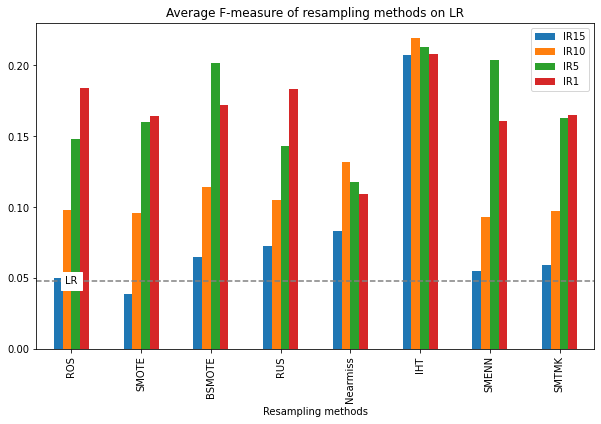

In [15]:
# calculate mean fmeasure of five datasets in case of certain approach and certain ir
#logit 
logit_meanfmeasure =statistics.mean([logit_fmeasure.iloc[0,8], logit_fmeasure.iloc[4,8], 
                        logit_fmeasure.iloc[8,8], logit_fmeasure.iloc[12,8], logit_fmeasure.iloc[16,8]]).round(3)

#ros
ros15 =statistics.mean([logit_fmeasure.iloc[0,0], logit_fmeasure.iloc[4,0], 
                        logit_fmeasure.iloc[8,0], logit_fmeasure.iloc[12,0], logit_fmeasure.iloc[16,0]]).round(3)
ros10 =statistics.mean([logit_fmeasure.iloc[1,0], logit_fmeasure.iloc[5,0], 
                        logit_fmeasure.iloc[9,0], logit_fmeasure.iloc[13,0], logit_fmeasure.iloc[17,0]]).round(3)
ros5 =statistics.mean([logit_fmeasure.iloc[2,0], logit_fmeasure.iloc[6,0], 
                        logit_fmeasure.iloc[10,0], logit_fmeasure.iloc[14,0], logit_fmeasure.iloc[18,0]]).round(3)
ros1 =statistics.mean([logit_fmeasure.iloc[3,0], logit_fmeasure.iloc[7,0], 
                        logit_fmeasure.iloc[11,0], logit_fmeasure.iloc[15,0], logit_fmeasure.iloc[19,0]]).round(3)

#smote
smote15 =statistics.mean([logit_fmeasure.iloc[0,1], logit_fmeasure.iloc[4,1], 
                        logit_fmeasure.iloc[8,1], logit_fmeasure.iloc[12,1], logit_fmeasure.iloc[16,1]]).round(3)
smote10 =statistics.mean([logit_fmeasure.iloc[1,1], logit_fmeasure.iloc[5,1], 
                        logit_fmeasure.iloc[9,1], logit_fmeasure.iloc[13,1], logit_fmeasure.iloc[17,1]]).round(3)
smote5 =statistics.mean([logit_fmeasure.iloc[2,1], logit_fmeasure.iloc[6,1], 
                        logit_fmeasure.iloc[10,1], logit_fmeasure.iloc[14,1], logit_fmeasure.iloc[18,1]]).round(3)
smote1 =statistics.mean([logit_fmeasure.iloc[3,1], logit_fmeasure.iloc[7,1], 
                        logit_fmeasure.iloc[11,1], logit_fmeasure.iloc[15,1], logit_fmeasure.iloc[19,1]]).round(3)

#bsmote
bsmote15 =statistics.mean([logit_fmeasure.iloc[0,2], logit_fmeasure.iloc[4,2], 
                        logit_fmeasure.iloc[8,2], logit_fmeasure.iloc[12,2], logit_fmeasure.iloc[16,2]]).round(3)
bsmote10 =statistics.mean([logit_fmeasure.iloc[1,2], logit_fmeasure.iloc[5,2], 
                        logit_fmeasure.iloc[9,2], logit_fmeasure.iloc[13,2], logit_fmeasure.iloc[17,2]]).round(3)
bsmote5 =statistics.mean([logit_fmeasure.iloc[2,2], logit_fmeasure.iloc[6,2], 
                        logit_fmeasure.iloc[10,2], logit_fmeasure.iloc[14,2], logit_fmeasure.iloc[18,2]]).round(3)
bsmote1 =statistics.mean([logit_fmeasure.iloc[3,2], logit_fmeasure.iloc[7,2], 
                        logit_fmeasure.iloc[11,2], logit_fmeasure.iloc[15,2], logit_fmeasure.iloc[19,2]]).round(3)

#rus
rus15 =statistics.mean([logit_fmeasure.iloc[0,3], logit_fmeasure.iloc[4,3], 
                        logit_fmeasure.iloc[8,3], logit_fmeasure.iloc[12,3], logit_fmeasure.iloc[16,3]]).round(3)
rus10 =statistics.mean([logit_fmeasure.iloc[1,3], logit_fmeasure.iloc[5,3], 
                        logit_fmeasure.iloc[9,3], logit_fmeasure.iloc[13,3], logit_fmeasure.iloc[17,3]]).round(3)
rus5 =statistics.mean([logit_fmeasure.iloc[2,3], logit_fmeasure.iloc[6,3], 
                        logit_fmeasure.iloc[10,3], logit_fmeasure.iloc[14,3], logit_fmeasure.iloc[18,3]]).round(3)
rus1 =statistics.mean([logit_fmeasure.iloc[3,3], logit_fmeasure.iloc[7,3], 
                        logit_fmeasure.iloc[11,3], logit_fmeasure.iloc[15,3], logit_fmeasure.iloc[19,3]]).round(3)

#nn
nn15 =statistics.mean([logit_fmeasure.iloc[0,4], logit_fmeasure.iloc[4,4], 
                        logit_fmeasure.iloc[8,4], logit_fmeasure.iloc[12,4], logit_fmeasure.iloc[16,4]]).round(3)
nn10 =statistics.mean([logit_fmeasure.iloc[1,4], logit_fmeasure.iloc[5,4], 
                        logit_fmeasure.iloc[9,4], logit_fmeasure.iloc[13,4], logit_fmeasure.iloc[17,4]]).round(3)
nn5 =statistics.mean([logit_fmeasure.iloc[2,4], logit_fmeasure.iloc[6,4], 
                        logit_fmeasure.iloc[10,4], logit_fmeasure.iloc[14,4], logit_fmeasure.iloc[18,4]]).round(3)
nn1 =statistics.mean([logit_fmeasure.iloc[3,4], logit_fmeasure.iloc[7,4], 
                        logit_fmeasure.iloc[11,4], logit_fmeasure.iloc[15,4], logit_fmeasure.iloc[19,4]]).round(3)

#iht
iht15 =statistics.mean([logit_fmeasure.iloc[0,5], logit_fmeasure.iloc[4,5], 
                        logit_fmeasure.iloc[8,5], logit_fmeasure.iloc[12,5], logit_fmeasure.iloc[16,5]]).round(3)
iht10 =statistics.mean([logit_fmeasure.iloc[1,5], logit_fmeasure.iloc[5,5], 
                        logit_fmeasure.iloc[9,5], logit_fmeasure.iloc[13,5], logit_fmeasure.iloc[17,5]]).round(3)
iht5 =statistics.mean([logit_fmeasure.iloc[2,5], logit_fmeasure.iloc[6,5], 
                        logit_fmeasure.iloc[10,5], logit_fmeasure.iloc[14,5], logit_fmeasure.iloc[18,5]]).round(3)
iht1 =statistics.mean([logit_fmeasure.iloc[3,5], logit_fmeasure.iloc[7,5], 
                        logit_fmeasure.iloc[11,5], logit_fmeasure.iloc[15,5], logit_fmeasure.iloc[19,5]]).round(3)

#smenn
smenn15 =statistics.mean([logit_fmeasure.iloc[0,6], logit_fmeasure.iloc[4,6], 
                        logit_fmeasure.iloc[8,6], logit_fmeasure.iloc[12,6], logit_fmeasure.iloc[16,6]]).round(3)
smenn10 =statistics.mean([logit_fmeasure.iloc[1,6], logit_fmeasure.iloc[5,6], 
                        logit_fmeasure.iloc[9,6], logit_fmeasure.iloc[13,6], logit_fmeasure.iloc[17,6]]).round(3)
smenn5 =statistics.mean([logit_fmeasure.iloc[2,6], logit_fmeasure.iloc[6,6], 
                        logit_fmeasure.iloc[10,6], logit_fmeasure.iloc[14,6], logit_fmeasure.iloc[18,6]]).round(3)
smenn1 =statistics.mean([logit_fmeasure.iloc[3,6], logit_fmeasure.iloc[7,6], 
                        logit_fmeasure.iloc[11,6], logit_fmeasure.iloc[15,6], logit_fmeasure.iloc[19,6]]).round(3)

#smt
smt15 =statistics.mean([logit_fmeasure.iloc[0,7], logit_fmeasure.iloc[4,7], 
                        logit_fmeasure.iloc[8,7], logit_fmeasure.iloc[12,7], logit_fmeasure.iloc[16,7]]).round(3)
smt10 =statistics.mean([logit_fmeasure.iloc[1,7], logit_fmeasure.iloc[5,7], 
                        logit_fmeasure.iloc[9,7], logit_fmeasure.iloc[13,7], logit_fmeasure.iloc[17,7]]).round(3)
smt5 =statistics.mean([logit_fmeasure.iloc[2,7], logit_fmeasure.iloc[6,7], 
                        logit_fmeasure.iloc[10,7], logit_fmeasure.iloc[14,7], logit_fmeasure.iloc[18,7]]).round(3)
smt1 =statistics.mean([logit_fmeasure.iloc[3,7], logit_fmeasure.iloc[7,7], 
                        logit_fmeasure.iloc[11,7], logit_fmeasure.iloc[15,7], logit_fmeasure.iloc[19,7]]).round(3)

# create data
df = pd.DataFrame([['ROS', ros15, ros10, ros5, ros1], ['SMOTE', smote15, smote10, smote5, smote1], 
                   ['BSMOTE', bsmote15, bsmote10, bsmote5, bsmote1],['RUS', rus15, rus10, rus5, rus1], 
                   ['Nearmiss', nn15, nn10, nn5, nn1], ['IHT', iht15, iht10, iht5, iht1],
                   ['SMENN', smenn15, smenn10, smenn5, smenn1], ['SMTMK', smt15, smt10, smt5, smt1]],
                  columns=['Resampling methods', 'IR15', 'IR10', 'IR5', 'IR1'])
# view data
print(df)

# plot grouped bar chart
df.plot(x='Resampling methods',
        kind='bar',
        stacked=False,
        title='Average F-measure of resampling methods on LR')

#add a dash line of avaerage logit fmeasure

plt.axhline(y= logit_meanfmeasure,color='grey', linestyle ='dashed')
plt.text(0, logit_meanfmeasure, 'LR', fontsize=10, va='center', ha='center', backgroundcolor='w')

#adjust the size of plot    
plt.rcParams["figure.figsize"] = [10, 6]
plt.savefig('./result/logit_fmeasure.jpg')
plt.show()

### 2.1.3 Calculate average rank of resampling approaches

In [16]:
rank_logitauc = rank_cal(logit_auc)
rank_logitgmeans= rank_cal(logit_gmeans)
rank_logitfmeasure= rank_cal(logit_fmeasure)
rank_logit3dim= rank_cal(logit_3dim)

Index(['RandomOverSampler', 'SMOTE', 'BorderlineSMOTE', 'RandomUnderSampler',
       'NearMiss', 'InstanceHardnessThreshold', 'SMOTEENN', 'SMOTETomek',
       'logit'],
      dtype='object', name='Approaches')
Index(['RandomOverSampler', 'SMOTE', 'BorderlineSMOTE', 'RandomUnderSampler',
       'NearMiss', 'InstanceHardnessThreshold', 'SMOTEENN', 'SMOTETomek',
       'logit'],
      dtype='object', name='Approaches')
Index(['RandomOverSampler', 'SMOTE', 'BorderlineSMOTE', 'RandomUnderSampler',
       'NearMiss', 'InstanceHardnessThreshold', 'SMOTEENN', 'SMOTETomek',
       'logit'],
      dtype='object', name='Approaches')
Index(['RandomOverSampler', 'SMOTE', 'BorderlineSMOTE', 'RandomUnderSampler',
       'NearMiss', 'InstanceHardnessThreshold', 'SMOTEENN', 'SMOTETomek',
       'logit'],
      dtype='object', name='Approaches')


In [17]:
rank_logitauc = rank_cal(logit_auc)
rank_logitgmeans= rank_cal(logit_gmeans)
rank_logitfmeasure= rank_cal(logit_fmeasure)
rank_logit3dim= rank_cal(logit_3dim)

#aggregate into df
my_array = np.array([rank_logitauc, rank_logitgmeans, rank_logitfmeasure,rank_logit3dim ])

logit_approach = pd.DataFrame(my_array, columns = ['RandomOverSampler', 'SMOTE', 'BorderlineSMOTE', 'RandomUnderSampler',
       'NearMiss', 'InstanceHardnessThreshold', 'SMOTEENN', 'SMOTETomek',
       'logit'], index = ['AUC', 'Gmeans','Fmeasure', 'Combination'])

logit_approach

Index(['RandomOverSampler', 'SMOTE', 'BorderlineSMOTE', 'RandomUnderSampler',
       'NearMiss', 'InstanceHardnessThreshold', 'SMOTEENN', 'SMOTETomek',
       'logit'],
      dtype='object', name='Approaches')
Index(['RandomOverSampler', 'SMOTE', 'BorderlineSMOTE', 'RandomUnderSampler',
       'NearMiss', 'InstanceHardnessThreshold', 'SMOTEENN', 'SMOTETomek',
       'logit'],
      dtype='object', name='Approaches')
Index(['RandomOverSampler', 'SMOTE', 'BorderlineSMOTE', 'RandomUnderSampler',
       'NearMiss', 'InstanceHardnessThreshold', 'SMOTEENN', 'SMOTETomek',
       'logit'],
      dtype='object', name='Approaches')
Index(['RandomOverSampler', 'SMOTE', 'BorderlineSMOTE', 'RandomUnderSampler',
       'NearMiss', 'InstanceHardnessThreshold', 'SMOTEENN', 'SMOTETomek',
       'logit'],
      dtype='object', name='Approaches')


,RandomOverSampler,SMOTE,BorderlineSMOTE,RandomUnderSampler,NearMiss,InstanceHardnessThreshold,SMOTEENN,SMOTETomek,logit
AUC,4.100,4.475,5.425,5.050,7.400,2.5,4.675,4.600,6.775
Gmeans,5.550,5.825,4.575,4.975,3.775,2.0,4.900,5.450,7.950
Fmeasure,5.325,5.850,3.900,5.050,5.100,1.8,5.075,5.300,7.600
Combination,4.992,5.383,4.633,5.025,5.425,2.1,4.883,5.117,7.442


In [18]:
logit_approach.to_csv(path + '/logit_approach.csv', index =True, encoding = 'utf-8-sig') 

### 2.1.4 Perform Friedman test

In [19]:
#Friedman test
#The null-hypothesis of the Friedman test is that all resampling
#methods perform the same; also, the rejection of this
#null hypothesis implies that one or more of the resampling
#methods have a different performance.
friedmanchisquare(logit_auc['RandomOverSampler'],logit_auc['SMOTE'],logit_auc['BorderlineSMOTE'],
                 logit_auc['RandomUnderSampler'],logit_auc['NearMiss'],logit_auc['InstanceHardnessThreshold'],
                 logit_auc['SMOTEENN'],logit_auc['SMOTETomek'],logit_auc['logit'])
#since this p-value is less than 0.05, we can reject the null hypothesis

FriedmanchisquareResult(statistic=45.33220195163353, pvalue=3.183108948947466e-07)

In [20]:
friedmanchisquare(logit_gmeans['RandomOverSampler'],logit_gmeans['SMOTE'],logit_gmeans['BorderlineSMOTE'],
                 logit_gmeans['RandomUnderSampler'],logit_gmeans['NearMiss'],
                logit_gmeans['InstanceHardnessThreshold'],
                 logit_gmeans['SMOTEENN'],logit_gmeans['SMOTETomek'],logit_gmeans['logit'])

FriedmanchisquareResult(statistic=63.29264776549735, pvalue=1.0489949850072518e-10)

In [21]:
friedmanchisquare(logit_fmeasure['RandomOverSampler'],logit_fmeasure['SMOTE'],logit_fmeasure['BorderlineSMOTE'],
                 logit_fmeasure['RandomUnderSampler'],logit_fmeasure['NearMiss'],logit_fmeasure['InstanceHardnessThreshold'],
                 logit_fmeasure['SMOTEENN'],logit_fmeasure['SMOTETomek'],logit_fmeasure['logit'])

FriedmanchisquareResult(statistic=58.629665071770404, pvalue=8.64949523389766e-10)

In [22]:
friedmanchisquare(logit_3dim['RandomOverSampler'],logit_3dim['SMOTE'],logit_3dim['BorderlineSMOTE'],
                 logit_3dim['RandomUnderSampler'],logit_3dim['NearMiss'],logit_3dim['InstanceHardnessThreshold'],
                 logit_3dim['SMOTEENN'],logit_3dim['SMOTETomek'],logit_3dim['logit'])

FriedmanchisquareResult(statistic=131.13235294117658, pvalue=1.6476987899824873e-24)

### 2.1.5  Perform Nemenyi_test

In [23]:
nemenyi_test(logit_auc)

                           RandomOverSampler  SMOTE  BorderlineSMOTE  \
RandomOverSampler                      1.000  0.900            0.822   
SMOTE                                  0.900  1.000            0.900   
BorderlineSMOTE                        0.822  0.900            1.000   
RandomUnderSampler                     0.900  0.900            0.900   
NearMiss                               0.004  0.021            0.355   
InstanceHardnessThreshold              0.630  0.355            0.021   
SMOTEENN                               0.900  0.900            0.900   
SMOTETomek                             0.900  0.900            0.900   
logit                                  0.052  0.164            0.805   

                           RandomUnderSampler  NearMiss  \
RandomOverSampler                       0.900     0.004   
SMOTE                                   0.900     0.021   
BorderlineSMOTE                         0.900     0.355   
RandomUnderSampler                      1.0

,RandomOverSampler,SMOTE,BorderlineSMOTE,RandomUnderSampler,NearMiss,InstanceHardnessThreshold,SMOTEENN,SMOTETomek,logit
RandomOverSampler,False,False,False,False,True,False,False,False,False
SMOTE,False,False,False,False,True,False,False,False,False
BorderlineSMOTE,False,False,False,False,False,True,False,False,False
RandomUnderSampler,False,False,False,False,False,False,False,False,False
NearMiss,True,True,False,False,False,True,True,True,False
InstanceHardnessThreshold,False,False,True,False,True,False,False,False,True
SMOTEENN,False,False,False,False,True,False,False,False,False
SMOTETomek,False,False,False,False,True,False,False,False,False
logit,False,False,False,False,False,True,False,False,False


In [24]:
nemenyi_test(logit_gmeans)

                           RandomOverSampler  SMOTE  BorderlineSMOTE  \
RandomOverSampler                      1.000  0.900            0.900   
SMOTE                                  0.900  1.000            0.875   
BorderlineSMOTE                        0.900  0.875            1.000   
RandomUnderSampler                     0.900  0.900            0.900   
NearMiss                               0.507  0.302            0.900   
InstanceHardnessThreshold              0.001  0.001            0.073   
SMOTEENN                               0.900  0.900            0.900   
SMOTETomek                             0.900  0.900            0.900   
logit                                  0.124  0.255            0.003   

                           RandomUnderSampler  NearMiss  \
RandomOverSampler                       0.900     0.507   
SMOTE                                   0.900     0.302   
BorderlineSMOTE                         0.900     0.900   
RandomUnderSampler                      1.0

,RandomOverSampler,SMOTE,BorderlineSMOTE,RandomUnderSampler,NearMiss,InstanceHardnessThreshold,SMOTEENN,SMOTETomek,logit
RandomOverSampler,False,False,False,False,False,True,False,False,False
SMOTE,False,False,False,False,False,True,False,False,False
BorderlineSMOTE,False,False,False,False,False,False,False,False,True
RandomUnderSampler,False,False,False,False,False,True,False,False,True
NearMiss,False,False,False,False,False,False,False,False,True
InstanceHardnessThreshold,True,True,False,True,False,False,True,True,True
SMOTEENN,False,False,False,False,False,True,False,False,True
SMOTETomek,False,False,False,False,False,True,False,False,False
logit,False,False,True,True,True,True,True,False,False


In [25]:
nemenyi_test(logit_fmeasure)

                           RandomOverSampler  SMOTE  BorderlineSMOTE  \
RandomOverSampler                      1.000  0.900            0.752   
SMOTE                                  0.900  1.000            0.374   
BorderlineSMOTE                        0.752  0.374            1.000   
RandomUnderSampler                     0.900  0.900            0.900   
NearMiss                               0.900  0.900            0.900   
InstanceHardnessThreshold              0.002  0.001            0.270   
SMOTEENN                               0.900  0.900            0.900   
SMOTETomek                             0.900  0.900            0.770   
logit                                  0.175  0.524            0.001   

                           RandomUnderSampler  NearMiss  \
RandomOverSampler                       0.900     0.900   
SMOTE                                   0.900     0.900   
BorderlineSMOTE                         0.900     0.900   
RandomUnderSampler                      1.0

,RandomOverSampler,SMOTE,BorderlineSMOTE,RandomUnderSampler,NearMiss,InstanceHardnessThreshold,SMOTEENN,SMOTETomek,logit
RandomOverSampler,False,False,False,False,False,True,False,False,False
SMOTE,False,False,False,False,False,True,False,False,False
BorderlineSMOTE,False,False,False,False,False,False,False,False,True
RandomUnderSampler,False,False,False,False,False,True,False,False,False
NearMiss,False,False,False,False,False,True,False,False,False
InstanceHardnessThreshold,True,True,False,True,True,False,True,True,True
SMOTEENN,False,False,False,False,False,True,False,False,False
SMOTETomek,False,False,False,False,False,True,False,False,False
logit,False,False,True,False,False,True,False,False,False


In [26]:
nemenyi_test(logit_3dim)

                           RandomOverSampler  SMOTE  BorderlineSMOTE  \
RandomOverSampler                      1.000  0.900            0.900   
SMOTE                                  0.900  1.000            0.900   
BorderlineSMOTE                        0.900  0.900            1.000   
RandomUnderSampler                     0.900  0.900            0.900   
NearMiss                               0.900  0.900            0.900   
InstanceHardnessThreshold              0.001  0.001            0.001   
SMOTEENN                               0.900  0.900            0.900   
SMOTETomek                             0.900  0.900            0.900   
logit                                  0.001  0.001            0.001   

                           RandomUnderSampler  NearMiss  \
RandomOverSampler                       0.900     0.900   
SMOTE                                   0.900     0.900   
BorderlineSMOTE                         0.900     0.900   
RandomUnderSampler                      1.0

,RandomOverSampler,SMOTE,BorderlineSMOTE,RandomUnderSampler,NearMiss,InstanceHardnessThreshold,SMOTEENN,SMOTETomek,logit
RandomOverSampler,False,False,False,False,False,True,False,False,True
SMOTE,False,False,False,False,False,True,False,False,True
BorderlineSMOTE,False,False,False,False,False,True,False,False,True
RandomUnderSampler,False,False,False,False,False,True,False,False,True
NearMiss,False,False,False,False,False,True,False,False,True
InstanceHardnessThreshold,True,True,True,True,True,False,True,True,True
SMOTEENN,False,False,False,False,False,True,False,False,True
SMOTETomek,False,False,False,False,False,True,False,False,True
logit,True,True,True,True,True,True,True,True,False


## 2.2 Aggregate by ir

### 2.2.1 Read results tables

In [27]:
#ir15
logit_aucir ={
    'ir15': [logit_auc.iloc[0,0], logit_auc.iloc[4,0], logit_auc.iloc[8,0],logit_auc.iloc[12,0], logit_auc.iloc[16,0],
logit_auc.iloc[0,1], logit_auc.iloc[4,1], logit_auc.iloc[8,1],logit_auc.iloc[12,1], logit_auc.iloc[16,1],
logit_auc.iloc[0,2], logit_auc.iloc[4,2], logit_auc.iloc[8,2],logit_auc.iloc[12,2], logit_auc.iloc[16,2],
logit_auc.iloc[0,3], logit_auc.iloc[4,3], logit_auc.iloc[8,3],logit_auc.iloc[12,3], logit_auc.iloc[16,3],
logit_auc.iloc[0,4], logit_auc.iloc[4,4], logit_auc.iloc[8,4],logit_auc.iloc[12,4], logit_auc.iloc[16,4],
logit_auc.iloc[0,5], logit_auc.iloc[4,5], logit_auc.iloc[8,5],logit_auc.iloc[12,5], logit_auc.iloc[16,5],
logit_auc.iloc[0,6], logit_auc.iloc[4,6], logit_auc.iloc[8,6],logit_auc.iloc[12,6], logit_auc.iloc[16,6],
logit_auc.iloc[0,7], logit_auc.iloc[4,7], logit_auc.iloc[8,7],logit_auc.iloc[12,7], logit_auc.iloc[16,7]],
    
    'ir10': [logit_auc.iloc[1,0], logit_auc.iloc[5,0], logit_auc.iloc[9,0],logit_auc.iloc[13,0], logit_auc.iloc[17,0],
logit_auc.iloc[1,1], logit_auc.iloc[5,1], logit_auc.iloc[9,1],logit_auc.iloc[13,1], logit_auc.iloc[17,1],
logit_auc.iloc[1,2], logit_auc.iloc[5,2], logit_auc.iloc[9,2],logit_auc.iloc[13,2], logit_auc.iloc[17,2],
logit_auc.iloc[1,3], logit_auc.iloc[5,3], logit_auc.iloc[9,3],logit_auc.iloc[13,3], logit_auc.iloc[17,3],
logit_auc.iloc[1,4], logit_auc.iloc[5,4], logit_auc.iloc[9,4],logit_auc.iloc[13,4], logit_auc.iloc[17,4],
logit_auc.iloc[1,5], logit_auc.iloc[5,5], logit_auc.iloc[9,5],logit_auc.iloc[13,5], logit_auc.iloc[17,5],
logit_auc.iloc[1,6], logit_auc.iloc[5,6], logit_auc.iloc[9,6],logit_auc.iloc[13,6], logit_auc.iloc[17,6],
logit_auc.iloc[1,7], logit_auc.iloc[5,7], logit_auc.iloc[9,7],logit_auc.iloc[13,7], logit_auc.iloc[17,7]],
    
    'ir5': [logit_auc.iloc[2,0], logit_auc.iloc[6,0],logit_auc.iloc[10,0],logit_auc.iloc[14,0], logit_auc.iloc[18,0],
logit_auc.iloc[2,1], logit_auc.iloc[6,1], logit_auc.iloc[10,1],logit_auc.iloc[14,1], logit_auc.iloc[18,1],
logit_auc.iloc[2,2], logit_auc.iloc[6,2], logit_auc.iloc[10,2],logit_auc.iloc[14,2], logit_auc.iloc[18,2],
logit_auc.iloc[2,3], logit_auc.iloc[6,3], logit_auc.iloc[10,3],logit_auc.iloc[14,3], logit_auc.iloc[18,3],
logit_auc.iloc[2,4], logit_auc.iloc[6,4], logit_auc.iloc[10,4],logit_auc.iloc[14,4], logit_auc.iloc[18,4],
logit_auc.iloc[2,5], logit_auc.iloc[6,5], logit_auc.iloc[10,5],logit_auc.iloc[14,5], logit_auc.iloc[18,5],
logit_auc.iloc[2,6], logit_auc.iloc[6,6], logit_auc.iloc[10,6],logit_auc.iloc[14,6], logit_auc.iloc[18,6],
logit_auc.iloc[2,7], logit_auc.iloc[6,7], logit_auc.iloc[10,7],logit_auc.iloc[14,7], logit_auc.iloc[18,7]],
    
    'ir1': [logit_auc.iloc[3,0],logit_auc.iloc[7,0],logit_auc.iloc[11,0],logit_auc.iloc[15,0], logit_auc.iloc[19,0],
logit_auc.iloc[3,1], logit_auc.iloc[7,1], logit_auc.iloc[11,1],logit_auc.iloc[15,1], logit_auc.iloc[19,1],
logit_auc.iloc[3,2], logit_auc.iloc[7,2], logit_auc.iloc[11,2],logit_auc.iloc[15,2], logit_auc.iloc[19,2],
logit_auc.iloc[3,3], logit_auc.iloc[7,3], logit_auc.iloc[11,3],logit_auc.iloc[15,3], logit_auc.iloc[19,3],
logit_auc.iloc[3,4], logit_auc.iloc[7,4], logit_auc.iloc[11,4],logit_auc.iloc[15,4], logit_auc.iloc[19,4],
logit_auc.iloc[3,5], logit_auc.iloc[7,5], logit_auc.iloc[11,5],logit_auc.iloc[15,5], logit_auc.iloc[19,5],
logit_auc.iloc[3,6], logit_auc.iloc[7,6], logit_auc.iloc[11,6],logit_auc.iloc[15,6], logit_auc.iloc[19,6],
logit_auc.iloc[3,7], logit_auc.iloc[7,7], logit_auc.iloc[11,7],logit_auc.iloc[15,7], logit_auc.iloc[19,7]]
              }

logit_aucirdf = pd.DataFrame(logit_aucir)
logit_aucirdf.head()

,ir15,ir10,ir5,ir1
0,0.760,0.757,0.769,0.762
1,0.558,0.588,0.594,0.645
2,0.675,0.752,0.753,0.757
3,0.660,0.668,0.726,0.747
4,0.698,0.698,0.701,0.799


In [28]:
logit_gmeansir ={#ir15
    'ir15': [logit_gmeans.iloc[0,0], logit_gmeans.iloc[4,0], logit_gmeans.iloc[8,0],logit_gmeans.iloc[12,0], logit_gmeans.iloc[16,0],
logit_gmeans.iloc[0,1], logit_gmeans.iloc[4,1], logit_gmeans.iloc[8,1],logit_gmeans.iloc[12,1], logit_gmeans.iloc[16,1],
logit_gmeans.iloc[0,2], logit_gmeans.iloc[4,2], logit_gmeans.iloc[8,2],logit_gmeans.iloc[12,2], logit_gmeans.iloc[16,2],
logit_gmeans.iloc[0,3], logit_gmeans.iloc[4,3], logit_gmeans.iloc[8,3],logit_gmeans.iloc[12,3], logit_gmeans.iloc[16,3],
logit_gmeans.iloc[0,4], logit_gmeans.iloc[4,4], logit_gmeans.iloc[8,4],logit_gmeans.iloc[12,4], logit_gmeans.iloc[16,4],
logit_gmeans.iloc[0,5], logit_gmeans.iloc[4,5], logit_gmeans.iloc[8,5],logit_gmeans.iloc[12,5], logit_gmeans.iloc[16,5],
logit_gmeans.iloc[0,6], logit_gmeans.iloc[4,6], logit_gmeans.iloc[8,6],logit_gmeans.iloc[12,6], logit_gmeans.iloc[16,6],
logit_gmeans.iloc[0,7], logit_gmeans.iloc[4,7], logit_gmeans.iloc[8,7],logit_gmeans.iloc[12,7], logit_gmeans.iloc[16,7]],
    
    'ir10': [logit_gmeans.iloc[1,0], logit_gmeans.iloc[5,0], logit_gmeans.iloc[9,0],logit_gmeans.iloc[13,0], logit_gmeans.iloc[17,0],
logit_gmeans.iloc[1,1], logit_gmeans.iloc[5,1], logit_gmeans.iloc[9,1],logit_gmeans.iloc[13,1], logit_gmeans.iloc[17,1],
logit_gmeans.iloc[1,2], logit_gmeans.iloc[5,2], logit_gmeans.iloc[9,2],logit_gmeans.iloc[13,2], logit_gmeans.iloc[17,2],
logit_gmeans.iloc[1,3], logit_gmeans.iloc[5,3], logit_gmeans.iloc[9,3],logit_gmeans.iloc[13,3], logit_gmeans.iloc[17,3],
logit_gmeans.iloc[1,4], logit_gmeans.iloc[5,4], logit_gmeans.iloc[9,4],logit_gmeans.iloc[13,4], logit_gmeans.iloc[17,4],
logit_gmeans.iloc[1,5], logit_gmeans.iloc[5,5], logit_gmeans.iloc[9,5],logit_gmeans.iloc[13,5], logit_gmeans.iloc[17,5],
logit_gmeans.iloc[1,6], logit_gmeans.iloc[5,6], logit_gmeans.iloc[9,6],logit_gmeans.iloc[13,6], logit_gmeans.iloc[17,6],
logit_gmeans.iloc[1,7], logit_gmeans.iloc[5,7], logit_gmeans.iloc[9,7],logit_gmeans.iloc[13,7], logit_gmeans.iloc[17,7]],
    
    'ir5': [logit_gmeans.iloc[2,0], logit_gmeans.iloc[6,0],logit_gmeans.iloc[10,0],logit_gmeans.iloc[14,0], logit_gmeans.iloc[18,0],
logit_gmeans.iloc[2,1], logit_gmeans.iloc[6,1], logit_gmeans.iloc[10,1],logit_gmeans.iloc[14,1], logit_gmeans.iloc[18,1],
logit_gmeans.iloc[2,2], logit_gmeans.iloc[6,2], logit_gmeans.iloc[10,2],logit_gmeans.iloc[14,2], logit_gmeans.iloc[18,2],
logit_gmeans.iloc[2,3], logit_gmeans.iloc[6,3], logit_gmeans.iloc[10,3],logit_gmeans.iloc[14,3], logit_gmeans.iloc[18,3],
logit_gmeans.iloc[2,4], logit_gmeans.iloc[6,4], logit_gmeans.iloc[10,4],logit_gmeans.iloc[14,4], logit_gmeans.iloc[18,4],
logit_gmeans.iloc[2,5], logit_gmeans.iloc[6,5], logit_gmeans.iloc[10,5],logit_gmeans.iloc[14,5], logit_gmeans.iloc[18,5],
logit_gmeans.iloc[2,6], logit_gmeans.iloc[6,6], logit_gmeans.iloc[10,6],logit_gmeans.iloc[14,6], logit_gmeans.iloc[18,6],
logit_gmeans.iloc[2,7], logit_gmeans.iloc[6,7], logit_gmeans.iloc[10,7],logit_gmeans.iloc[14,7], logit_gmeans.iloc[18,7]],
    
    'ir1': [logit_gmeans.iloc[3,0],logit_gmeans.iloc[7,0],logit_gmeans.iloc[11,0],logit_gmeans.iloc[15,0], logit_gmeans.iloc[19,0],
logit_gmeans.iloc[3,1], logit_gmeans.iloc[7,1], logit_gmeans.iloc[11,1],logit_gmeans.iloc[15,1], logit_gmeans.iloc[19,1],
logit_gmeans.iloc[3,2], logit_gmeans.iloc[7,2], logit_gmeans.iloc[11,2],logit_gmeans.iloc[15,2], logit_gmeans.iloc[19,2],
logit_gmeans.iloc[3,3], logit_gmeans.iloc[7,3], logit_gmeans.iloc[11,3],logit_gmeans.iloc[15,3], logit_gmeans.iloc[19,3],
logit_gmeans.iloc[3,4], logit_gmeans.iloc[7,4], logit_gmeans.iloc[11,4],logit_gmeans.iloc[15,4], logit_gmeans.iloc[19,4],
logit_gmeans.iloc[3,5], logit_gmeans.iloc[7,5], logit_gmeans.iloc[11,5],logit_gmeans.iloc[15,5], logit_gmeans.iloc[19,5],
logit_gmeans.iloc[3,6], logit_gmeans.iloc[7,6], logit_gmeans.iloc[11,6],logit_gmeans.iloc[15,6], logit_gmeans.iloc[19,6],
logit_gmeans.iloc[3,7], logit_gmeans.iloc[7,7], logit_gmeans.iloc[11,7],logit_gmeans.iloc[15,7], logit_gmeans.iloc[19,7]]
              }

logit_gmeansirdf = pd.DataFrame(logit_gmeansir)
logit_gmeansirdf.head()

,ir15,ir10,ir5,ir1
0,0.333,0.393,0.465,0.704
1,0.000,0.000,0.000,0.451
2,0.000,0.329,0.523,0.659
3,0.000,0.000,0.179,0.695
4,0.179,0.230,0.312,0.722


In [29]:
logit_fmeasureir ={#ir15
    'ir15': [logit_fmeasure.iloc[0,0], logit_fmeasure.iloc[4,0], logit_fmeasure.iloc[8,0],logit_fmeasure.iloc[12,0], logit_fmeasure.iloc[16,0],
logit_fmeasure.iloc[0,1], logit_fmeasure.iloc[4,1], logit_fmeasure.iloc[8,1],logit_fmeasure.iloc[12,1], logit_fmeasure.iloc[16,1],
logit_fmeasure.iloc[0,2], logit_fmeasure.iloc[4,2], logit_fmeasure.iloc[8,2],logit_fmeasure.iloc[12,2], logit_fmeasure.iloc[16,2],
logit_fmeasure.iloc[0,3], logit_fmeasure.iloc[4,3], logit_fmeasure.iloc[8,3],logit_fmeasure.iloc[12,3], logit_fmeasure.iloc[16,3],
logit_fmeasure.iloc[0,4], logit_fmeasure.iloc[4,4], logit_fmeasure.iloc[8,4],logit_fmeasure.iloc[12,4], logit_fmeasure.iloc[16,4],
logit_fmeasure.iloc[0,5], logit_fmeasure.iloc[4,5], logit_fmeasure.iloc[8,5],logit_fmeasure.iloc[12,5], logit_fmeasure.iloc[16,5],
logit_fmeasure.iloc[0,6], logit_fmeasure.iloc[4,6], logit_fmeasure.iloc[8,6],logit_fmeasure.iloc[12,6], logit_fmeasure.iloc[16,6],
logit_fmeasure.iloc[0,7], logit_fmeasure.iloc[4,7], logit_fmeasure.iloc[8,7],logit_fmeasure.iloc[12,7], logit_fmeasure.iloc[16,7]],
    
    'ir10': [logit_fmeasure.iloc[1,0], logit_fmeasure.iloc[5,0], logit_fmeasure.iloc[9,0],logit_fmeasure.iloc[13,0], logit_fmeasure.iloc[17,0],
logit_fmeasure.iloc[1,1], logit_fmeasure.iloc[5,1], logit_fmeasure.iloc[9,1],logit_fmeasure.iloc[13,1], logit_fmeasure.iloc[17,1],
logit_fmeasure.iloc[1,2], logit_fmeasure.iloc[5,2], logit_fmeasure.iloc[9,2],logit_fmeasure.iloc[13,2], logit_fmeasure.iloc[17,2],
logit_fmeasure.iloc[1,3], logit_fmeasure.iloc[5,3], logit_fmeasure.iloc[9,3],logit_fmeasure.iloc[13,3], logit_fmeasure.iloc[17,3],
logit_fmeasure.iloc[1,4], logit_fmeasure.iloc[5,4], logit_fmeasure.iloc[9,4],logit_fmeasure.iloc[13,4], logit_fmeasure.iloc[17,4],
logit_fmeasure.iloc[1,5], logit_fmeasure.iloc[5,5], logit_fmeasure.iloc[9,5],logit_fmeasure.iloc[13,5], logit_fmeasure.iloc[17,5],
logit_fmeasure.iloc[1,6], logit_fmeasure.iloc[5,6], logit_fmeasure.iloc[9,6],logit_fmeasure.iloc[13,6], logit_fmeasure.iloc[17,6],
logit_fmeasure.iloc[1,7], logit_fmeasure.iloc[5,7], logit_fmeasure.iloc[9,7],logit_fmeasure.iloc[13,7], logit_fmeasure.iloc[17,7]],
    
    'ir5': [logit_fmeasure.iloc[2,0], logit_fmeasure.iloc[6,0],logit_fmeasure.iloc[10,0],logit_fmeasure.iloc[14,0], logit_fmeasure.iloc[18,0],
logit_fmeasure.iloc[2,1], logit_fmeasure.iloc[6,1], logit_fmeasure.iloc[10,1],logit_fmeasure.iloc[14,1], logit_fmeasure.iloc[18,1],
logit_fmeasure.iloc[2,2], logit_fmeasure.iloc[6,2], logit_fmeasure.iloc[10,2],logit_fmeasure.iloc[14,2], logit_fmeasure.iloc[18,2],
logit_fmeasure.iloc[2,3], logit_fmeasure.iloc[6,3], logit_fmeasure.iloc[10,3],logit_fmeasure.iloc[14,3], logit_fmeasure.iloc[18,3],
logit_fmeasure.iloc[2,4], logit_fmeasure.iloc[6,4], logit_fmeasure.iloc[10,4],logit_fmeasure.iloc[14,4], logit_fmeasure.iloc[18,4],
logit_fmeasure.iloc[2,5], logit_fmeasure.iloc[6,5], logit_fmeasure.iloc[10,5],logit_fmeasure.iloc[14,5], logit_fmeasure.iloc[18,5],
logit_fmeasure.iloc[2,6], logit_fmeasure.iloc[6,6], logit_fmeasure.iloc[10,6],logit_fmeasure.iloc[14,6], logit_fmeasure.iloc[18,6],
logit_fmeasure.iloc[2,7], logit_fmeasure.iloc[6,7], logit_fmeasure.iloc[10,7],logit_fmeasure.iloc[14,7], logit_fmeasure.iloc[18,7]],
    
    'ir1': [logit_fmeasure.iloc[3,0],logit_fmeasure.iloc[7,0],logit_fmeasure.iloc[11,0],logit_fmeasure.iloc[15,0], logit_fmeasure.iloc[19,0],
logit_fmeasure.iloc[3,1], logit_fmeasure.iloc[7,1], logit_fmeasure.iloc[11,1],logit_fmeasure.iloc[15,1], logit_fmeasure.iloc[19,1],
logit_fmeasure.iloc[3,2], logit_fmeasure.iloc[7,2], logit_fmeasure.iloc[11,2],logit_fmeasure.iloc[15,2], logit_fmeasure.iloc[19,2],
logit_fmeasure.iloc[3,3], logit_fmeasure.iloc[7,3], logit_fmeasure.iloc[11,3],logit_fmeasure.iloc[15,3], logit_fmeasure.iloc[19,3],
logit_fmeasure.iloc[3,4], logit_fmeasure.iloc[7,4], logit_fmeasure.iloc[11,4],logit_fmeasure.iloc[15,4], logit_fmeasure.iloc[19,4],
logit_fmeasure.iloc[3,5], logit_fmeasure.iloc[7,5], logit_fmeasure.iloc[11,5],logit_fmeasure.iloc[15,5], logit_fmeasure.iloc[19,5],
logit_fmeasure.iloc[3,6], logit_fmeasure.iloc[7,6], logit_fmeasure.iloc[11,6],logit_fmeasure.iloc[15,6], logit_fmeasure.iloc[19,6],
logit_fmeasure.iloc[3,7], logit_fmeasure.iloc[7,7], logit_fmeasure.iloc[11,7],logit_fmeasure.iloc[15,7], logit_fmeasure.iloc[19,7]]
              }

logit_fmeasureirdf = pd.DataFrame(logit_fmeasureir)

print(logit_fmeasureirdf.shape)
logit_fmeasureirdf.head()

(40, 4)


,ir15,ir10,ir5,ir1
0,0.192,0.237,0.253,0.210
1,0.000,0.000,0.000,0.111
2,0.000,0.157,0.279,0.215
3,0.000,0.000,0.050,0.160
4,0.059,0.095,0.157,0.222


In [30]:
#concate 3 tables
frames = [logit_aucirdf, logit_gmeansirdf, logit_fmeasureirdf]
logit_3dimir = pd.concat(frames)
print(logit_3dimir.shape)
logit_3dimir.head()

(120, 4)


,ir15,ir10,ir5,ir1
0,0.760,0.757,0.769,0.762
1,0.558,0.588,0.594,0.645
2,0.675,0.752,0.753,0.757
3,0.660,0.668,0.726,0.747
4,0.698,0.698,0.701,0.799


### 2.2.2 Calculate average rank of resampling approaches

In [31]:
rank_logitauc = rank_cal(logit_aucirdf)
rank_logitgmeans= rank_cal(logit_gmeansirdf)
rank_logitfmeasure= rank_cal(logit_fmeasureirdf)
rank_logit3dim= rank_cal(logit_3dimir)

#aggregate into df
my_array = np.array([rank_logitauc, rank_logitgmeans, rank_logitfmeasure,rank_logit3dim ])

logit_ir = pd.DataFrame(my_array, columns = ['ir15', 'ir10', 'ir5', 'ir1'], 
                                 index = ['AUC', 'Gmeans','Fmeasure', 'Combination'])

logit_ir

Index(['ir15', 'ir10', 'ir5', 'ir1'], dtype='object')
Index(['ir15', 'ir10', 'ir5', 'ir1'], dtype='object')
Index(['ir15', 'ir10', 'ir5', 'ir1'], dtype='object')
Index(['ir15', 'ir10', 'ir5', 'ir1'], dtype='object')


,ir15,ir10,ir5,ir1
AUC,2.888,2.738,2.288,2.088
Gmeans,3.750,3.050,2.025,1.175
Fmeasure,3.375,2.750,1.900,1.975
Combination,3.338,2.846,2.071,1.746


In [32]:
logit_ir.to_csv(path + '/logit_ir.csv', index =True, encoding = 'utf-8-sig') 

### 2.2.3 Perform Friedman test

In [33]:
#Friedman test
#The null-hypothesis of the Friedman test is that all resampling
#methods perform the same; also, the rejection of this
#null hypothesis implies that one or more of the resampling
#methods have a different performance.
friedmanchisquare(logit_aucirdf['ir15'],logit_aucirdf['ir10'],
                  logit_aucirdf['ir5'],logit_aucirdf['ir1'])
#since this p-value is less than 0.05, we can reject the null hypothesis

FriedmanchisquareResult(statistic=10.492227979274611, pvalue=0.014813712025563367)

In [34]:
friedmanchisquare(logit_gmeansirdf['ir15'],logit_gmeansirdf['ir10'],
                  logit_gmeansirdf['ir5'],logit_gmeansirdf['ir1'])

FriedmanchisquareResult(statistic=100.88524590163928, pvalue=1.0026368797367023e-21)

In [35]:
friedmanchisquare(logit_fmeasureirdf['ir15'],logit_fmeasureirdf['ir10'],
                  logit_fmeasureirdf['ir5'],logit_fmeasureirdf['ir1'])

FriedmanchisquareResult(statistic=38.393442622950815, pvalue=2.3331252542573638e-08)

In [36]:
friedmanchisquare(logit_3dimir['ir15'],logit_3dimir['ir10'],
                  logit_3dimir['ir5'],logit_3dimir['ir1'])

FriedmanchisquareResult(statistic=121.6368515205725, pvalue=3.4268361395202917e-26)

### 2.2.4 Perform Nemenyi_test

In [37]:
# Conduct the Nemenyi post-hoc test
nemenyi_test(logit_aucirdf)

       ir15   ir10    ir5    ir1
ir15  1.000  0.900  0.160  0.029
ir10  0.900  1.000  0.404  0.110
ir5   0.160  0.404  1.000  0.896
ir1   0.029  0.110  0.896  1.000


,ir15,ir10,ir5,ir1
ir15,False,False,False,True
ir10,False,False,False,False
ir5,False,False,False,False
ir1,True,False,False,False


In [38]:
nemenyi_test(logit_gmeansirdf)

       ir15   ir10    ir5    ir1
ir15  1.000  0.073  0.001  0.001
ir10  0.073  1.000  0.002  0.001
ir5   0.001  0.002  1.000  0.017
ir1   0.001  0.001  0.017  1.000


,ir15,ir10,ir5,ir1
ir15,False,False,True,True
ir10,False,False,True,True
ir5,True,True,False,True
ir1,True,True,True,False


In [39]:
nemenyi_test(logit_fmeasureirdf)

       ir15   ir10    ir5    ir1
ir15  1.000  0.133  0.001  0.001
ir10  0.133  1.000  0.017  0.037
ir5   0.001  0.017  1.000  0.900
ir1   0.001  0.037  0.900  1.000


,ir15,ir10,ir5,ir1
ir15,False,False,True,True
ir10,False,False,True,True
ir5,True,True,False,False
ir1,True,True,False,False


In [40]:
nemenyi_test(logit_3dimir)

       ir15   ir10    ir5    ir1
ir15  1.000  0.035  0.001  0.001
ir10  0.035  1.000  0.001  0.001
ir5   0.001  0.001  1.000  0.023
ir1   0.001  0.001  0.023  1.000


,ir15,ir10,ir5,ir1
ir15,False,True,True,True
ir10,True,False,True,True
ir5,True,True,False,True
ir1,True,True,True,False


## 2.3 Aggregate by IR and resampling methods

### 2.3.1 Read results tables

In [41]:
logit_auc_ind ={
    'logit': [logit_auc.iloc[0,8],logit_auc.iloc[4,8] ,logit_auc.iloc[8,8],logit_auc.iloc[12,8],logit_auc.iloc[16,8]],
    'ros_15': [logit_auc.iloc[0,0],logit_auc.iloc[4,0] ,logit_auc.iloc[8,0],logit_auc.iloc[12,0],logit_auc.iloc[16,0]],
    'ros_10': [logit_auc.iloc[1,0],logit_auc.iloc[5,0] ,logit_auc.iloc[9,0],logit_auc.iloc[13,0],logit_auc.iloc[17,0]],
    'ros_5': [logit_auc.iloc[2,0],logit_auc.iloc[6,0] ,logit_auc.iloc[10,0],logit_auc.iloc[14,0],logit_auc.iloc[18,0]],
    'ros_1': [logit_auc.iloc[3,0],logit_auc.iloc[7,0] ,logit_auc.iloc[11,0],logit_auc.iloc[15,0],logit_auc.iloc[19,0]],
    'smote_15': [logit_auc.iloc[0,1],logit_auc.iloc[4,1] ,logit_auc.iloc[8,1],logit_auc.iloc[12,1],logit_auc.iloc[16,1]],
    'smote_10': [logit_auc.iloc[1,1],logit_auc.iloc[5,1] ,logit_auc.iloc[9,1],logit_auc.iloc[13,1],logit_auc.iloc[17,1]],
    'smote_5' : [logit_auc.iloc[2,1],logit_auc.iloc[6,1] ,logit_auc.iloc[10,1],logit_auc.iloc[14,1],logit_auc.iloc[18,1]],
    'smote_1' : [logit_auc.iloc[3,1],logit_auc.iloc[7,1] ,logit_auc.iloc[11,1],logit_auc.iloc[15,1],logit_auc.iloc[19,1]],
    'Bsmote_15': [logit_auc.iloc[0,2],logit_auc.iloc[4,2] ,logit_auc.iloc[8,2],logit_auc.iloc[12,2],logit_auc.iloc[16,2]],
    'Bsmote_10': [logit_auc.iloc[1,2],logit_auc.iloc[5,2] ,logit_auc.iloc[9,2],logit_auc.iloc[13,2],logit_auc.iloc[17,2]],
    'Bsmote_5': [logit_auc.iloc[2,2],logit_auc.iloc[6,2] ,logit_auc.iloc[10,2],logit_auc.iloc[14,2],logit_auc.iloc[18,2]],
    'Bsmote_1': [logit_auc.iloc[3,2],logit_auc.iloc[7,2] ,logit_auc.iloc[11,2],logit_auc.iloc[15,2],logit_auc.iloc[19,2]],
    'rus_15': [logit_auc.iloc[0,3],logit_auc.iloc[4,3] ,logit_auc.iloc[8,3],logit_auc.iloc[12,3],logit_auc.iloc[16,3]],
    'rus_10': [logit_auc.iloc[1,3],logit_auc.iloc[5,3] ,logit_auc.iloc[9,3],logit_auc.iloc[13,3],logit_auc.iloc[17,3]],
    'rus_5': [logit_auc.iloc[2,3],logit_auc.iloc[6,3] ,logit_auc.iloc[10,3],logit_auc.iloc[14,3],logit_auc.iloc[18,3]],
    'rus_1': [logit_auc.iloc[3,3],logit_auc.iloc[7,3] ,logit_auc.iloc[11,3],logit_auc.iloc[15,3],logit_auc.iloc[19,3]],
    'nn_15': [logit_auc.iloc[0,4],logit_auc.iloc[4,4] ,logit_auc.iloc[8,4],logit_auc.iloc[12,4],logit_auc.iloc[16,4]],
    'nn_10': [logit_auc.iloc[1,4],logit_auc.iloc[5,4] ,logit_auc.iloc[9,4],logit_auc.iloc[13,4],logit_auc.iloc[17,4]],
    'nn_5': [logit_auc.iloc[2,4],logit_auc.iloc[6,4] ,logit_auc.iloc[10,4],logit_auc.iloc[14,4],logit_auc.iloc[18,4]],
    'nn_1': [logit_auc.iloc[3,4],logit_auc.iloc[7,4] ,logit_auc.iloc[11,4],logit_auc.iloc[15,4],logit_auc.iloc[19,4]],   
    'iht_15': [logit_auc.iloc[0,5],logit_auc.iloc[4,5] ,logit_auc.iloc[8,5],logit_auc.iloc[12,5],logit_auc.iloc[16,5]],
    'iht_10': [logit_auc.iloc[1,5],logit_auc.iloc[5,5] ,logit_auc.iloc[9,5],logit_auc.iloc[13,5],logit_auc.iloc[17,5]],
    'iht_5': [logit_auc.iloc[2,5],logit_auc.iloc[6,5] ,logit_auc.iloc[10,5],logit_auc.iloc[14,5],logit_auc.iloc[18,5]],
    'iht_1': [logit_auc.iloc[3,5],logit_auc.iloc[7,5] ,logit_auc.iloc[11,5],logit_auc.iloc[15,5],logit_auc.iloc[19,5]],
    'smenn_15': [logit_auc.iloc[0,6],logit_auc.iloc[4,6] ,logit_auc.iloc[8,6],logit_auc.iloc[12,6],logit_auc.iloc[16,6]],
    'smenn_10': [logit_auc.iloc[1,6],logit_auc.iloc[5,6] ,logit_auc.iloc[9,6],logit_auc.iloc[13,6],logit_auc.iloc[17,6]],
    'smenn_5': [logit_auc.iloc[2,6],logit_auc.iloc[6,6] ,logit_auc.iloc[10,6],logit_auc.iloc[14,6],logit_auc.iloc[18,6]],
    'smenn_1': [logit_auc.iloc[3,6],logit_auc.iloc[7,6] ,logit_auc.iloc[11,6],logit_auc.iloc[15,6],logit_auc.iloc[19,6]],
    'smtomek_15': [logit_auc.iloc[0,7],logit_auc.iloc[4,7] ,logit_auc.iloc[8,7],logit_auc.iloc[12,7],logit_auc.iloc[16,7]],
    'smtomek_10': [logit_auc.iloc[1,7],logit_auc.iloc[5,7] ,logit_auc.iloc[9,7],logit_auc.iloc[13,7],logit_auc.iloc[17,7]],
    'smtomek_5': [logit_auc.iloc[2,7],logit_auc.iloc[6,7] ,logit_auc.iloc[10,7],logit_auc.iloc[14,7],logit_auc.iloc[18,7]],
    'smtomek_1': [logit_auc.iloc[3,7],logit_auc.iloc[7,7] ,logit_auc.iloc[11,7],logit_auc.iloc[15,7],logit_auc.iloc[19,7]]     
}


logit_auc_inddf = pd.DataFrame(logit_auc_ind)
logit_auc_inddf

,logit,ros_15,ros_10,ros_5,ros_1,smote_15,smote_10,smote_5,smote_1,Bsmote_15,...,iht_5,iht_1,smenn_15,smenn_10,smenn_5,smenn_1,smtomek_15,smtomek_10,smtomek_5,smtomek_1
0,0.754,0.760,0.757,0.769,0.762,0.775,0.755,0.747,0.751,0.751,...,0.758,0.758,0.775,0.764,0.756,0.752,0.761,0.751,0.747,0.752
1,0.589,0.558,0.588,0.594,0.645,0.631,0.628,0.621,0.619,0.611,...,0.637,0.637,0.478,0.607,0.649,0.623,0.638,0.615,0.621,0.619
2,0.672,0.675,0.752,0.753,0.757,0.675,0.752,0.753,0.751,0.743,...,0.762,0.763,0.711,0.733,0.750,0.754,0.678,0.753,0.752,0.751
3,0.668,0.660,0.668,0.726,0.747,0.670,0.673,0.718,0.746,0.667,...,0.737,0.737,0.657,0.675,0.710,0.743,0.671,0.674,0.718,0.746
4,0.698,0.698,0.698,0.701,0.799,0.698,0.698,0.700,0.789,0.697,...,0.777,0.777,0.671,0.682,0.802,0.828,0.696,0.697,0.700,0.796


In [42]:
logit_gmeans_ind ={
    
    'logit': [logit_gmeans.iloc[0,8],logit_gmeans.iloc[4,8] ,logit_gmeans.iloc[8,8],logit_gmeans.iloc[12,8],logit_gmeans.iloc[16,8]],
    'ros_15': [logit_gmeans.iloc[0,0],logit_gmeans.iloc[4,0] ,logit_gmeans.iloc[8,0],logit_gmeans.iloc[12,0],logit_gmeans.iloc[16,0]],
    'ros_10': [logit_gmeans.iloc[1,0],logit_gmeans.iloc[5,0] ,logit_gmeans.iloc[9,0],logit_gmeans.iloc[13,0],logit_gmeans.iloc[17,0]],
    'ros_5': [logit_gmeans.iloc[2,0],logit_gmeans.iloc[6,0] ,logit_gmeans.iloc[10,0],logit_gmeans.iloc[14,0],logit_gmeans.iloc[18,0]],
    'ros_1': [logit_gmeans.iloc[3,0],logit_gmeans.iloc[7,0] ,logit_gmeans.iloc[11,0],logit_gmeans.iloc[15,0],logit_gmeans.iloc[19,0]],
    'smote_15': [logit_gmeans.iloc[0,1],logit_gmeans.iloc[4,1] ,logit_gmeans.iloc[8,1],logit_gmeans.iloc[12,1],logit_gmeans.iloc[16,1]],
    'smote_10': [logit_gmeans.iloc[1,1],logit_gmeans.iloc[5,1] ,logit_gmeans.iloc[9,1],logit_gmeans.iloc[13,1],logit_gmeans.iloc[17,1]],
    'smote_5' : [logit_gmeans.iloc[2,1],logit_gmeans.iloc[6,1] ,logit_gmeans.iloc[10,1],logit_gmeans.iloc[14,1],logit_gmeans.iloc[18,1]],
    'smote_1' : [logit_gmeans.iloc[3,1],logit_gmeans.iloc[7,1] ,logit_gmeans.iloc[11,1],logit_gmeans.iloc[15,1],logit_gmeans.iloc[19,1]],
    'Bsmote_15': [logit_gmeans.iloc[0,2],logit_gmeans.iloc[4,2] ,logit_gmeans.iloc[8,2],logit_gmeans.iloc[12,2],logit_gmeans.iloc[16,2]],
    'Bsmote_10': [logit_gmeans.iloc[1,2],logit_gmeans.iloc[5,2] ,logit_gmeans.iloc[9,2],logit_gmeans.iloc[13,2],logit_gmeans.iloc[17,2]],
    'Bsmote_5': [logit_gmeans.iloc[2,2],logit_gmeans.iloc[6,2] ,logit_gmeans.iloc[10,2],logit_gmeans.iloc[14,2],logit_gmeans.iloc[18,2]],
    'Bsmote_1': [logit_gmeans.iloc[3,2],logit_gmeans.iloc[7,2] ,logit_gmeans.iloc[11,2],logit_gmeans.iloc[15,2],logit_gmeans.iloc[19,2]],
    'rus_15': [logit_gmeans.iloc[0,3],logit_gmeans.iloc[4,3] ,logit_gmeans.iloc[8,3],logit_gmeans.iloc[12,3],logit_gmeans.iloc[16,3]],
    'rus_10': [logit_gmeans.iloc[1,3],logit_gmeans.iloc[5,3] ,logit_gmeans.iloc[9,3],logit_gmeans.iloc[13,3],logit_gmeans.iloc[17,3]],
    'rus_5': [logit_gmeans.iloc[2,3],logit_gmeans.iloc[6,3] ,logit_gmeans.iloc[10,3],logit_gmeans.iloc[14,3],logit_gmeans.iloc[18,3]],
    'rus_1': [logit_gmeans.iloc[3,3],logit_gmeans.iloc[7,3] ,logit_gmeans.iloc[11,3],logit_gmeans.iloc[15,3],logit_gmeans.iloc[19,3]],
    'nn_15': [logit_gmeans.iloc[0,4],logit_gmeans.iloc[4,4] ,logit_gmeans.iloc[8,4],logit_gmeans.iloc[12,4],logit_gmeans.iloc[16,4]],
    'nn_10': [logit_gmeans.iloc[1,4],logit_gmeans.iloc[5,4] ,logit_gmeans.iloc[9,4],logit_gmeans.iloc[13,4],logit_gmeans.iloc[17,4]],
    'nn_5': [logit_gmeans.iloc[2,4],logit_gmeans.iloc[6,4] ,logit_gmeans.iloc[10,4],logit_gmeans.iloc[14,4],logit_gmeans.iloc[18,4]],
    'nn_1': [logit_gmeans.iloc[3,4],logit_gmeans.iloc[7,4] ,logit_gmeans.iloc[11,4],logit_gmeans.iloc[15,4],logit_gmeans.iloc[19,4]],   
    'iht_15': [logit_gmeans.iloc[0,5],logit_gmeans.iloc[4,5] ,logit_gmeans.iloc[8,5],logit_gmeans.iloc[12,5],logit_gmeans.iloc[16,5]],
    'iht_10': [logit_gmeans.iloc[1,5],logit_gmeans.iloc[5,5] ,logit_gmeans.iloc[9,5],logit_gmeans.iloc[13,5],logit_gmeans.iloc[17,5]],
    'iht_5': [logit_gmeans.iloc[2,5],logit_gmeans.iloc[6,5] ,logit_gmeans.iloc[10,5],logit_gmeans.iloc[14,5],logit_gmeans.iloc[18,5]],
    'iht_1': [logit_gmeans.iloc[3,5],logit_gmeans.iloc[7,5] ,logit_gmeans.iloc[11,5],logit_gmeans.iloc[15,5],logit_gmeans.iloc[19,5]],
    'smenn_15': [logit_gmeans.iloc[0,6],logit_gmeans.iloc[4,6] ,logit_gmeans.iloc[8,6],logit_gmeans.iloc[12,6],logit_gmeans.iloc[16,6]],
    'smenn_10': [logit_gmeans.iloc[1,6],logit_gmeans.iloc[5,6] ,logit_gmeans.iloc[9,6],logit_gmeans.iloc[13,6],logit_gmeans.iloc[17,6]],
    'smenn_5': [logit_gmeans.iloc[2,6],logit_gmeans.iloc[6,6] ,logit_gmeans.iloc[10,6],logit_gmeans.iloc[14,6],logit_gmeans.iloc[18,6]],
    'smenn_1': [logit_gmeans.iloc[3,6],logit_gmeans.iloc[7,6] ,logit_gmeans.iloc[11,6],logit_gmeans.iloc[15,6],logit_gmeans.iloc[19,6]],
    'smtomek_15': [logit_gmeans.iloc[0,7],logit_gmeans.iloc[4,7] ,logit_gmeans.iloc[8,7],logit_gmeans.iloc[12,7],logit_gmeans.iloc[16,7]],
    'smtomek_10': [logit_gmeans.iloc[1,7],logit_gmeans.iloc[5,7] ,logit_gmeans.iloc[9,7],logit_gmeans.iloc[13,7],logit_gmeans.iloc[17,7]],
    'smtomek_5': [logit_gmeans.iloc[2,7],logit_gmeans.iloc[6,7] ,logit_gmeans.iloc[10,7],logit_gmeans.iloc[14,7],logit_gmeans.iloc[18,7]],
    'smtomek_1': [logit_gmeans.iloc[3,7],logit_gmeans.iloc[7,7] ,logit_gmeans.iloc[11,7],logit_gmeans.iloc[15,7],logit_gmeans.iloc[19,7]]  
   
}
logit_gmeans_inddf = pd.DataFrame(logit_gmeans_ind)
logit_gmeans_inddf

,logit,ros_15,ros_10,ros_5,ros_1,smote_15,smote_10,smote_5,smote_1,Bsmote_15,...,iht_5,iht_1,smenn_15,smenn_10,smenn_5,smenn_1,smtomek_15,smtomek_10,smtomek_5,smtomek_1
0,0.333,0.333,0.393,0.465,0.704,0.258,0.364,0.443,0.668,0.364,...,0.543,0.543,0.258,0.298,0.489,0.663,0.365,0.364,0.443,0.668
1,0.000,0.000,0.000,0.000,0.451,0.000,0.000,0.000,0.316,0.000,...,0.509,0.509,0.000,0.000,0.000,0.310,0.000,0.000,0.000,0.316
2,0.000,0.000,0.329,0.523,0.659,0.000,0.336,0.510,0.668,0.117,...,0.681,0.698,0.179,0.336,0.553,0.688,0.000,0.355,0.510,0.668
3,0.000,0.000,0.000,0.179,0.695,0.000,0.000,0.254,0.695,0.000,...,0.690,0.690,0.000,0.000,0.369,0.671,0.000,0.000,0.274,0.695
4,0.153,0.179,0.230,0.312,0.722,0.197,0.252,0.340,0.717,0.206,...,0.562,0.562,0.223,0.289,0.484,0.751,0.194,0.248,0.337,0.722


In [43]:
logit_fmeasure_ind ={
    
    'logit': [logit_fmeasure.iloc[0,8],logit_fmeasure.iloc[4,8] ,logit_fmeasure.iloc[8,8],logit_fmeasure.iloc[12,8],logit_fmeasure.iloc[16,8]],
    'ros_15': [logit_fmeasure.iloc[0,0],logit_fmeasure.iloc[4,0] ,logit_fmeasure.iloc[8,0],logit_fmeasure.iloc[12,0],logit_fmeasure.iloc[16,0]],
    'ros_10': [logit_fmeasure.iloc[1,0],logit_fmeasure.iloc[5,0] ,logit_fmeasure.iloc[9,0],logit_fmeasure.iloc[13,0],logit_fmeasure.iloc[17,0]],
    'ros_5': [logit_fmeasure.iloc[2,0],logit_fmeasure.iloc[6,0] ,logit_fmeasure.iloc[10,0],logit_fmeasure.iloc[14,0],logit_fmeasure.iloc[18,0]],
    'ros_1': [logit_fmeasure.iloc[3,0],logit_fmeasure.iloc[7,0] ,logit_fmeasure.iloc[11,0],logit_fmeasure.iloc[15,0],logit_fmeasure.iloc[19,0]],
    'smote_15': [logit_fmeasure.iloc[0,1],logit_fmeasure.iloc[4,1] ,logit_fmeasure.iloc[8,1],logit_fmeasure.iloc[12,1],logit_fmeasure.iloc[16,1]],
    'smote_10': [logit_fmeasure.iloc[1,1],logit_fmeasure.iloc[5,1] ,logit_fmeasure.iloc[9,1],logit_fmeasure.iloc[13,1],logit_fmeasure.iloc[17,1]],
    'smote_5' : [logit_fmeasure.iloc[2,1],logit_fmeasure.iloc[6,1] ,logit_fmeasure.iloc[10,1],logit_fmeasure.iloc[14,1],logit_fmeasure.iloc[18,1]],
    'smote_1' : [logit_fmeasure.iloc[3,1],logit_fmeasure.iloc[7,1] ,logit_fmeasure.iloc[11,1],logit_fmeasure.iloc[15,1],logit_fmeasure.iloc[19,1]],
    'Bsmote_15': [logit_fmeasure.iloc[0,2],logit_fmeasure.iloc[4,2] ,logit_fmeasure.iloc[8,2],logit_fmeasure.iloc[12,2],logit_fmeasure.iloc[16,2]],
    'Bsmote_10': [logit_fmeasure.iloc[1,2],logit_fmeasure.iloc[5,2] ,logit_fmeasure.iloc[9,2],logit_fmeasure.iloc[13,2],logit_fmeasure.iloc[17,2]],
    'Bsmote_5': [logit_fmeasure.iloc[2,2],logit_fmeasure.iloc[6,2] ,logit_fmeasure.iloc[10,2],logit_fmeasure.iloc[14,2],logit_fmeasure.iloc[18,2]],
    'Bsmote_1': [logit_fmeasure.iloc[3,2],logit_fmeasure.iloc[7,2] ,logit_fmeasure.iloc[11,2],logit_fmeasure.iloc[15,2],logit_fmeasure.iloc[19,2]],
    'rus_15': [logit_fmeasure.iloc[0,3],logit_fmeasure.iloc[4,3] ,logit_fmeasure.iloc[8,3],logit_fmeasure.iloc[12,3],logit_fmeasure.iloc[16,3]],
    'rus_10': [logit_fmeasure.iloc[1,3],logit_fmeasure.iloc[5,3] ,logit_fmeasure.iloc[9,3],logit_fmeasure.iloc[13,3],logit_fmeasure.iloc[17,3]],
    'rus_5': [logit_fmeasure.iloc[2,3],logit_fmeasure.iloc[6,3] ,logit_fmeasure.iloc[10,3],logit_fmeasure.iloc[14,3],logit_fmeasure.iloc[18,3]],
    'rus_1': [logit_fmeasure.iloc[3,3],logit_fmeasure.iloc[7,3] ,logit_fmeasure.iloc[11,3],logit_fmeasure.iloc[15,3],logit_fmeasure.iloc[19,3]],
    'nn_15': [logit_fmeasure.iloc[0,4],logit_fmeasure.iloc[4,4] ,logit_fmeasure.iloc[8,4],logit_fmeasure.iloc[12,4],logit_fmeasure.iloc[16,4]],
    'nn_10': [logit_fmeasure.iloc[1,4],logit_fmeasure.iloc[5,4] ,logit_fmeasure.iloc[9,4],logit_fmeasure.iloc[13,4],logit_fmeasure.iloc[17,4]],
    'nn_5': [logit_fmeasure.iloc[2,4],logit_fmeasure.iloc[6,4] ,logit_fmeasure.iloc[10,4],logit_fmeasure.iloc[14,4],logit_fmeasure.iloc[18,4]],
    'nn_1': [logit_fmeasure.iloc[3,4],logit_fmeasure.iloc[7,4] ,logit_fmeasure.iloc[11,4],logit_fmeasure.iloc[15,4],logit_fmeasure.iloc[19,4]],   
    'iht_15': [logit_fmeasure.iloc[0,5],logit_fmeasure.iloc[4,5] ,logit_fmeasure.iloc[8,5],logit_fmeasure.iloc[12,5],logit_fmeasure.iloc[16,5]],
    'iht_10': [logit_fmeasure.iloc[1,5],logit_fmeasure.iloc[5,5] ,logit_fmeasure.iloc[9,5],logit_fmeasure.iloc[13,5],logit_fmeasure.iloc[17,5]],
    'iht_5': [logit_fmeasure.iloc[2,5],logit_fmeasure.iloc[6,5] ,logit_fmeasure.iloc[10,5],logit_fmeasure.iloc[14,5],logit_fmeasure.iloc[18,5]],
    'iht_1': [logit_fmeasure.iloc[3,5],logit_fmeasure.iloc[7,5] ,logit_fmeasure.iloc[11,5],logit_fmeasure.iloc[15,5],logit_fmeasure.iloc[19,5]],
    'smenn_15': [logit_fmeasure.iloc[0,6],logit_fmeasure.iloc[4,6] ,logit_fmeasure.iloc[8,6],logit_fmeasure.iloc[12,6],logit_fmeasure.iloc[16,6]],
    'smenn_10': [logit_fmeasure.iloc[1,6],logit_fmeasure.iloc[5,6] ,logit_fmeasure.iloc[9,6],logit_fmeasure.iloc[13,6],logit_fmeasure.iloc[17,6]],
    'smenn_5': [logit_fmeasure.iloc[2,6],logit_fmeasure.iloc[6,6] ,logit_fmeasure.iloc[10,6],logit_fmeasure.iloc[14,6],logit_fmeasure.iloc[18,6]],
    'smenn_1': [logit_fmeasure.iloc[3,6],logit_fmeasure.iloc[7,6] ,logit_fmeasure.iloc[11,6],logit_fmeasure.iloc[15,6],logit_fmeasure.iloc[19,6]],
    'smtomek_15': [logit_fmeasure.iloc[0,7],logit_fmeasure.iloc[4,7] ,logit_fmeasure.iloc[8,7],logit_fmeasure.iloc[12,7],logit_fmeasure.iloc[16,7]],
    'smtomek_10': [logit_fmeasure.iloc[1,7],logit_fmeasure.iloc[5,7] ,logit_fmeasure.iloc[9,7],logit_fmeasure.iloc[13,7],logit_fmeasure.iloc[17,7]],
    'smtomek_5': [logit_fmeasure.iloc[2,7],logit_fmeasure.iloc[6,7] ,logit_fmeasure.iloc[10,7],logit_fmeasure.iloc[14,7],logit_fmeasure.iloc[18,7]],
    'smtomek_1': [logit_fmeasure.iloc[3,7],logit_fmeasure.iloc[7,7] ,logit_fmeasure.iloc[11,7],logit_fmeasure.iloc[15,7],logit_fmeasure.iloc[19,7]]  
   
}


logit_fmeasure_inddf = pd.DataFrame(logit_fmeasure_ind)
logit_fmeasure_inddf

,logit,ros_15,ros_10,ros_5,ros_1,smote_15,smote_10,smote_5,smote_1,Bsmote_15,...,iht_5,iht_1,smenn_15,smenn_10,smenn_5,smenn_1,smtomek_15,smtomek_10,smtomek_5,smtomek_1
0,0.196,0.192,0.237,0.253,0.210,0.125,0.203,0.250,0.179,0.218,...,0.255,0.255,0.125,0.160,0.293,0.173,0.226,0.203,0.250,0.179
1,0.000,0.000,0.000,0.000,0.111,0.000,0.000,0.000,0.054,0.000,...,0.111,0.111,0.000,0.000,0.000,0.049,0.000,0.000,0.000,0.054
2,0.000,0.000,0.157,0.279,0.215,0.000,0.163,0.271,0.216,0.027,...,0.239,0.215,0.059,0.166,0.281,0.174,0.000,0.174,0.273,0.216
3,0.000,0.000,0.000,0.050,0.160,0.000,0.000,0.098,0.160,0.000,...,0.162,0.162,0.000,0.000,0.147,0.141,0.000,0.000,0.116,0.161
4,0.044,0.059,0.095,0.157,0.222,0.072,0.112,0.180,0.209,0.078,...,0.296,0.296,0.090,0.140,0.298,0.268,0.070,0.109,0.177,0.216


In [44]:
#concate three tables
frames = [logit_auc_inddf, logit_gmeans_inddf, logit_fmeasure_inddf]
logit_3dimind = pd.concat(frames)
logit_3dimind

,logit,ros_15,ros_10,ros_5,ros_1,smote_15,smote_10,smote_5,smote_1,Bsmote_15,...,iht_5,iht_1,smenn_15,smenn_10,smenn_5,smenn_1,smtomek_15,smtomek_10,smtomek_5,smtomek_1
0,0.754,0.760,0.757,0.769,0.762,0.775,0.755,0.747,0.751,0.751,...,0.758,0.758,0.775,0.764,0.756,0.752,0.761,0.751,0.747,0.752
1,0.589,0.558,0.588,0.594,0.645,0.631,0.628,0.621,0.619,0.611,...,0.637,0.637,0.478,0.607,0.649,0.623,0.638,0.615,0.621,0.619
2,0.672,0.675,0.752,0.753,0.757,0.675,0.752,0.753,0.751,0.743,...,0.762,0.763,0.711,0.733,0.750,0.754,0.678,0.753,0.752,0.751
3,0.668,0.660,0.668,0.726,0.747,0.670,0.673,0.718,0.746,0.667,...,0.737,0.737,0.657,0.675,0.710,0.743,0.671,0.674,0.718,0.746
4,0.698,0.698,0.698,0.701,0.799,0.698,0.698,0.700,0.789,0.697,...,0.777,0.777,0.671,0.682,0.802,0.828,0.696,0.697,0.700,0.796
0,0.333,0.333,0.393,0.465,0.704,0.258,0.364,0.443,0.668,0.364,...,0.543,0.543,0.258,0.298,0.489,0.663,0.365,0.364,0.443,0.668
1,0.000,0.000,0.000,0.000,0.451,0.000,0.000,0.000,0.316,0.000,...,0.509,0.509,0.000,0.000,0.000,0.310,0.000,0.000,0.000,0.316
2,0.000,0.000,0.329,0.523,0.659,0.000,0.336,0.510,0.668,0.117,...,0.681,0.698,0.179,0.336,0.553,0.688,0.000,0.355,0.510,0.668
3,0.000,0.000,0.000,0.179,0.695,0.000,0.000,0.254,0.695,0.000,...,0.690,0.690,0.000,0.000,0.369,0.671,0.000,0.000,0.274,0.695
4,0.153,0.179,0.230,0.312,0.722,0.197,0.252,0.340,0.717,0.206,...,0.562,0.562,0.223,0.289,0.484,0.751,0.194,0.248,0.337,0.722


### 2.3.2 Calculate average rank of resampling approaches

In [45]:
rank_logitauc = rank_cal(logit_auc_inddf)
rank_logitgmeans= rank_cal(logit_gmeans_inddf)
rank_logitfmeasure= rank_cal(logit_fmeasure_inddf)
rank_logit3dim= rank_cal(logit_3dimind)

#aggregate into df
my_array = np.array([rank_logitauc, rank_logitgmeans, rank_logitfmeasure,rank_logit3dim ])

logit_appir = pd.DataFrame(my_array, columns = ['logit', 'ros_15', 'ros_10', 'ros_5', 'ros_1', 'smote_15', 'smote_10',
       'smote_5', 'smote_1', 'Bsmote_15', 'Bsmote_10', 'Bsmote_5', 'Bsmote_1',
       'rus_15', 'rus_10', 'rus_5', 'rus_1', 'nn_15', 'nn_10', 'nn_5', 'nn_1',
       'iht_15', 'iht_10', 'iht_5', 'iht_1', 'smenn_15', 'smenn_10', 'smenn_5',
       'smenn_1', 'smtomek_15', 'smtomek_10', 'smtomek_5', 'smtomek_1'], 
                                 index = ['AUC', 'Gmeans','Fmeasure', 'Combination'])

logit_appir

Index(['logit', 'ros_15', 'ros_10', 'ros_5', 'ros_1', 'smote_15', 'smote_10',
       'smote_5', 'smote_1', 'Bsmote_15', 'Bsmote_10', 'Bsmote_5', 'Bsmote_1',
       'rus_15', 'rus_10', 'rus_5', 'rus_1', 'nn_15', 'nn_10', 'nn_5', 'nn_1',
       'iht_15', 'iht_10', 'iht_5', 'iht_1', 'smenn_15', 'smenn_10', 'smenn_5',
       'smenn_1', 'smtomek_15', 'smtomek_10', 'smtomek_5', 'smtomek_1'],
      dtype='object')
Index(['logit', 'ros_15', 'ros_10', 'ros_5', 'ros_1', 'smote_15', 'smote_10',
       'smote_5', 'smote_1', 'Bsmote_15', 'Bsmote_10', 'Bsmote_5', 'Bsmote_1',
       'rus_15', 'rus_10', 'rus_5', 'rus_1', 'nn_15', 'nn_10', 'nn_5', 'nn_1',
       'iht_15', 'iht_10', 'iht_5', 'iht_1', 'smenn_15', 'smenn_10', 'smenn_5',
       'smenn_1', 'smtomek_15', 'smtomek_10', 'smtomek_5', 'smtomek_1'],
      dtype='object')
Index(['logit', 'ros_15', 'ros_10', 'ros_5', 'ros_1', 'smote_15', 'smote_10',
       'smote_5', 'smote_1', 'Bsmote_15', 'Bsmote_10', 'Bsmote_5', 'Bsmote_1',
       'rus_15', 'rus

,logit,ros_15,ros_10,ros_5,ros_1,smote_15,smote_10,smote_5,smote_1,Bsmote_15,...,iht_5,iht_1,smenn_15,smenn_10,smenn_5,smenn_1,smtomek_15,smtomek_10,smtomek_5,smtomek_1
AUC,24.100,23.000,20.000,12.000,3.900,16.5,16.300,15.700,12.700,24.200,...,7.100,6.800,24.0,19.400,10.600,8.800,18.000,19.5,16.300,11.5
Gmeans,28.800,28.600,24.600,18.000,3.300,28.9,24.600,18.000,5.300,26.500,...,5.600,5.200,27.4,25.200,15.000,5.800,27.400,24.5,17.800,5.0
Fmeasure,27.400,27.500,21.900,14.000,10.000,28.7,22.600,13.900,13.000,24.700,...,5.100,5.800,27.2,23.900,8.200,15.200,25.800,22.3,13.500,12.3
Combination,26.767,26.367,22.167,14.667,5.733,24.7,21.167,15.867,10.333,25.133,...,5.933,5.933,26.2,22.833,11.267,9.933,23.733,22.1,15.867,9.6


In [46]:
logit_appir_tr = logit_appir.transpose()
logit_appir_tr.sort_values('Combination')

,AUC,Gmeans,Fmeasure,Combination
ros_1,3.9,3.3,10.0,5.733
iht_1,6.8,5.2,5.8,5.933
iht_5,7.1,5.6,5.1,5.933
iht_10,9.3,9.6,4.7,7.867
rus_1,11.7,3.6,12.0,9.100
iht_15,9.8,12.6,5.3,9.233
smtomek_1,11.5,5.0,12.3,9.600
Bsmote_1,10.9,6.8,11.8,9.833
smenn_1,8.8,5.8,15.2,9.933
smote_1,12.7,5.3,13.0,10.333


In [47]:
#write into table
logit_appir.to_csv(path + '/logit_appir.csv', index =True, encoding = 'utf-8-sig') 

### 2.3.3 Perform Friedman test

In [48]:
#Friedman test
#The null-hypothesis of the Friedman test is that all resampling
#methods perform the same; also, the rejection of this
#null hypothesis implies that one or more of the resampling
#methods have a different performance.
friedmanchisquare(logit_auc_inddf['logit'],
                  logit_auc_inddf['ros_15'],logit_auc_inddf['ros_10'],logit_auc_inddf['ros_5'],logit_auc_inddf['ros_1'],
                 logit_auc_inddf['smote_15'],logit_auc_inddf['smote_10'],logit_auc_inddf['smote_5'],logit_auc_inddf['smote_1'],
                   logit_auc_inddf['Bsmote_15'],logit_auc_inddf['Bsmote_10'],logit_auc_inddf['Bsmote_5'],logit_auc_inddf['Bsmote_1'],
                   logit_auc_inddf['rus_15'],logit_auc_inddf['rus_10'],logit_auc_inddf['rus_5'],logit_auc_inddf['rus_1'],
                   logit_auc_inddf['nn_15'],logit_auc_inddf['nn_10'],logit_auc_inddf['nn_5'],logit_auc_inddf['nn_1'],
                   logit_auc_inddf['iht_15'],logit_auc_inddf['iht_10'],logit_auc_inddf['iht_5'],logit_auc_inddf['iht_1'],
                   logit_auc_inddf['smenn_15'],logit_auc_inddf['smenn_10'],logit_auc_inddf['smenn_5'],logit_auc_inddf['smenn_1'],
                   logit_auc_inddf['smtomek_15'],logit_auc_inddf['smtomek_10'],logit_auc_inddf['smtomek_5'],logit_auc_inddf['smtomek_1']
                 )
#since this p-value is less than 0.05, we can reject the null hypothesis

FriedmanchisquareResult(statistic=80.29555988446293, pvalue=4.971578348019033e-06)

In [49]:
friedmanchisquare(logit_gmeans_inddf['logit'],
                  logit_gmeans_inddf['ros_15'],logit_gmeans_inddf['ros_10'],logit_gmeans_inddf['ros_5'],logit_gmeans_inddf['ros_1'],
                 logit_gmeans_inddf['smote_15'],logit_gmeans_inddf['smote_10'],logit_gmeans_inddf['smote_5'],logit_gmeans_inddf['smote_1'],
                   logit_gmeans_inddf['Bsmote_15'],logit_gmeans_inddf['Bsmote_10'],logit_gmeans_inddf['Bsmote_5'],logit_gmeans_inddf['Bsmote_1'],
                   logit_gmeans_inddf['rus_15'],logit_gmeans_inddf['rus_10'],logit_gmeans_inddf['rus_5'],logit_gmeans_inddf['rus_1'],
                   logit_gmeans_inddf['nn_15'],logit_gmeans_inddf['nn_10'],logit_gmeans_inddf['nn_5'],logit_gmeans_inddf['nn_1'],
                   logit_gmeans_inddf['iht_15'],logit_gmeans_inddf['iht_10'],logit_gmeans_inddf['iht_5'],logit_gmeans_inddf['iht_1'],
                   logit_gmeans_inddf['smenn_15'],logit_gmeans_inddf['smenn_10'],logit_gmeans_inddf['smenn_5'],logit_gmeans_inddf['smenn_1'],
                   logit_gmeans_inddf['smtomek_15'],logit_gmeans_inddf['smtomek_10'],logit_gmeans_inddf['smtomek_5'],logit_gmeans_inddf['smtomek_1']
                 )

FriedmanchisquareResult(statistic=141.96273116226448, pvalue=8.413264632064494e-16)

In [50]:
friedmanchisquare(logit_fmeasure_inddf['logit'],
                  logit_fmeasure_inddf['ros_15'],logit_fmeasure_inddf['ros_10'],logit_fmeasure_inddf['ros_5'],logit_fmeasure_inddf['ros_1'],
                 logit_fmeasure_inddf['smote_15'],logit_fmeasure_inddf['smote_10'],logit_fmeasure_inddf['smote_5'],logit_fmeasure_inddf['smote_1'],
                   logit_fmeasure_inddf['Bsmote_15'],logit_fmeasure_inddf['Bsmote_10'],logit_fmeasure_inddf['Bsmote_5'],logit_fmeasure_inddf['Bsmote_1'],
                   logit_fmeasure_inddf['rus_15'],logit_fmeasure_inddf['rus_10'],logit_fmeasure_inddf['rus_5'],logit_fmeasure_inddf['rus_1'],
                   logit_fmeasure_inddf['nn_15'],logit_fmeasure_inddf['nn_10'],logit_fmeasure_inddf['nn_5'],logit_fmeasure_inddf['nn_1'],
                   logit_fmeasure_inddf['iht_15'],logit_fmeasure_inddf['iht_10'],logit_fmeasure_inddf['iht_5'],logit_fmeasure_inddf['iht_1'],
                   logit_fmeasure_inddf['smenn_15'],logit_fmeasure_inddf['smenn_10'],logit_fmeasure_inddf['smenn_5'],logit_fmeasure_inddf['smenn_1'],
                   logit_fmeasure_inddf['smtomek_15'],logit_fmeasure_inddf['smtomek_10'],logit_fmeasure_inddf['smtomek_5'],logit_fmeasure_inddf['smtomek_1']
                 )

FriedmanchisquareResult(statistic=100.0456650054784, pvalue=6.256025905576036e-09)

In [51]:
friedmanchisquare(logit_3dimind['logit'],
                  logit_3dimind['ros_15'],logit_3dimind['ros_10'],logit_3dimind['ros_5'],logit_3dimind['ros_1'],
                 logit_3dimind['smote_15'],logit_3dimind['smote_10'],logit_3dimind['smote_5'],logit_3dimind['smote_1'],
                   logit_3dimind['Bsmote_15'],logit_3dimind['Bsmote_10'],logit_3dimind['Bsmote_5'],logit_3dimind['Bsmote_1'],
                   logit_3dimind['rus_15'],logit_3dimind['rus_10'],logit_3dimind['rus_5'],logit_3dimind['rus_1'],
                   logit_3dimind['nn_15'],logit_3dimind['nn_10'],logit_3dimind['nn_5'],logit_3dimind['nn_1'],
                   logit_3dimind['iht_15'],logit_3dimind['iht_10'],logit_3dimind['iht_5'],logit_3dimind['iht_1'],
                   logit_3dimind['smenn_15'],logit_3dimind['smenn_10'],logit_3dimind['smenn_5'],logit_3dimind['smenn_1'],
                   logit_3dimind['smtomek_15'],logit_3dimind['smtomek_10'],logit_3dimind['smtomek_5'],logit_3dimind['smtomek_1']
)

FriedmanchisquareResult(statistic=255.87214527261764, pvalue=9.552675490220363e-37)

### 2.3.4  Perform Nemenyi post-hoc test

In [52]:
nemenyi_test(logit_auc_inddf).sum()

            logit  ros_15  ros_10  ros_5  ros_1  smote_15  smote_10  smote_5  \
logit       1.000   0.900    0.90  0.900  0.219     0.900     0.900    0.900   
ros_15      0.900   1.000    0.90  0.900  0.334     0.900     0.900    0.900   
ros_10      0.900   0.900    1.00  0.900  0.690     0.900     0.900    0.900   
ros_5       0.900   0.900    0.90  1.000  0.900     0.900     0.900    0.900   
ros_1       0.219   0.334    0.69  0.900  1.000     0.900     0.900    0.900   
smote_15    0.900   0.900    0.90  0.900  0.900     1.000     0.900    0.900   
smote_10    0.900   0.900    0.90  0.900  0.900     0.900     1.000    0.900   
smote_5     0.900   0.900    0.90  0.900  0.900     0.900     0.900    1.000   
smote_1     0.900   0.900    0.90  0.900  0.900     0.900     0.900    0.900   
Bsmote_15   0.900   0.900    0.90  0.900  0.210     0.900     0.900    0.900   
Bsmote_10   0.900   0.900    0.90  0.900  0.268     0.900     0.900    0.900   
Bsmote_5    0.900   0.900    0.90  0.900

logit         0
ros_15        0
ros_10        0
ros_5         0
ros_1         2
smote_15      0
smote_10      0
smote_5       0
smote_1       0
Bsmote_15     0
Bsmote_10     0
Bsmote_5      0
Bsmote_1      0
rus_15        0
rus_10        0
rus_5         0
rus_1         0
nn_15         0
nn_10         0
nn_5          1
nn_1          5
iht_15        0
iht_10        1
iht_5         1
iht_1         1
smenn_15      0
smenn_10      0
smenn_5       0
smenn_1       1
smtomek_15    0
smtomek_10    0
smtomek_5     0
smtomek_1     0
dtype: int64

In [53]:
nemenyi_test(logit_gmeans_inddf).sum()

            logit  ros_15  ros_10  ros_5  ros_1  smote_15  smote_10  smote_5  \
logit       1.000   0.900   0.900  0.900  0.012     0.900     0.900    0.900   
ros_15      0.900   1.000   0.900  0.900  0.014     0.900     0.900    0.900   
ros_10      0.900   0.900   1.000  0.900  0.134     0.900     0.900    0.900   
ros_5       0.900   0.900   0.900  1.000  0.846     0.900     0.900    0.900   
ros_1       0.012   0.014   0.134  0.846  1.000     0.012     0.134    0.846   
smote_15    0.900   0.900   0.900  0.900  0.012     1.000     0.900    0.900   
smote_10    0.900   0.900   0.900  0.900  0.134     0.900     1.000    0.900   
smote_5     0.900   0.900   0.900  0.900  0.846     0.900     0.900    1.000   
smote_1     0.043   0.048   0.311  0.900  0.900     0.040     0.311    0.900   
Bsmote_15   0.900   0.900   0.900  0.900  0.050     0.900     0.900    0.900   
Bsmote_10   0.900   0.900   0.900  0.900  0.311     0.900     0.900    0.900   
Bsmote_5    0.701   0.723   0.900  0.900

logit         5
ros_15        5
ros_10        0
ros_5         0
ros_1         6
smote_15      6
smote_10      0
smote_5       0
smote_1       3
Bsmote_15     0
Bsmote_10     0
Bsmote_5      0
Bsmote_1      0
rus_15        2
rus_10        0
rus_5         0
rus_1         6
nn_15         0
nn_10         0
nn_5          0
nn_1          0
iht_15        0
iht_10        0
iht_5         1
iht_1         3
smenn_15      2
smenn_10      0
smenn_5       0
smenn_1       0
smtomek_15    2
smtomek_10    0
smtomek_5     0
smtomek_1     3
dtype: int64

In [54]:
nemenyi_test(logit_fmeasure_inddf).sum()

            logit  ros_15  ros_10  ros_5  ros_1  smote_15  smote_10  smote_5  \
logit       1.000   0.900   0.900  0.900  0.545     0.900     0.900    0.900   
ros_15      0.900   1.000   0.900  0.900  0.534     0.900     0.900    0.900   
ros_10      0.900   0.900   1.000  0.900  0.900     0.900     0.900    0.900   
ros_5       0.900   0.900   0.900  1.000  0.900     0.846     0.900    0.900   
ros_1       0.545   0.534   0.900  0.900  1.000     0.386     0.900    0.900   
smote_15    0.900   0.900   0.900  0.846  0.386     1.000     0.900    0.835   
smote_10    0.900   0.900   0.900  0.900  0.900     0.900     1.000    0.900   
smote_5     0.900   0.900   0.900  0.900  0.900     0.835     0.900    1.000   
smote_1     0.879   0.868   0.900  0.900  0.900     0.734     0.900    0.900   
Bsmote_15   0.900   0.900   0.900  0.900  0.846     0.900     0.900    0.900   
Bsmote_10   0.900   0.900   0.900  0.900  0.900     0.900     0.900    0.900   
Bsmote_5    0.170   0.162   0.779  0.900

logit         0
ros_15        0
ros_10        0
ros_5         0
ros_1         0
smote_15      3
smote_10      0
smote_5       0
smote_1       0
Bsmote_15     0
Bsmote_10     0
Bsmote_5      0
Bsmote_1      0
rus_15        0
rus_10        0
rus_5         0
rus_1         0
nn_15         0
nn_10         0
nn_5          0
nn_1          0
iht_15        1
iht_10        1
iht_5         1
iht_1         0
smenn_15      0
smenn_10      0
smenn_5       0
smenn_1       0
smtomek_15    0
smtomek_10    0
smtomek_5     0
smtomek_1     0
dtype: int64

In [55]:
nemenyi_test(logit_3dimind).sum()

            logit  ros_15  ros_10  ros_5  ros_1  smote_15  smote_10  smote_5  \
logit       1.000   0.900   0.900  0.368  0.001     0.900     0.900    0.504   
ros_15      0.900   1.000   0.900  0.457  0.001     0.900     0.900    0.578   
ros_10      0.900   0.900   1.000  0.900  0.012     0.900     0.900    0.900   
ros_5       0.368   0.457   0.900  1.000  0.849     0.638     0.900    0.900   
ros_1       0.001   0.001   0.012  0.849  1.000     0.001     0.025    0.731   
smote_15    0.900   0.900   0.900  0.638  0.001     1.000     0.900    0.757   
smote_10    0.900   0.900   0.900  0.900  0.025     0.900     1.000    0.900   
smote_5     0.504   0.578   0.900  0.900  0.731     0.757     0.900    1.000   
smote_1     0.001   0.002   0.162  0.900  0.900     0.006     0.268    0.900   
Bsmote_15   0.900   0.900   0.900  0.719  0.001     0.900     0.900    0.838   
Bsmote_10   0.900   0.900   0.900  0.900  0.015     0.900     0.900    0.900   
Bsmote_5    0.031   0.046   0.690  0.900

logit         12
ros_15        11
ros_10         3
ros_5          0
ros_1         14
smote_15      10
smote_10       3
smote_5        0
smote_1        7
Bsmote_15     10
Bsmote_10      3
Bsmote_5       2
Bsmote_1       7
rus_15         9
rus_10         3
rus_5          0
rus_1          8
nn_15          3
nn_10          0
nn_5           0
nn_1           0
iht_15         6
iht_10         7
iht_5         14
iht_1         14
smenn_15      10
smenn_10       4
smenn_5        1
smenn_1        7
smtomek_15    10
smtomek_10     3
smtomek_5      0
smtomek_1      7
dtype: int64

# 3. Resampling methods on XGBoost performance analysis

## 3.1 Aggregate by resampling methods

### 3.1.1 Read results tables

In [56]:
#hmeq
hmeq_xgbauc = pd.read_csv("../HMEQ/result/hmeq_xgb_auc.csv", sep=",")
hmeq_xgbauc = hmeq_xgbauc.set_index('Approaches')
hmeq_xgbauc.rename(columns = {'1:15':'hmeq_1:15','1:10':'hmeq_1:10',
                         '1:5':'hmeq_1:5','1:1':'hmeq_1:1','average_rank':'hmeq_average_rank' }, inplace = True)
hmeq_xgbauc_tr = hmeq_xgbauc.transpose()

#ucig
ucig_xgbauc = pd.read_csv("../UCI_G/result/ucig_xgb_auc.csv", sep=",")
ucig_xgbauc = ucig_xgbauc.set_index('Approaches')
ucig_xgbauc.rename(columns = {'1:15':'ucig_1:15','1:10':'ucig_1:10',
                         '1:5':'ucig_1:5','1:1':'ucig_1:1','average_rank':'ucig_average_rank' }, inplace = True)
ucig_xgbauc_tr = ucig_xgbauc.transpose()
#ucid
ucid_xgbauc = pd.read_csv("../UCI_D/result/ucid_xgb_auc.csv", sep=",")
ucid_xgbauc = ucid_xgbauc.set_index('Approaches')
ucid_xgbauc.rename(columns = {'1:15':'ucid_1:15','1:10':'ucid_1:10',
                         '1:5':'ucid_1:5','1:1':'ucid_1:1', 'average_rank':'ucid_average_rank'}, inplace = True)
ucid_xgbauc_tr = ucid_xgbauc.transpose()
#ucip
ucip_xgbauc = pd.read_csv("../UCI_P/result/ucip_xgb_auc.csv", sep=",")
ucip_xgbauc = ucip_xgbauc.set_index('Approaches')
ucip_xgbauc.rename(columns = {'1:15':'ucip_1:15','1:10':'ucip_1:10',
                         '1:5':'ucip_1:5','1:1':'ucip_1:1','average_rank':'ucip_average_rank' }, inplace = True)
ucip_xgbauc_tr = ucip_xgbauc.transpose()
#kaggle
kaggle_xgbauc = pd.read_csv("../GMC/result/kaggle_xgb_auc.csv", sep=",")
kaggle_xgbauc = kaggle_xgbauc.set_index('Approaches')
kaggle_xgbauc.rename(columns = {'1:15':'kaggle_1:15','1:10':'kaggle_1:10',
                         '1:5':'kaggle_1:5','1:1':'kaggle_1:1', 'average_rank':'kaggle_average_rank' }, inplace = True)
kaggle_xgbauc_tr = kaggle_xgbauc.transpose()

#concate
frames = [hmeq_xgbauc_tr,ucig_xgbauc_tr,ucid_xgbauc_tr, ucip_xgbauc_tr,kaggle_xgbauc_tr]
xgb_auc = pd.concat(frames)
xgb_auc.head()

Approaches,RandomOverSampler,SMOTE,BorderlineSMOTE,RandomUnderSampler,NearMiss,InstanceHardnessThreshold,SMOTEENN,SMOTETomek,xgb
hmeq_1:15,0.916,0.920,0.923,0.946,0.924,0.926,0.905,0.932,0.934
hmeq_1:10,0.940,0.927,0.917,0.938,0.871,0.925,0.898,0.937,0.934
hmeq_1:5,0.939,0.931,0.938,0.919,0.809,0.921,0.923,0.916,0.934
hmeq_1:1,0.925,0.931,0.932,0.911,0.675,0.921,0.912,0.908,0.934
ucig_1:15,0.615,0.659,0.704,0.618,0.634,0.659,0.506,0.651,0.592


In [57]:
#hmeq
hmeq_xgbgmeans = pd.read_csv("../HMEQ/result/hmeq_xgb_gmeans.csv", sep=",")
hmeq_xgbgmeans = hmeq_xgbgmeans.set_index('Approaches')
hmeq_xgbgmeans.rename(columns = {'1:15':'hmeq_1:15','1:10':'hmeq_1:10',
                         '1:5':'hmeq_1:5','1:1':'hmeq_1:1','average_rank':'hmeq_average_rank' }, inplace = True)
hmeq_xgbgmeans_tr = hmeq_xgbgmeans.transpose()

#ucig
ucig_xgbgmeans = pd.read_csv("../UCI_G/result/ucig_xgb_gmeans.csv", sep=",")
ucig_xgbgmeans = ucig_xgbgmeans.set_index('Approaches')
ucig_xgbgmeans.rename(columns = {'1:15':'ucig_1:15','1:10':'ucig_1:10',
                         '1:5':'ucig_1:5','1:1':'ucig_1:1','average_rank':'ucig_average_rank' }, inplace = True)
ucig_xgbgmeans_tr = ucig_xgbgmeans.transpose()
#ucid
ucid_xgbgmeans = pd.read_csv("../UCI_D/result/ucid_xgb_gmeans.csv", sep=",")
ucid_xgbgmeans = ucid_xgbgmeans.set_index('Approaches')
ucid_xgbgmeans.rename(columns = {'1:15':'ucid_1:15','1:10':'ucid_1:10',
                         '1:5':'ucid_1:5','1:1':'ucid_1:1', 'average_rank':'ucid_average_rank'}, inplace = True)
ucid_xgbgmeans_tr = ucid_xgbgmeans.transpose()
#ucip
ucip_xgbgmeans = pd.read_csv("../UCI_P/result/ucip_xgb_gmeans.csv", sep=",")
ucip_xgbgmeans = ucip_xgbgmeans.set_index('Approaches')
ucip_xgbgmeans.rename(columns = {'1:15':'ucip_1:15','1:10':'ucip_1:10',
                         '1:5':'ucip_1:5','1:1':'ucip_1:1','average_rank':'ucip_average_rank' }, inplace = True)
ucip_xgbgmeans_tr = ucip_xgbgmeans.transpose()
#kaggle
kaggle_xgbgmeans = pd.read_csv("../GMC/result/kaggle_xgb_gmeans.csv", sep=",")
kaggle_xgbgmeans = kaggle_xgbgmeans.set_index('Approaches')
kaggle_xgbgmeans.rename(columns = {'1:15':'kaggle_1:15','1:10':'kaggle_1:10',
                         '1:5':'kaggle_1:5','1:1':'kaggle_1:1', 'average_rank':'kaggle_average_rank' }, inplace = True)
kaggle_xgbgmeans_tr = kaggle_xgbgmeans.transpose()
kaggle_xgbgmeans_tr

#concate
frames = [hmeq_xgbgmeans_tr,ucig_xgbgmeans_tr,ucid_xgbgmeans_tr, ucip_xgbgmeans_tr,kaggle_xgbgmeans_tr]
xgb_gmeans = pd.concat(frames)
xgb_gmeans.head()

Approaches,RandomOverSampler,SMOTE,BorderlineSMOTE,RandomUnderSampler,NearMiss,InstanceHardnessThreshold,SMOTEENN,SMOTETomek,xgb
hmeq_1:15,0.471,0.421,0.365,0.470,0.470,0.768,0.211,0.447,0.447
hmeq_1:10,0.516,0.394,0.471,0.612,0.667,0.829,0.258,0.471,0.447
hmeq_1:5,0.593,0.516,0.446,0.752,0.713,0.840,0.258,0.447,0.447
hmeq_1:1,0.708,0.515,0.515,0.831,0.542,0.840,0.574,0.594,0.447
ucig_1:15,0.000,0.000,0.000,0.000,0.338,0.000,0.000,0.000,0.000


In [58]:
#hmeq
hmeq_xgbfmeasure = pd.read_csv("../HMEQ/result/hmeq_xgb_fmeasure.csv", sep=",")
hmeq_xgbfmeasure = hmeq_xgbfmeasure.set_index('Approaches')
hmeq_xgbfmeasure.rename(columns = {'1:15':'hmeq_1:15','1:10':'hmeq_1:10',
                         '1:5':'hmeq_1:5','1:1':'hmeq_1:1','average_rank':'hmeq_average_rank' }, inplace = True)
hmeq_xgbfmeasure_tr = hmeq_xgbfmeasure.transpose()
hmeq_xgbfmeasure_tr
#ucig
ucig_xgbfmeasure = pd.read_csv("../UCI_G/result/ucig_xgb_fmeasure.csv", sep=",")
ucig_xgbfmeasure = ucig_xgbfmeasure.set_index('Approaches')
ucig_xgbfmeasure.rename(columns = {'1:15':'ucig_1:15','1:10':'ucig_1:10',
                         '1:5':'ucig_1:5','1:1':'ucig_1:1','average_rank':'ucig_average_rank' }, inplace = True)
ucig_xgbfmeasure_tr = ucig_xgbfmeasure.transpose()
#ucid
ucid_xgbfmeasure = pd.read_csv("../UCI_D/result/ucid_xgb_fmeasure.csv", sep=",")
ucid_xgbfmeasure = ucid_xgbfmeasure.set_index('Approaches')
ucid_xgbfmeasure.rename(columns = {'1:15':'ucid_1:15','1:10':'ucid_1:10',
                         '1:5':'ucid_1:5','1:1':'ucid_1:1', 'average_rank':'ucid_average_rank'}, inplace = True)
ucid_xgbfmeasure_tr = ucid_xgbfmeasure.transpose()
#ucip
ucip_xgbfmeasure = pd.read_csv("../UCI_P/result/ucip_xgb_fmeasure.csv", sep=",")
ucip_xgbfmeasure = ucip_xgbfmeasure.set_index('Approaches')
ucip_xgbfmeasure.rename(columns = {'1:15':'ucip_1:15','1:10':'ucip_1:10',
                         '1:5':'ucip_1:5','1:1':'ucip_1:1','average_rank':'ucip_average_rank' }, inplace = True)
ucip_xgbfmeasure_tr = ucip_xgbfmeasure.transpose()
#kaggle
kaggle_xgbfmeasure = pd.read_csv("../GMC/result/kaggle_xgb_fmeasure.csv", sep=",")
kaggle_xgbfmeasure = kaggle_xgbfmeasure.set_index('Approaches')
kaggle_xgbfmeasure.rename(columns = {'1:15':'kaggle_1:15','1:10':'kaggle_1:10',
                         '1:5':'kaggle_1:5','1:1':'kaggle_1:1', 'average_rank':'kaggle_average_rank' }, inplace = True)
kaggle_xgbfmeasure_tr = kaggle_xgbfmeasure.transpose()

#concate
frames = [hmeq_xgbfmeasure_tr,ucig_xgbfmeasure_tr,ucid_xgbfmeasure_tr, ucip_xgbfmeasure_tr,kaggle_xgbfmeasure_tr]
xgb_fmeasure = pd.concat(frames)
xgb_fmeasure.head()

Approaches,RandomOverSampler,SMOTE,BorderlineSMOTE,RandomUnderSampler,NearMiss,InstanceHardnessThreshold,SMOTEENN,SMOTETomek,xgb
hmeq_1:15,0.351,0.296,0.235,0.339,0.333,0.455,0.085,0.333,0.333
hmeq_1:10,0.400,0.264,0.351,0.479,0.288,0.475,0.125,0.345,0.333
hmeq_1:5,0.451,0.400,0.300,0.565,0.198,0.414,0.125,0.321,0.333
hmeq_1:1,0.529,0.393,0.387,0.314,0.105,0.414,0.417,0.478,0.333
ucig_1:15,0.000,0.000,0.000,0.000,0.095,0.000,0.000,0.000,0.000


In [59]:
#combine three metrics
frames = [hmeq_xgbauc_tr,ucig_xgbauc_tr,ucid_xgbauc_tr, ucip_xgbauc_tr,kaggle_xgbauc_tr,
          hmeq_xgbgmeans_tr,ucig_xgbgmeans_tr,ucid_xgbgmeans_tr, ucip_xgbgmeans_tr,kaggle_xgbgmeans_tr,
          hmeq_xgbfmeasure_tr,ucig_xgbfmeasure_tr,ucid_xgbfmeasure_tr, ucip_xgbfmeasure_tr,kaggle_xgbfmeasure_tr]
xgb_3dim = pd.concat(frames)
xgb_3dim.head()

Approaches,RandomOverSampler,SMOTE,BorderlineSMOTE,RandomUnderSampler,NearMiss,InstanceHardnessThreshold,SMOTEENN,SMOTETomek,xgb
hmeq_1:15,0.916,0.920,0.923,0.946,0.924,0.926,0.905,0.932,0.934
hmeq_1:10,0.940,0.927,0.917,0.938,0.871,0.925,0.898,0.937,0.934
hmeq_1:5,0.939,0.931,0.938,0.919,0.809,0.921,0.923,0.916,0.934
hmeq_1:1,0.925,0.931,0.932,0.911,0.675,0.921,0.912,0.908,0.934
ucig_1:15,0.615,0.659,0.704,0.618,0.634,0.659,0.506,0.651,0.592


### 3.1.2 Plot

  Resampling methods   IR15   IR10    IR5    IR1
0                ROS  0.814  0.819  0.830  0.819
1              SMOTE  0.822  0.818  0.826  0.814
2             BSMOTE  0.829  0.807  0.830  0.825
3                RUS  0.818  0.820  0.814  0.817
4           Nearmiss  0.796  0.765  0.679  0.638
5                IHT  0.820  0.807  0.809  0.808
6              SMENN  0.747  0.785  0.817  0.820
7              SMTMK  0.817  0.813  0.819  0.810


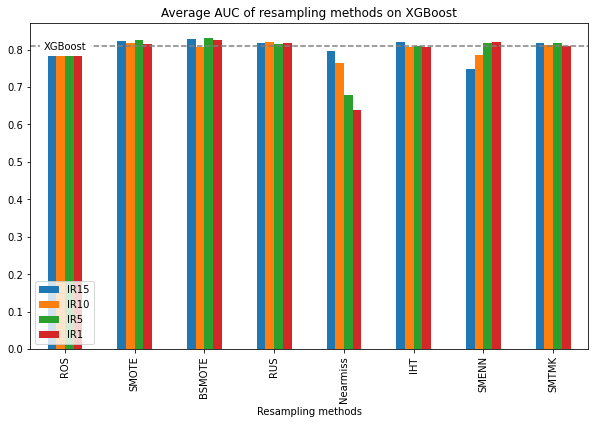

In [60]:
# calculate mean auc of five datasets in case of certain approach and certain ir
#xgb 
xgb_meanauc =statistics.mean([xgb_auc.iloc[0,8], xgb_auc.iloc[4,8], 
                        xgb_auc.iloc[8,8], xgb_auc.iloc[12,8], xgb_auc.iloc[16,8]]).round(3)

#ros
ros15 =statistics.mean([xgb_auc.iloc[0,0], xgb_auc.iloc[4,0], 
                        xgb_auc.iloc[8,0], xgb_auc.iloc[12,0], xgb_auc.iloc[16,0]]).round(3)
ros10 =statistics.mean([xgb_auc.iloc[1,0], xgb_auc.iloc[5,0], 
                        xgb_auc.iloc[9,0], xgb_auc.iloc[13,0], xgb_auc.iloc[17,0]]).round(3)
ros5 =statistics.mean([xgb_auc.iloc[2,0], xgb_auc.iloc[6,0], 
                        xgb_auc.iloc[10,0], xgb_auc.iloc[14,0], xgb_auc.iloc[18,0]]).round(3)
ros1 =statistics.mean([xgb_auc.iloc[3,0], xgb_auc.iloc[7,0], 
                        xgb_auc.iloc[11,0], xgb_auc.iloc[15,0], xgb_auc.iloc[19,0]]).round(3)

#smote
smote15 =statistics.mean([xgb_auc.iloc[0,1], xgb_auc.iloc[4,1], 
                        xgb_auc.iloc[8,1], xgb_auc.iloc[12,1], xgb_auc.iloc[16,1]]).round(3)
smote10 =statistics.mean([xgb_auc.iloc[1,1], xgb_auc.iloc[5,1], 
                        xgb_auc.iloc[9,1], xgb_auc.iloc[13,1], xgb_auc.iloc[17,1]]).round(3)
smote5 =statistics.mean([xgb_auc.iloc[2,1], xgb_auc.iloc[6,1], 
                        xgb_auc.iloc[10,1], xgb_auc.iloc[14,1], xgb_auc.iloc[18,1]]).round(3)
smote1 =statistics.mean([xgb_auc.iloc[3,1], xgb_auc.iloc[7,1], 
                        xgb_auc.iloc[11,1], xgb_auc.iloc[15,1], xgb_auc.iloc[19,1]]).round(3)

#bsmote
bsmote15 =statistics.mean([xgb_auc.iloc[0,2], xgb_auc.iloc[4,2], 
                        xgb_auc.iloc[8,2], xgb_auc.iloc[12,2], xgb_auc.iloc[16,2]]).round(3)
bsmote10 =statistics.mean([xgb_auc.iloc[1,2], xgb_auc.iloc[5,2], 
                        xgb_auc.iloc[9,2], xgb_auc.iloc[13,2], xgb_auc.iloc[17,2]]).round(3)
bsmote5 =statistics.mean([xgb_auc.iloc[2,2], xgb_auc.iloc[6,2], 
                        xgb_auc.iloc[10,2], xgb_auc.iloc[14,2], xgb_auc.iloc[18,2]]).round(3)
bsmote1 =statistics.mean([xgb_auc.iloc[3,2], xgb_auc.iloc[7,2], 
                        xgb_auc.iloc[11,2], xgb_auc.iloc[15,2], xgb_auc.iloc[19,2]]).round(3)

#rus
rus15 =statistics.mean([xgb_auc.iloc[0,3], xgb_auc.iloc[4,3], 
                        xgb_auc.iloc[8,3], xgb_auc.iloc[12,3], xgb_auc.iloc[16,3]]).round(3)
rus10 =statistics.mean([xgb_auc.iloc[1,3], xgb_auc.iloc[5,3], 
                        xgb_auc.iloc[9,3], xgb_auc.iloc[13,3], xgb_auc.iloc[17,3]]).round(3)
rus5 =statistics.mean([xgb_auc.iloc[2,3], xgb_auc.iloc[6,3], 
                        xgb_auc.iloc[10,3], xgb_auc.iloc[14,3], xgb_auc.iloc[18,3]]).round(3)
rus1 =statistics.mean([xgb_auc.iloc[3,3], xgb_auc.iloc[7,3], 
                        xgb_auc.iloc[11,3], xgb_auc.iloc[15,3], xgb_auc.iloc[19,3]]).round(3)

#nn
nn15 =statistics.mean([xgb_auc.iloc[0,4], xgb_auc.iloc[4,4], 
                        xgb_auc.iloc[8,4], xgb_auc.iloc[12,4], xgb_auc.iloc[16,4]]).round(3)
nn10 =statistics.mean([xgb_auc.iloc[1,4], xgb_auc.iloc[5,4], 
                        xgb_auc.iloc[9,4], xgb_auc.iloc[13,4], xgb_auc.iloc[17,4]]).round(3)
nn5 =statistics.mean([xgb_auc.iloc[2,4], xgb_auc.iloc[6,4], 
                        xgb_auc.iloc[10,4], xgb_auc.iloc[14,4], xgb_auc.iloc[18,4]]).round(3)
nn1 =statistics.mean([xgb_auc.iloc[3,4], xgb_auc.iloc[7,4], 
                        xgb_auc.iloc[11,4], xgb_auc.iloc[15,4], xgb_auc.iloc[19,4]]).round(3)

#iht
iht15 =statistics.mean([xgb_auc.iloc[0,5], xgb_auc.iloc[4,5], 
                        xgb_auc.iloc[8,5], xgb_auc.iloc[12,5], xgb_auc.iloc[16,5]]).round(3)
iht10 =statistics.mean([xgb_auc.iloc[1,5], xgb_auc.iloc[5,5], 
                        xgb_auc.iloc[9,5], xgb_auc.iloc[13,5], xgb_auc.iloc[17,5]]).round(3)
iht5 =statistics.mean([xgb_auc.iloc[2,5], xgb_auc.iloc[6,5], 
                        xgb_auc.iloc[10,5], xgb_auc.iloc[14,5], xgb_auc.iloc[18,5]]).round(3)
iht1 =statistics.mean([xgb_auc.iloc[3,5], xgb_auc.iloc[7,5], 
                        xgb_auc.iloc[11,5], xgb_auc.iloc[15,5], xgb_auc.iloc[19,5]]).round(3)

#smenn
smenn15 =statistics.mean([xgb_auc.iloc[0,6], xgb_auc.iloc[4,6], 
                        xgb_auc.iloc[8,6], xgb_auc.iloc[12,6], xgb_auc.iloc[16,6]]).round(3)
smenn10 =statistics.mean([xgb_auc.iloc[1,6], xgb_auc.iloc[5,6], 
                        xgb_auc.iloc[9,6], xgb_auc.iloc[13,6], xgb_auc.iloc[17,6]]).round(3)
smenn5 =statistics.mean([xgb_auc.iloc[2,6], xgb_auc.iloc[6,6], 
                        xgb_auc.iloc[10,6], xgb_auc.iloc[14,6], xgb_auc.iloc[18,6]]).round(3)
smenn1 =statistics.mean([xgb_auc.iloc[3,6], xgb_auc.iloc[7,6], 
                        xgb_auc.iloc[11,6], xgb_auc.iloc[15,6], xgb_auc.iloc[19,6]]).round(3)

#smt
smt15 =statistics.mean([xgb_auc.iloc[0,7], xgb_auc.iloc[4,7], 
                        xgb_auc.iloc[8,7], xgb_auc.iloc[12,7], xgb_auc.iloc[16,7]]).round(3)
smt10 =statistics.mean([xgb_auc.iloc[1,7], xgb_auc.iloc[5,7], 
                        xgb_auc.iloc[9,7], xgb_auc.iloc[13,7], xgb_auc.iloc[17,7]]).round(3)
smt5 =statistics.mean([xgb_auc.iloc[2,7], xgb_auc.iloc[6,7], 
                        xgb_auc.iloc[10,7], xgb_auc.iloc[14,7], xgb_auc.iloc[18,7]]).round(3)
smt1 =statistics.mean([xgb_auc.iloc[3,7], xgb_auc.iloc[7,7], 
                        xgb_auc.iloc[11,7], xgb_auc.iloc[15,7], xgb_auc.iloc[19,7]]).round(3)

# create data
df = pd.DataFrame([['ROS', ros15, ros10, ros5, ros1], ['SMOTE', smote15, smote10, smote5, smote1], 
                   ['BSMOTE', bsmote15, bsmote10, bsmote5, bsmote1],['RUS', rus15, rus10, rus5, rus1], 
                   ['Nearmiss', nn15, nn10, nn5, nn1], ['IHT', iht15, iht10, iht5, iht1],
                   ['SMENN', smenn15, smenn10, smenn5, smenn1], ['SMTMK', smt15, smt10, smt5, smt1]],
                  columns=['Resampling methods', 'IR15', 'IR10', 'IR5', 'IR1'])
# view data
print(df)

# plot grouped bar chart
df.plot(x='Resampling methods',
        kind='bar',
        stacked=False,
        title='Average AUC of resampling methods on XGBoost')

#add a dash line of avaerage xgb auc

plt.axhline(y= xgb_meanauc,color='grey', linestyle ='dashed')
plt.text(0, xgb_meanauc, 'XGBoost', fontsize=10, va='center', ha='center', backgroundcolor='w')

#adjust the size of plot    
plt.rcParams["figure.figsize"] = [10, 6]
plt.savefig('./result/xgb_auc.jpg')
plt.show()

  Resampling methods   IR15   IR10    IR5    IR1
0                ROS  0.311  0.360  0.447  0.673
1              SMOTE  0.277  0.254  0.359  0.563
2             BSMOTE  0.283  0.297  0.360  0.613
3                RUS  0.322  0.393  0.580  0.752
4           Nearmiss  0.417  0.440  0.588  0.496
5                IHT  0.551  0.656  0.745  0.751
6              SMENN  0.125  0.237  0.346  0.595
7              SMTMK  0.278  0.303  0.347  0.497


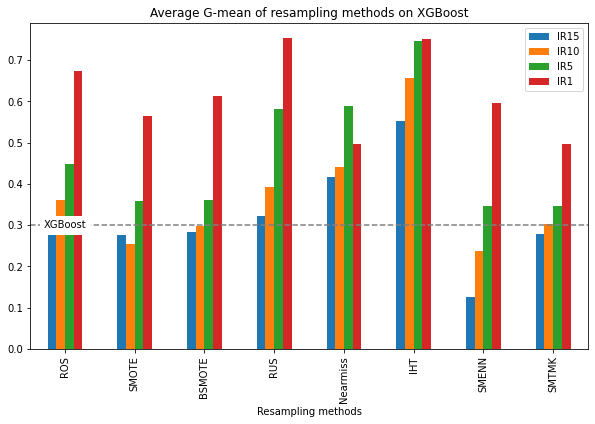

In [61]:
# calculate mean gmeans of five datasets in case of certain approach and certain ir
#xgb 
xgb_meangmeans =statistics.mean([xgb_gmeans.iloc[0,8], xgb_gmeans.iloc[4,8], 
                        xgb_gmeans.iloc[8,8], xgb_gmeans.iloc[12,8], xgb_gmeans.iloc[16,8]]).round(3)

#ros
ros15 =statistics.mean([xgb_gmeans.iloc[0,0], xgb_gmeans.iloc[4,0], 
                        xgb_gmeans.iloc[8,0], xgb_gmeans.iloc[12,0], xgb_gmeans.iloc[16,0]]).round(3)
ros10 =statistics.mean([xgb_gmeans.iloc[1,0], xgb_gmeans.iloc[5,0], 
                        xgb_gmeans.iloc[9,0], xgb_gmeans.iloc[13,0], xgb_gmeans.iloc[17,0]]).round(3)
ros5 =statistics.mean([xgb_gmeans.iloc[2,0], xgb_gmeans.iloc[6,0], 
                        xgb_gmeans.iloc[10,0], xgb_gmeans.iloc[14,0], xgb_gmeans.iloc[18,0]]).round(3)
ros1 =statistics.mean([xgb_gmeans.iloc[3,0], xgb_gmeans.iloc[7,0], 
                        xgb_gmeans.iloc[11,0], xgb_gmeans.iloc[15,0], xgb_gmeans.iloc[19,0]]).round(3)

#smote
smote15 =statistics.mean([xgb_gmeans.iloc[0,1], xgb_gmeans.iloc[4,1], 
                        xgb_gmeans.iloc[8,1], xgb_gmeans.iloc[12,1], xgb_gmeans.iloc[16,1]]).round(3)
smote10 =statistics.mean([xgb_gmeans.iloc[1,1], xgb_gmeans.iloc[5,1], 
                        xgb_gmeans.iloc[9,1], xgb_gmeans.iloc[13,1], xgb_gmeans.iloc[17,1]]).round(3)
smote5 =statistics.mean([xgb_gmeans.iloc[2,1], xgb_gmeans.iloc[6,1], 
                        xgb_gmeans.iloc[10,1], xgb_gmeans.iloc[14,1], xgb_gmeans.iloc[18,1]]).round(3)
smote1 =statistics.mean([xgb_gmeans.iloc[3,1], xgb_gmeans.iloc[7,1], 
                        xgb_gmeans.iloc[11,1], xgb_gmeans.iloc[15,1], xgb_gmeans.iloc[19,1]]).round(3)

#bsmote
bsmote15 =statistics.mean([xgb_gmeans.iloc[0,2], xgb_gmeans.iloc[4,2], 
                        xgb_gmeans.iloc[8,2], xgb_gmeans.iloc[12,2], xgb_gmeans.iloc[16,2]]).round(3)
bsmote10 =statistics.mean([xgb_gmeans.iloc[1,2], xgb_gmeans.iloc[5,2], 
                        xgb_gmeans.iloc[9,2], xgb_gmeans.iloc[13,2], xgb_gmeans.iloc[17,2]]).round(3)
bsmote5 =statistics.mean([xgb_gmeans.iloc[2,2], xgb_gmeans.iloc[6,2], 
                        xgb_gmeans.iloc[10,2], xgb_gmeans.iloc[14,2], xgb_gmeans.iloc[18,2]]).round(3)
bsmote1 =statistics.mean([xgb_gmeans.iloc[3,2], xgb_gmeans.iloc[7,2], 
                        xgb_gmeans.iloc[11,2], xgb_gmeans.iloc[15,2], xgb_gmeans.iloc[19,2]]).round(3)

#rus
rus15 =statistics.mean([xgb_gmeans.iloc[0,3], xgb_gmeans.iloc[4,3], 
                        xgb_gmeans.iloc[8,3], xgb_gmeans.iloc[12,3], xgb_gmeans.iloc[16,3]]).round(3)
rus10 =statistics.mean([xgb_gmeans.iloc[1,3], xgb_gmeans.iloc[5,3], 
                        xgb_gmeans.iloc[9,3], xgb_gmeans.iloc[13,3], xgb_gmeans.iloc[17,3]]).round(3)
rus5 =statistics.mean([xgb_gmeans.iloc[2,3], xgb_gmeans.iloc[6,3], 
                        xgb_gmeans.iloc[10,3], xgb_gmeans.iloc[14,3], xgb_gmeans.iloc[18,3]]).round(3)
rus1 =statistics.mean([xgb_gmeans.iloc[3,3], xgb_gmeans.iloc[7,3], 
                        xgb_gmeans.iloc[11,3], xgb_gmeans.iloc[15,3], xgb_gmeans.iloc[19,3]]).round(3)

#nn
nn15 =statistics.mean([xgb_gmeans.iloc[0,4], xgb_gmeans.iloc[4,4], 
                        xgb_gmeans.iloc[8,4], xgb_gmeans.iloc[12,4], xgb_gmeans.iloc[16,4]]).round(3)
nn10 =statistics.mean([xgb_gmeans.iloc[1,4], xgb_gmeans.iloc[5,4], 
                        xgb_gmeans.iloc[9,4], xgb_gmeans.iloc[13,4], xgb_gmeans.iloc[17,4]]).round(3)
nn5 =statistics.mean([xgb_gmeans.iloc[2,4], xgb_gmeans.iloc[6,4], 
                        xgb_gmeans.iloc[10,4], xgb_gmeans.iloc[14,4], xgb_gmeans.iloc[18,4]]).round(3)
nn1 =statistics.mean([xgb_gmeans.iloc[3,4], xgb_gmeans.iloc[7,4], 
                        xgb_gmeans.iloc[11,4], xgb_gmeans.iloc[15,4], xgb_gmeans.iloc[19,4]]).round(3)

#iht
iht15 =statistics.mean([xgb_gmeans.iloc[0,5], xgb_gmeans.iloc[4,5], 
                        xgb_gmeans.iloc[8,5], xgb_gmeans.iloc[12,5], xgb_gmeans.iloc[16,5]]).round(3)
iht10 =statistics.mean([xgb_gmeans.iloc[1,5], xgb_gmeans.iloc[5,5], 
                        xgb_gmeans.iloc[9,5], xgb_gmeans.iloc[13,5], xgb_gmeans.iloc[17,5]]).round(3)
iht5 =statistics.mean([xgb_gmeans.iloc[2,5], xgb_gmeans.iloc[6,5], 
                        xgb_gmeans.iloc[10,5], xgb_gmeans.iloc[14,5], xgb_gmeans.iloc[18,5]]).round(3)
iht1 =statistics.mean([xgb_gmeans.iloc[3,5], xgb_gmeans.iloc[7,5], 
                        xgb_gmeans.iloc[11,5], xgb_gmeans.iloc[15,5], xgb_gmeans.iloc[19,5]]).round(3)

#smenn
smenn15 =statistics.mean([xgb_gmeans.iloc[0,6], xgb_gmeans.iloc[4,6], 
                        xgb_gmeans.iloc[8,6], xgb_gmeans.iloc[12,6], xgb_gmeans.iloc[16,6]]).round(3)
smenn10 =statistics.mean([xgb_gmeans.iloc[1,6], xgb_gmeans.iloc[5,6], 
                        xgb_gmeans.iloc[9,6], xgb_gmeans.iloc[13,6], xgb_gmeans.iloc[17,6]]).round(3)
smenn5 =statistics.mean([xgb_gmeans.iloc[2,6], xgb_gmeans.iloc[6,6], 
                        xgb_gmeans.iloc[10,6], xgb_gmeans.iloc[14,6], xgb_gmeans.iloc[18,6]]).round(3)
smenn1 =statistics.mean([xgb_gmeans.iloc[3,6], xgb_gmeans.iloc[7,6], 
                        xgb_gmeans.iloc[11,6], xgb_gmeans.iloc[15,6], xgb_gmeans.iloc[19,6]]).round(3)

#smt
smt15 =statistics.mean([xgb_gmeans.iloc[0,7], xgb_gmeans.iloc[4,7], 
                        xgb_gmeans.iloc[8,7], xgb_gmeans.iloc[12,7], xgb_gmeans.iloc[16,7]]).round(3)
smt10 =statistics.mean([xgb_gmeans.iloc[1,7], xgb_gmeans.iloc[5,7], 
                        xgb_gmeans.iloc[9,7], xgb_gmeans.iloc[13,7], xgb_gmeans.iloc[17,7]]).round(3)
smt5 =statistics.mean([xgb_gmeans.iloc[2,7], xgb_gmeans.iloc[6,7], 
                        xgb_gmeans.iloc[10,7], xgb_gmeans.iloc[14,7], xgb_gmeans.iloc[18,7]]).round(3)
smt1 =statistics.mean([xgb_gmeans.iloc[3,7], xgb_gmeans.iloc[7,7], 
                        xgb_gmeans.iloc[11,7], xgb_gmeans.iloc[15,7], xgb_gmeans.iloc[19,7]]).round(3)

# create data
df = pd.DataFrame([['ROS', ros15, ros10, ros5, ros1], ['SMOTE', smote15, smote10, smote5, smote1], 
                   ['BSMOTE', bsmote15, bsmote10, bsmote5, bsmote1],['RUS', rus15, rus10, rus5, rus1], 
                   ['Nearmiss', nn15, nn10, nn5, nn1], ['IHT', iht15, iht10, iht5, iht1],
                   ['SMENN', smenn15, smenn10, smenn5, smenn1], ['SMTMK', smt15, smt10, smt5, smt1]],
                  columns=['Resampling methods', 'IR15', 'IR10', 'IR5', 'IR1'])
# view data
print(df)

# plot grouped bar chart
df.plot(x='Resampling methods',
        kind='bar',
        stacked=False,
        title='Average G-mean of resampling methods on XGBoost')

#add a dash line of avaerage xgb gmeans

plt.axhline(y= xgb_meangmeans,color='grey', linestyle ='dashed')
plt.text(0, xgb_meangmeans, 'XGBoost', fontsize=10, va='center', ha='center', backgroundcolor='w')

#adjust the size of plot    
plt.rcParams["figure.figsize"] = [10, 6]
plt.savefig('./result/xgb_gmean.jpg')
plt.show()


  Resampling methods   IR15   IR10    IR5    IR1
0                ROS  0.221  0.256  0.308  0.315
1              SMOTE  0.189  0.173  0.245  0.290
2             BSMOTE  0.181  0.196  0.231  0.334
3                RUS  0.219  0.278  0.363  0.235
4           Nearmiss  0.219  0.179  0.146  0.105
5                IHT  0.297  0.289  0.261  0.252
6              SMENN  0.054  0.130  0.205  0.282
7              SMTMK  0.188  0.196  0.231  0.292


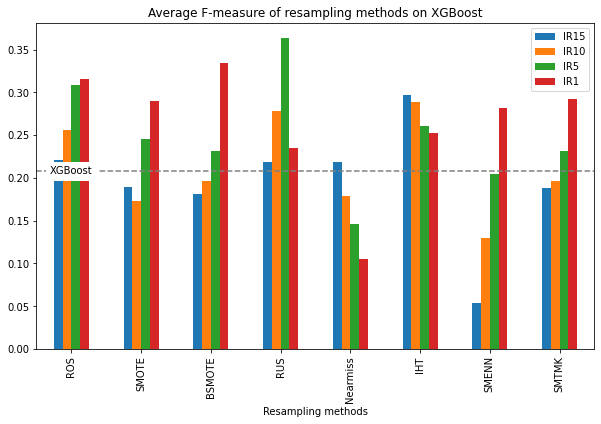

In [62]:
# calculate mean fmeasure of five datasets in case of certain approach and certain ir
#xgb 
xgb_meanfmeasure =statistics.mean([xgb_fmeasure.iloc[0,8], xgb_fmeasure.iloc[4,8], 
                        xgb_fmeasure.iloc[8,8], xgb_fmeasure.iloc[12,8], xgb_fmeasure.iloc[16,8]]).round(3)

#ros
ros15 =statistics.mean([xgb_fmeasure.iloc[0,0], xgb_fmeasure.iloc[4,0], 
                        xgb_fmeasure.iloc[8,0], xgb_fmeasure.iloc[12,0], xgb_fmeasure.iloc[16,0]]).round(3)
ros10 =statistics.mean([xgb_fmeasure.iloc[1,0], xgb_fmeasure.iloc[5,0], 
                        xgb_fmeasure.iloc[9,0], xgb_fmeasure.iloc[13,0], xgb_fmeasure.iloc[17,0]]).round(3)
ros5 =statistics.mean([xgb_fmeasure.iloc[2,0], xgb_fmeasure.iloc[6,0], 
                        xgb_fmeasure.iloc[10,0], xgb_fmeasure.iloc[14,0], xgb_fmeasure.iloc[18,0]]).round(3)
ros1 =statistics.mean([xgb_fmeasure.iloc[3,0], xgb_fmeasure.iloc[7,0], 
                        xgb_fmeasure.iloc[11,0], xgb_fmeasure.iloc[15,0], xgb_fmeasure.iloc[19,0]]).round(3)

#smote
smote15 =statistics.mean([xgb_fmeasure.iloc[0,1], xgb_fmeasure.iloc[4,1], 
                        xgb_fmeasure.iloc[8,1], xgb_fmeasure.iloc[12,1], xgb_fmeasure.iloc[16,1]]).round(3)
smote10 =statistics.mean([xgb_fmeasure.iloc[1,1], xgb_fmeasure.iloc[5,1], 
                        xgb_fmeasure.iloc[9,1], xgb_fmeasure.iloc[13,1], xgb_fmeasure.iloc[17,1]]).round(3)
smote5 =statistics.mean([xgb_fmeasure.iloc[2,1], xgb_fmeasure.iloc[6,1], 
                        xgb_fmeasure.iloc[10,1], xgb_fmeasure.iloc[14,1], xgb_fmeasure.iloc[18,1]]).round(3)
smote1 =statistics.mean([xgb_fmeasure.iloc[3,1], xgb_fmeasure.iloc[7,1], 
                        xgb_fmeasure.iloc[11,1], xgb_fmeasure.iloc[15,1], xgb_fmeasure.iloc[19,1]]).round(3)

#bsmote
bsmote15 =statistics.mean([xgb_fmeasure.iloc[0,2], xgb_fmeasure.iloc[4,2], 
                        xgb_fmeasure.iloc[8,2], xgb_fmeasure.iloc[12,2], xgb_fmeasure.iloc[16,2]]).round(3)
bsmote10 =statistics.mean([xgb_fmeasure.iloc[1,2], xgb_fmeasure.iloc[5,2], 
                        xgb_fmeasure.iloc[9,2], xgb_fmeasure.iloc[13,2], xgb_fmeasure.iloc[17,2]]).round(3)
bsmote5 =statistics.mean([xgb_fmeasure.iloc[2,2], xgb_fmeasure.iloc[6,2], 
                        xgb_fmeasure.iloc[10,2], xgb_fmeasure.iloc[14,2], xgb_fmeasure.iloc[18,2]]).round(3)
bsmote1 =statistics.mean([xgb_fmeasure.iloc[3,2], xgb_fmeasure.iloc[7,2], 
                        xgb_fmeasure.iloc[11,2], xgb_fmeasure.iloc[15,2], xgb_fmeasure.iloc[19,2]]).round(3)

#rus
rus15 =statistics.mean([xgb_fmeasure.iloc[0,3], xgb_fmeasure.iloc[4,3], 
                        xgb_fmeasure.iloc[8,3], xgb_fmeasure.iloc[12,3], xgb_fmeasure.iloc[16,3]]).round(3)
rus10 =statistics.mean([xgb_fmeasure.iloc[1,3], xgb_fmeasure.iloc[5,3], 
                        xgb_fmeasure.iloc[9,3], xgb_fmeasure.iloc[13,3], xgb_fmeasure.iloc[17,3]]).round(3)
rus5 =statistics.mean([xgb_fmeasure.iloc[2,3], xgb_fmeasure.iloc[6,3], 
                        xgb_fmeasure.iloc[10,3], xgb_fmeasure.iloc[14,3], xgb_fmeasure.iloc[18,3]]).round(3)
rus1 =statistics.mean([xgb_fmeasure.iloc[3,3], xgb_fmeasure.iloc[7,3], 
                        xgb_fmeasure.iloc[11,3], xgb_fmeasure.iloc[15,3], xgb_fmeasure.iloc[19,3]]).round(3)

#nn
nn15 =statistics.mean([xgb_fmeasure.iloc[0,4], xgb_fmeasure.iloc[4,4], 
                        xgb_fmeasure.iloc[8,4], xgb_fmeasure.iloc[12,4], xgb_fmeasure.iloc[16,4]]).round(3)
nn10 =statistics.mean([xgb_fmeasure.iloc[1,4], xgb_fmeasure.iloc[5,4], 
                        xgb_fmeasure.iloc[9,4], xgb_fmeasure.iloc[13,4], xgb_fmeasure.iloc[17,4]]).round(3)
nn5 =statistics.mean([xgb_fmeasure.iloc[2,4], xgb_fmeasure.iloc[6,4], 
                        xgb_fmeasure.iloc[10,4], xgb_fmeasure.iloc[14,4], xgb_fmeasure.iloc[18,4]]).round(3)
nn1 =statistics.mean([xgb_fmeasure.iloc[3,4], xgb_fmeasure.iloc[7,4], 
                        xgb_fmeasure.iloc[11,4], xgb_fmeasure.iloc[15,4], xgb_fmeasure.iloc[19,4]]).round(3)

#iht
iht15 =statistics.mean([xgb_fmeasure.iloc[0,5], xgb_fmeasure.iloc[4,5], 
                        xgb_fmeasure.iloc[8,5], xgb_fmeasure.iloc[12,5], xgb_fmeasure.iloc[16,5]]).round(3)
iht10 =statistics.mean([xgb_fmeasure.iloc[1,5], xgb_fmeasure.iloc[5,5], 
                        xgb_fmeasure.iloc[9,5], xgb_fmeasure.iloc[13,5], xgb_fmeasure.iloc[17,5]]).round(3)
iht5 =statistics.mean([xgb_fmeasure.iloc[2,5], xgb_fmeasure.iloc[6,5], 
                        xgb_fmeasure.iloc[10,5], xgb_fmeasure.iloc[14,5], xgb_fmeasure.iloc[18,5]]).round(3)
iht1 =statistics.mean([xgb_fmeasure.iloc[3,5], xgb_fmeasure.iloc[7,5], 
                        xgb_fmeasure.iloc[11,5], xgb_fmeasure.iloc[15,5], xgb_fmeasure.iloc[19,5]]).round(3)

#smenn
smenn15 =statistics.mean([xgb_fmeasure.iloc[0,6], xgb_fmeasure.iloc[4,6], 
                        xgb_fmeasure.iloc[8,6], xgb_fmeasure.iloc[12,6], xgb_fmeasure.iloc[16,6]]).round(3)
smenn10 =statistics.mean([xgb_fmeasure.iloc[1,6], xgb_fmeasure.iloc[5,6], 
                        xgb_fmeasure.iloc[9,6], xgb_fmeasure.iloc[13,6], xgb_fmeasure.iloc[17,6]]).round(3)
smenn5 =statistics.mean([xgb_fmeasure.iloc[2,6], xgb_fmeasure.iloc[6,6], 
                        xgb_fmeasure.iloc[10,6], xgb_fmeasure.iloc[14,6], xgb_fmeasure.iloc[18,6]]).round(3)
smenn1 =statistics.mean([xgb_fmeasure.iloc[3,6], xgb_fmeasure.iloc[7,6], 
                        xgb_fmeasure.iloc[11,6], xgb_fmeasure.iloc[15,6], xgb_fmeasure.iloc[19,6]]).round(3)

#smt
smt15 =statistics.mean([xgb_fmeasure.iloc[0,7], xgb_fmeasure.iloc[4,7], 
                        xgb_fmeasure.iloc[8,7], xgb_fmeasure.iloc[12,7], xgb_fmeasure.iloc[16,7]]).round(3)
smt10 =statistics.mean([xgb_fmeasure.iloc[1,7], xgb_fmeasure.iloc[5,7], 
                        xgb_fmeasure.iloc[9,7], xgb_fmeasure.iloc[13,7], xgb_fmeasure.iloc[17,7]]).round(3)
smt5 =statistics.mean([xgb_fmeasure.iloc[2,7], xgb_fmeasure.iloc[6,7], 
                        xgb_fmeasure.iloc[10,7], xgb_fmeasure.iloc[14,7], xgb_fmeasure.iloc[18,7]]).round(3)
smt1 =statistics.mean([xgb_fmeasure.iloc[3,7], xgb_fmeasure.iloc[7,7], 
                        xgb_fmeasure.iloc[11,7], xgb_fmeasure.iloc[15,7], xgb_fmeasure.iloc[19,7]]).round(3)

# create data
df = pd.DataFrame([['ROS', ros15, ros10, ros5, ros1], ['SMOTE', smote15, smote10, smote5, smote1], 
                   ['BSMOTE', bsmote15, bsmote10, bsmote5, bsmote1],['RUS', rus15, rus10, rus5, rus1], 
                   ['Nearmiss', nn15, nn10, nn5, nn1], ['IHT', iht15, iht10, iht5, iht1],
                   ['SMENN', smenn15, smenn10, smenn5, smenn1], ['SMTMK', smt15, smt10, smt5, smt1]],
                  columns=['Resampling methods', 'IR15', 'IR10', 'IR5', 'IR1'])
# view data
print(df)

# plot grouped bar chart
df.plot(x='Resampling methods',
        kind='bar',
        stacked=False,
        title='Average F-measure of resampling methods on XGBoost')

#add a dash line of avaerage xgb fmeasure

plt.axhline(y= xgb_meanfmeasure,color='grey', linestyle ='dashed')
plt.text(0, xgb_meanfmeasure, 'XGBoost', fontsize=10, va='center', ha='center', backgroundcolor='w')

#adjust the size of plot    
plt.rcParams["figure.figsize"] = [10, 6]
plt.savefig('./result/xgb_fmeasure.jpg')
plt.show()

### 3.1.3 Calculate average rank of resampling approaches

In [63]:
rank_xgbauc = rank_cal(xgb_auc)
rank_xgbgmeans= rank_cal(xgb_gmeans)
rank_xgbfmeasure= rank_cal(xgb_fmeasure)
rank_xgb3dim= rank_cal(xgb_3dim)

#aggregate into df
my_array = np.array([rank_xgbauc, rank_xgbgmeans, rank_xgbfmeasure,rank_xgb3dim ])

xgb_approach = pd.DataFrame(my_array, columns = ['RandomOverSampler', 'SMOTE', 'BorderlineSMOTE', 'RandomUnderSampler',
       'NearMiss', 'InstanceHardnessThreshold', 'SMOTEENN', 'SMOTETomek',
       'XGB'], index = ['AUC', 'Gmeans','Fmeasure', 'Combination'])

xgb_approach

Index(['RandomOverSampler', 'SMOTE', 'BorderlineSMOTE', 'RandomUnderSampler',
       'NearMiss', 'InstanceHardnessThreshold', 'SMOTEENN', 'SMOTETomek',
       'xgb'],
      dtype='object', name='Approaches')
Index(['RandomOverSampler', 'SMOTE', 'BorderlineSMOTE', 'RandomUnderSampler',
       'NearMiss', 'InstanceHardnessThreshold', 'SMOTEENN', 'SMOTETomek',
       'xgb'],
      dtype='object', name='Approaches')
Index(['RandomOverSampler', 'SMOTE', 'BorderlineSMOTE', 'RandomUnderSampler',
       'NearMiss', 'InstanceHardnessThreshold', 'SMOTEENN', 'SMOTETomek',
       'xgb'],
      dtype='object', name='Approaches')
Index(['RandomOverSampler', 'SMOTE', 'BorderlineSMOTE', 'RandomUnderSampler',
       'NearMiss', 'InstanceHardnessThreshold', 'SMOTEENN', 'SMOTETomek',
       'xgb'],
      dtype='object', name='Approaches')


,RandomOverSampler,SMOTE,BorderlineSMOTE,RandomUnderSampler,NearMiss,InstanceHardnessThreshold,SMOTEENN,SMOTETomek,XGB
AUC,3.425,4.475,4.550,4.125,8.0,4.625,6.350,5.675,3.775
Gmeans,3.950,6.525,6.200,3.025,3.7,1.375,6.625,6.550,7.050
Fmeasure,3.350,5.725,4.825,3.350,6.3,3.625,6.325,5.450,6.050
Combination,3.575,5.575,5.192,3.500,6.0,3.208,6.433,5.892,5.625


In [64]:
#write into table
xgb_approach.to_csv(path + '/xgb_approach.csv', index =True, encoding = 'utf-8-sig') 

### 3.1.4 Perform Friedman test

In [65]:
#Friedman test
#The null-hypothesis of the Friedman test is that all resampling
#methods perform the same; also, the rejection of this
#null hypothesis implies that one or more of the resampling
#methods have a different performance.
friedmanchisquare(xgb_auc['RandomOverSampler'],xgb_auc['SMOTE'],xgb_auc['BorderlineSMOTE'],
                 xgb_auc['RandomUnderSampler'],xgb_auc['NearMiss'],xgb_auc['InstanceHardnessThreshold'],
                 xgb_auc['SMOTEENN'],xgb_auc['SMOTETomek'],xgb_auc['xgb'])
#since this p-value is less than 0.05, we can reject the null hypothesis


FriedmanchisquareResult(statistic=45.04016913319238, pvalue=3.6160310913888927e-07)

In [66]:
friedmanchisquare(xgb_gmeans['RandomOverSampler'],xgb_gmeans['SMOTE'],xgb_gmeans['BorderlineSMOTE'],
                 xgb_gmeans['RandomUnderSampler'],xgb_gmeans['NearMiss'],
                xgb_gmeans['InstanceHardnessThreshold'],
                 xgb_gmeans['SMOTEENN'],xgb_gmeans['SMOTETomek'],xgb_gmeans['xgb'])

FriedmanchisquareResult(statistic=96.02923709456377, pvalue=2.759885674776013e-17)

In [67]:
friedmanchisquare(xgb_fmeasure['RandomOverSampler'],xgb_fmeasure['SMOTE'],xgb_fmeasure['BorderlineSMOTE'],
                 xgb_fmeasure['RandomUnderSampler'],xgb_fmeasure['NearMiss'],xgb_fmeasure['InstanceHardnessThreshold'],
                 xgb_fmeasure['SMOTEENN'],xgb_fmeasure['SMOTETomek'],xgb_fmeasure['xgb'])


FriedmanchisquareResult(statistic=36.946118721461225, pvalue=1.1774503729038663e-05)

In [68]:
friedmanchisquare(xgb_3dim['RandomOverSampler'],xgb_3dim['SMOTE'],xgb_3dim['BorderlineSMOTE'],
                 xgb_3dim['RandomUnderSampler'],xgb_3dim['NearMiss'],xgb_3dim['InstanceHardnessThreshold'],
                 xgb_3dim['SMOTEENN'],xgb_3dim['SMOTETomek'],xgb_3dim['xgb'])


FriedmanchisquareResult(statistic=103.32977461447202, pvalue=8.894308599314313e-19)

### 3.1.5 Perform Nemenyi_test

In [69]:
nemenyi_test(xgb_auc)

                           RandomOverSampler  SMOTE  BorderlineSMOTE  \
RandomOverSampler                      1.000  0.900            0.900   
SMOTE                                  0.900  1.000            0.900   
BorderlineSMOTE                        0.900  0.900            1.000   
RandomUnderSampler                     0.900  0.900            0.900   
NearMiss                               0.001  0.002            0.002   
InstanceHardnessThreshold              0.900  0.900            0.900   
SMOTEENN                               0.021  0.432            0.489   
SMOTETomek                             0.187  0.900            0.900   
xgb                                    0.900  0.900            0.900   

                           RandomUnderSampler  NearMiss  \
RandomOverSampler                       0.900     0.001   
SMOTE                                   0.900     0.002   
BorderlineSMOTE                         0.900     0.002   
RandomUnderSampler                      1.0

,RandomOverSampler,SMOTE,BorderlineSMOTE,RandomUnderSampler,NearMiss,InstanceHardnessThreshold,SMOTEENN,SMOTETomek,xgb
RandomOverSampler,False,False,False,False,True,False,True,False,False
SMOTE,False,False,False,False,True,False,False,False,False
BorderlineSMOTE,False,False,False,False,True,False,False,False,False
RandomUnderSampler,False,False,False,False,True,False,False,False,False
NearMiss,True,True,True,True,False,True,False,False,True
InstanceHardnessThreshold,False,False,False,False,True,False,False,False,False
SMOTEENN,True,False,False,False,False,False,False,False,False
SMOTETomek,False,False,False,False,False,False,False,False,False
xgb,False,False,False,False,True,False,False,False,False


In [70]:
nemenyi_test(xgb_gmeans)

                           RandomOverSampler  SMOTE  BorderlineSMOTE  \
RandomOverSampler                      1.000  0.073            0.187   
SMOTE                                  0.073  1.000            0.900   
BorderlineSMOTE                        0.187  0.900            1.000   
RandomUnderSampler                     0.900  0.002            0.008   
NearMiss                               0.900  0.031            0.092   
InstanceHardnessThreshold              0.073  0.001            0.001   
SMOTEENN                               0.052  0.900            0.900   
SMOTETomek                             0.067  0.900            0.900   
xgb                                    0.010  0.900            0.900   

                           RandomUnderSampler  NearMiss  \
RandomOverSampler                       0.900     0.900   
SMOTE                                   0.002     0.031   
BorderlineSMOTE                         0.008     0.092   
RandomUnderSampler                      1.0

,RandomOverSampler,SMOTE,BorderlineSMOTE,RandomUnderSampler,NearMiss,InstanceHardnessThreshold,SMOTEENN,SMOTETomek,xgb
RandomOverSampler,False,False,False,False,False,False,False,False,True
SMOTE,False,False,False,True,True,True,False,False,False
BorderlineSMOTE,False,False,False,True,False,True,False,False,False
RandomUnderSampler,False,True,True,False,False,False,True,True,True
NearMiss,False,True,False,False,False,False,True,True,True
InstanceHardnessThreshold,False,True,True,False,False,False,True,True,True
SMOTEENN,False,False,False,True,True,True,False,False,False
SMOTETomek,False,False,False,True,True,True,False,False,False
xgb,True,False,False,True,True,True,False,False,False


In [71]:
nemenyi_test(xgb_fmeasure)

                           RandomOverSampler  SMOTE  BorderlineSMOTE  \
RandomOverSampler                      1.000  0.133            0.717   
SMOTE                                  0.133  1.000            0.900   
BorderlineSMOTE                        0.717  0.900            1.000   
RandomUnderSampler                     0.900  0.133            0.717   
NearMiss                               0.019  0.900            0.717   
InstanceHardnessThreshold              0.900  0.270            0.900   
SMOTEENN                               0.017  0.900            0.700   
SMOTETomek                             0.270  0.900            0.900   
xgb                                    0.048  0.900            0.892   

                           RandomUnderSampler  NearMiss  \
RandomOverSampler                       0.900     0.019   
SMOTE                                   0.133     0.900   
BorderlineSMOTE                         0.717     0.717   
RandomUnderSampler                      1.0

,RandomOverSampler,SMOTE,BorderlineSMOTE,RandomUnderSampler,NearMiss,InstanceHardnessThreshold,SMOTEENN,SMOTETomek,xgb
RandomOverSampler,False,False,False,False,True,False,True,False,True
SMOTE,False,False,False,False,False,False,False,False,False
BorderlineSMOTE,False,False,False,False,False,False,False,False,False
RandomUnderSampler,False,False,False,False,True,False,True,False,True
NearMiss,True,False,False,True,False,False,False,False,False
InstanceHardnessThreshold,False,False,False,False,False,False,True,False,False
SMOTEENN,True,False,False,True,False,True,False,False,False
SMOTETomek,False,False,False,False,False,False,False,False,False
xgb,True,False,False,True,False,False,False,False,False


In [72]:
nemenyi_test(xgb_3dim)

                           RandomOverSampler  SMOTE  BorderlineSMOTE  \
RandomOverSampler                      1.000  0.113            0.438   
SMOTE                                  0.113  1.000            0.900   
BorderlineSMOTE                        0.438  0.900            1.000   
RandomUnderSampler                     0.900  0.033            0.195   
NearMiss                               0.031  0.900            0.900   
InstanceHardnessThreshold              0.869  0.001            0.009   
SMOTEENN                               0.001  0.799            0.393   
SMOTETomek                             0.036  0.900            0.900   
xgb                                    0.028  0.900            0.900   

                           RandomUnderSampler  NearMiss  \
RandomOverSampler                       0.900     0.031   
SMOTE                                   0.033     0.900   
BorderlineSMOTE                         0.195     0.900   
RandomUnderSampler                      1.0

,RandomOverSampler,SMOTE,BorderlineSMOTE,RandomUnderSampler,NearMiss,InstanceHardnessThreshold,SMOTEENN,SMOTETomek,xgb
RandomOverSampler,False,False,False,False,True,False,True,True,True
SMOTE,False,False,False,True,False,True,False,False,False
BorderlineSMOTE,False,False,False,False,False,True,False,False,False
RandomUnderSampler,False,True,False,False,True,False,True,True,True
NearMiss,True,False,False,True,False,True,False,False,False
InstanceHardnessThreshold,False,True,True,False,True,False,True,True,True
SMOTEENN,True,False,False,True,False,True,False,False,False
SMOTETomek,True,False,False,True,False,True,False,False,False
xgb,True,False,False,True,False,True,False,False,False


##  3.2 Aggregate by IR

### 3.2.1 Read results tables

In [73]:
#ir15
xgb_aucir ={
    'ir15': [xgb_auc.iloc[0,0], xgb_auc.iloc[4,0], xgb_auc.iloc[8,0],xgb_auc.iloc[12,0], xgb_auc.iloc[16,0],
xgb_auc.iloc[0,1], xgb_auc.iloc[4,1], xgb_auc.iloc[8,1],xgb_auc.iloc[12,1], xgb_auc.iloc[16,1],
xgb_auc.iloc[0,2], xgb_auc.iloc[4,2], xgb_auc.iloc[8,2],xgb_auc.iloc[12,2], xgb_auc.iloc[16,2],
xgb_auc.iloc[0,3], xgb_auc.iloc[4,3], xgb_auc.iloc[8,3],xgb_auc.iloc[12,3], xgb_auc.iloc[16,3],
xgb_auc.iloc[0,4], xgb_auc.iloc[4,4], xgb_auc.iloc[8,4],xgb_auc.iloc[12,4], xgb_auc.iloc[16,4],
xgb_auc.iloc[0,5], xgb_auc.iloc[4,5], xgb_auc.iloc[8,5],xgb_auc.iloc[12,5], xgb_auc.iloc[16,5],
xgb_auc.iloc[0,6], xgb_auc.iloc[4,6], xgb_auc.iloc[8,6],xgb_auc.iloc[12,6], xgb_auc.iloc[16,6],
xgb_auc.iloc[0,7], xgb_auc.iloc[4,7], xgb_auc.iloc[8,7],xgb_auc.iloc[12,7], xgb_auc.iloc[16,7]],
    
    'ir10': [xgb_auc.iloc[1,0], xgb_auc.iloc[5,0], xgb_auc.iloc[9,0],xgb_auc.iloc[13,0], xgb_auc.iloc[17,0],
xgb_auc.iloc[1,1], xgb_auc.iloc[5,1], xgb_auc.iloc[9,1],xgb_auc.iloc[13,1], xgb_auc.iloc[17,1],
xgb_auc.iloc[1,2], xgb_auc.iloc[5,2], xgb_auc.iloc[9,2],xgb_auc.iloc[13,2], xgb_auc.iloc[17,2],
xgb_auc.iloc[1,3], xgb_auc.iloc[5,3], xgb_auc.iloc[9,3],xgb_auc.iloc[13,3], xgb_auc.iloc[17,3],
xgb_auc.iloc[1,4], xgb_auc.iloc[5,4], xgb_auc.iloc[9,4],xgb_auc.iloc[13,4], xgb_auc.iloc[17,4],
xgb_auc.iloc[1,5], xgb_auc.iloc[5,5], xgb_auc.iloc[9,5],xgb_auc.iloc[13,5], xgb_auc.iloc[17,5],
xgb_auc.iloc[1,6], xgb_auc.iloc[5,6], xgb_auc.iloc[9,6],xgb_auc.iloc[13,6], xgb_auc.iloc[17,6],
xgb_auc.iloc[1,7], xgb_auc.iloc[5,7], xgb_auc.iloc[9,7],xgb_auc.iloc[13,7], xgb_auc.iloc[17,7]],
    
    'ir5': [xgb_auc.iloc[2,0], xgb_auc.iloc[6,0],xgb_auc.iloc[10,0],xgb_auc.iloc[14,0], xgb_auc.iloc[18,0],
xgb_auc.iloc[2,1], xgb_auc.iloc[6,1], xgb_auc.iloc[10,1],xgb_auc.iloc[14,1], xgb_auc.iloc[18,1],
xgb_auc.iloc[2,2], xgb_auc.iloc[6,2], xgb_auc.iloc[10,2],xgb_auc.iloc[14,2], xgb_auc.iloc[18,2],
xgb_auc.iloc[2,3], xgb_auc.iloc[6,3], xgb_auc.iloc[10,3],xgb_auc.iloc[14,3], xgb_auc.iloc[18,3],
xgb_auc.iloc[2,4], xgb_auc.iloc[6,4], xgb_auc.iloc[10,4],xgb_auc.iloc[14,4], xgb_auc.iloc[18,4],
xgb_auc.iloc[2,5], xgb_auc.iloc[6,5], xgb_auc.iloc[10,5],xgb_auc.iloc[14,5], xgb_auc.iloc[18,5],
xgb_auc.iloc[2,6], xgb_auc.iloc[6,6], xgb_auc.iloc[10,6],xgb_auc.iloc[14,6], xgb_auc.iloc[18,6],
xgb_auc.iloc[2,7], xgb_auc.iloc[6,7], xgb_auc.iloc[10,7],xgb_auc.iloc[14,7], xgb_auc.iloc[18,7]],
    
    'ir1': [xgb_auc.iloc[3,0],xgb_auc.iloc[7,0],xgb_auc.iloc[11,0],xgb_auc.iloc[15,0], xgb_auc.iloc[19,0],
xgb_auc.iloc[3,1], xgb_auc.iloc[7,1], xgb_auc.iloc[11,1],xgb_auc.iloc[15,1], xgb_auc.iloc[19,1],
xgb_auc.iloc[3,2], xgb_auc.iloc[7,2], xgb_auc.iloc[11,2],xgb_auc.iloc[15,2], xgb_auc.iloc[19,2],
xgb_auc.iloc[3,3], xgb_auc.iloc[7,3], xgb_auc.iloc[11,3],xgb_auc.iloc[15,3], xgb_auc.iloc[19,3],
xgb_auc.iloc[3,4], xgb_auc.iloc[7,4], xgb_auc.iloc[11,4],xgb_auc.iloc[15,4], xgb_auc.iloc[19,4],
xgb_auc.iloc[3,5], xgb_auc.iloc[7,5], xgb_auc.iloc[11,5],xgb_auc.iloc[15,5], xgb_auc.iloc[19,5],
xgb_auc.iloc[3,6], xgb_auc.iloc[7,6], xgb_auc.iloc[11,6],xgb_auc.iloc[15,6], xgb_auc.iloc[19,6],
xgb_auc.iloc[3,7], xgb_auc.iloc[7,7], xgb_auc.iloc[11,7],xgb_auc.iloc[15,7], xgb_auc.iloc[19,7]]
              }

xgb_aucirdf = pd.DataFrame(xgb_aucir)
xgb_aucirdf.head()


,ir15,ir10,ir5,ir1
0,0.916,0.940,0.939,0.925
1,0.615,0.640,0.694,0.671
2,0.762,0.752,0.757,0.746
3,0.911,0.895,0.894,0.889
4,0.866,0.867,0.866,0.866


In [74]:
xgb_gmeansir ={#ir15
    'ir15': [xgb_gmeans.iloc[0,0], xgb_gmeans.iloc[4,0], xgb_gmeans.iloc[8,0],xgb_gmeans.iloc[12,0], xgb_gmeans.iloc[16,0],
xgb_gmeans.iloc[0,1], xgb_gmeans.iloc[4,1], xgb_gmeans.iloc[8,1],xgb_gmeans.iloc[12,1], xgb_gmeans.iloc[16,1],
xgb_gmeans.iloc[0,2], xgb_gmeans.iloc[4,2], xgb_gmeans.iloc[8,2],xgb_gmeans.iloc[12,2], xgb_gmeans.iloc[16,2],
xgb_gmeans.iloc[0,3], xgb_gmeans.iloc[4,3], xgb_gmeans.iloc[8,3],xgb_gmeans.iloc[12,3], xgb_gmeans.iloc[16,3],
xgb_gmeans.iloc[0,4], xgb_gmeans.iloc[4,4], xgb_gmeans.iloc[8,4],xgb_gmeans.iloc[12,4], xgb_gmeans.iloc[16,4],
xgb_gmeans.iloc[0,5], xgb_gmeans.iloc[4,5], xgb_gmeans.iloc[8,5],xgb_gmeans.iloc[12,5], xgb_gmeans.iloc[16,5],
xgb_gmeans.iloc[0,6], xgb_gmeans.iloc[4,6], xgb_gmeans.iloc[8,6],xgb_gmeans.iloc[12,6], xgb_gmeans.iloc[16,6],
xgb_gmeans.iloc[0,7], xgb_gmeans.iloc[4,7], xgb_gmeans.iloc[8,7],xgb_gmeans.iloc[12,7], xgb_gmeans.iloc[16,7]],
    
    'ir10': [xgb_gmeans.iloc[1,0], xgb_gmeans.iloc[5,0], xgb_gmeans.iloc[9,0],xgb_gmeans.iloc[13,0], xgb_gmeans.iloc[17,0],
xgb_gmeans.iloc[1,1], xgb_gmeans.iloc[5,1], xgb_gmeans.iloc[9,1],xgb_gmeans.iloc[13,1], xgb_gmeans.iloc[17,1],
xgb_gmeans.iloc[1,2], xgb_gmeans.iloc[5,2], xgb_gmeans.iloc[9,2],xgb_gmeans.iloc[13,2], xgb_gmeans.iloc[17,2],
xgb_gmeans.iloc[1,3], xgb_gmeans.iloc[5,3], xgb_gmeans.iloc[9,3],xgb_gmeans.iloc[13,3], xgb_gmeans.iloc[17,3],
xgb_gmeans.iloc[1,4], xgb_gmeans.iloc[5,4], xgb_gmeans.iloc[9,4],xgb_gmeans.iloc[13,4], xgb_gmeans.iloc[17,4],
xgb_gmeans.iloc[1,5], xgb_gmeans.iloc[5,5], xgb_gmeans.iloc[9,5],xgb_gmeans.iloc[13,5], xgb_gmeans.iloc[17,5],
xgb_gmeans.iloc[1,6], xgb_gmeans.iloc[5,6], xgb_gmeans.iloc[9,6],xgb_gmeans.iloc[13,6], xgb_gmeans.iloc[17,6],
xgb_gmeans.iloc[1,7], xgb_gmeans.iloc[5,7], xgb_gmeans.iloc[9,7],xgb_gmeans.iloc[13,7], xgb_gmeans.iloc[17,7]],
    
    'ir5': [xgb_gmeans.iloc[2,0], xgb_gmeans.iloc[6,0],xgb_gmeans.iloc[10,0],xgb_gmeans.iloc[14,0], xgb_gmeans.iloc[18,0],
xgb_gmeans.iloc[2,1], xgb_gmeans.iloc[6,1], xgb_gmeans.iloc[10,1],xgb_gmeans.iloc[14,1], xgb_gmeans.iloc[18,1],
xgb_gmeans.iloc[2,2], xgb_gmeans.iloc[6,2], xgb_gmeans.iloc[10,2],xgb_gmeans.iloc[14,2], xgb_gmeans.iloc[18,2],
xgb_gmeans.iloc[2,3], xgb_gmeans.iloc[6,3], xgb_gmeans.iloc[10,3],xgb_gmeans.iloc[14,3], xgb_gmeans.iloc[18,3],
xgb_gmeans.iloc[2,4], xgb_gmeans.iloc[6,4], xgb_gmeans.iloc[10,4],xgb_gmeans.iloc[14,4], xgb_gmeans.iloc[18,4],
xgb_gmeans.iloc[2,5], xgb_gmeans.iloc[6,5], xgb_gmeans.iloc[10,5],xgb_gmeans.iloc[14,5], xgb_gmeans.iloc[18,5],
xgb_gmeans.iloc[2,6], xgb_gmeans.iloc[6,6], xgb_gmeans.iloc[10,6],xgb_gmeans.iloc[14,6], xgb_gmeans.iloc[18,6],
xgb_gmeans.iloc[2,7], xgb_gmeans.iloc[6,7], xgb_gmeans.iloc[10,7],xgb_gmeans.iloc[14,7], xgb_gmeans.iloc[18,7]],
    
    'ir1': [xgb_gmeans.iloc[3,0],xgb_gmeans.iloc[7,0],xgb_gmeans.iloc[11,0],xgb_gmeans.iloc[15,0], xgb_gmeans.iloc[19,0],
xgb_gmeans.iloc[3,1], xgb_gmeans.iloc[7,1], xgb_gmeans.iloc[11,1],xgb_gmeans.iloc[15,1], xgb_gmeans.iloc[19,1],
xgb_gmeans.iloc[3,2], xgb_gmeans.iloc[7,2], xgb_gmeans.iloc[11,2],xgb_gmeans.iloc[15,2], xgb_gmeans.iloc[19,2],
xgb_gmeans.iloc[3,3], xgb_gmeans.iloc[7,3], xgb_gmeans.iloc[11,3],xgb_gmeans.iloc[15,3], xgb_gmeans.iloc[19,3],
xgb_gmeans.iloc[3,4], xgb_gmeans.iloc[7,4], xgb_gmeans.iloc[11,4],xgb_gmeans.iloc[15,4], xgb_gmeans.iloc[19,4],
xgb_gmeans.iloc[3,5], xgb_gmeans.iloc[7,5], xgb_gmeans.iloc[11,5],xgb_gmeans.iloc[15,5], xgb_gmeans.iloc[19,5],
xgb_gmeans.iloc[3,6], xgb_gmeans.iloc[7,6], xgb_gmeans.iloc[11,6],xgb_gmeans.iloc[15,6], xgb_gmeans.iloc[19,6],
xgb_gmeans.iloc[3,7], xgb_gmeans.iloc[7,7], xgb_gmeans.iloc[11,7],xgb_gmeans.iloc[15,7], xgb_gmeans.iloc[19,7]]
              }

xgb_gmeansirdf = pd.DataFrame(xgb_gmeansir)
xgb_gmeansirdf.head()


,ir15,ir10,ir5,ir1
0,0.471,0.516,0.593,0.708
1,0.000,0.000,0.000,0.465
2,0.096,0.213,0.395,0.671
3,0.570,0.570,0.615,0.729
4,0.420,0.499,0.632,0.790


In [75]:
xgb_fmeasureir ={#ir15
    'ir15': [xgb_fmeasure.iloc[0,0], xgb_fmeasure.iloc[4,0], xgb_fmeasure.iloc[8,0],xgb_fmeasure.iloc[12,0], xgb_fmeasure.iloc[16,0],
xgb_fmeasure.iloc[0,1], xgb_fmeasure.iloc[4,1], xgb_fmeasure.iloc[8,1],xgb_fmeasure.iloc[12,1], xgb_fmeasure.iloc[16,1],
xgb_fmeasure.iloc[0,2], xgb_fmeasure.iloc[4,2], xgb_fmeasure.iloc[8,2],xgb_fmeasure.iloc[12,2], xgb_fmeasure.iloc[16,2],
xgb_fmeasure.iloc[0,3], xgb_fmeasure.iloc[4,3], xgb_fmeasure.iloc[8,3],xgb_fmeasure.iloc[12,3], xgb_fmeasure.iloc[16,3],
xgb_fmeasure.iloc[0,4], xgb_fmeasure.iloc[4,4], xgb_fmeasure.iloc[8,4],xgb_fmeasure.iloc[12,4], xgb_fmeasure.iloc[16,4],
xgb_fmeasure.iloc[0,5], xgb_fmeasure.iloc[4,5], xgb_fmeasure.iloc[8,5],xgb_fmeasure.iloc[12,5], xgb_fmeasure.iloc[16,5],
xgb_fmeasure.iloc[0,6], xgb_fmeasure.iloc[4,6], xgb_fmeasure.iloc[8,6],xgb_fmeasure.iloc[12,6], xgb_fmeasure.iloc[16,6],
xgb_fmeasure.iloc[0,7], xgb_fmeasure.iloc[4,7], xgb_fmeasure.iloc[8,7],xgb_fmeasure.iloc[12,7], xgb_fmeasure.iloc[16,7]],
    
    'ir10': [xgb_fmeasure.iloc[1,0], xgb_fmeasure.iloc[5,0], xgb_fmeasure.iloc[9,0],xgb_fmeasure.iloc[13,0], xgb_fmeasure.iloc[17,0],
xgb_fmeasure.iloc[1,1], xgb_fmeasure.iloc[5,1], xgb_fmeasure.iloc[9,1],xgb_fmeasure.iloc[13,1], xgb_fmeasure.iloc[17,1],
xgb_fmeasure.iloc[1,2], xgb_fmeasure.iloc[5,2], xgb_fmeasure.iloc[9,2],xgb_fmeasure.iloc[13,2], xgb_fmeasure.iloc[17,2],
xgb_fmeasure.iloc[1,3], xgb_fmeasure.iloc[5,3], xgb_fmeasure.iloc[9,3],xgb_fmeasure.iloc[13,3], xgb_fmeasure.iloc[17,3],
xgb_fmeasure.iloc[1,4], xgb_fmeasure.iloc[5,4], xgb_fmeasure.iloc[9,4],xgb_fmeasure.iloc[13,4], xgb_fmeasure.iloc[17,4],
xgb_fmeasure.iloc[1,5], xgb_fmeasure.iloc[5,5], xgb_fmeasure.iloc[9,5],xgb_fmeasure.iloc[13,5], xgb_fmeasure.iloc[17,5],
xgb_fmeasure.iloc[1,6], xgb_fmeasure.iloc[5,6], xgb_fmeasure.iloc[9,6],xgb_fmeasure.iloc[13,6], xgb_fmeasure.iloc[17,6],
xgb_fmeasure.iloc[1,7], xgb_fmeasure.iloc[5,7], xgb_fmeasure.iloc[9,7],xgb_fmeasure.iloc[13,7], xgb_fmeasure.iloc[17,7]],
    
    'ir5': [xgb_fmeasure.iloc[2,0], xgb_fmeasure.iloc[6,0],xgb_fmeasure.iloc[10,0],xgb_fmeasure.iloc[14,0], xgb_fmeasure.iloc[18,0],
xgb_fmeasure.iloc[2,1], xgb_fmeasure.iloc[6,1], xgb_fmeasure.iloc[10,1],xgb_fmeasure.iloc[14,1], xgb_fmeasure.iloc[18,1],
xgb_fmeasure.iloc[2,2], xgb_fmeasure.iloc[6,2], xgb_fmeasure.iloc[10,2],xgb_fmeasure.iloc[14,2], xgb_fmeasure.iloc[18,2],
xgb_fmeasure.iloc[2,3], xgb_fmeasure.iloc[6,3], xgb_fmeasure.iloc[10,3],xgb_fmeasure.iloc[14,3], xgb_fmeasure.iloc[18,3],
xgb_fmeasure.iloc[2,4], xgb_fmeasure.iloc[6,4], xgb_fmeasure.iloc[10,4],xgb_fmeasure.iloc[14,4], xgb_fmeasure.iloc[18,4],
xgb_fmeasure.iloc[2,5], xgb_fmeasure.iloc[6,5], xgb_fmeasure.iloc[10,5],xgb_fmeasure.iloc[14,5], xgb_fmeasure.iloc[18,5],
xgb_fmeasure.iloc[2,6], xgb_fmeasure.iloc[6,6], xgb_fmeasure.iloc[10,6],xgb_fmeasure.iloc[14,6], xgb_fmeasure.iloc[18,6],
xgb_fmeasure.iloc[2,7], xgb_fmeasure.iloc[6,7], xgb_fmeasure.iloc[10,7],xgb_fmeasure.iloc[14,7], xgb_fmeasure.iloc[18,7]],
    
    'ir1': [xgb_fmeasure.iloc[3,0],xgb_fmeasure.iloc[7,0],xgb_fmeasure.iloc[11,0],xgb_fmeasure.iloc[15,0], xgb_fmeasure.iloc[19,0],
xgb_fmeasure.iloc[3,1], xgb_fmeasure.iloc[7,1], xgb_fmeasure.iloc[11,1],xgb_fmeasure.iloc[15,1], xgb_fmeasure.iloc[19,1],
xgb_fmeasure.iloc[3,2], xgb_fmeasure.iloc[7,2], xgb_fmeasure.iloc[11,2],xgb_fmeasure.iloc[15,2], xgb_fmeasure.iloc[19,2],
xgb_fmeasure.iloc[3,3], xgb_fmeasure.iloc[7,3], xgb_fmeasure.iloc[11,3],xgb_fmeasure.iloc[15,3], xgb_fmeasure.iloc[19,3],
xgb_fmeasure.iloc[3,4], xgb_fmeasure.iloc[7,4], xgb_fmeasure.iloc[11,4],xgb_fmeasure.iloc[15,4], xgb_fmeasure.iloc[19,4],
xgb_fmeasure.iloc[3,5], xgb_fmeasure.iloc[7,5], xgb_fmeasure.iloc[11,5],xgb_fmeasure.iloc[15,5], xgb_fmeasure.iloc[19,5],
xgb_fmeasure.iloc[3,6], xgb_fmeasure.iloc[7,6], xgb_fmeasure.iloc[11,6],xgb_fmeasure.iloc[15,6], xgb_fmeasure.iloc[19,6],
xgb_fmeasure.iloc[3,7], xgb_fmeasure.iloc[7,7], xgb_fmeasure.iloc[11,7],xgb_fmeasure.iloc[15,7], xgb_fmeasure.iloc[19,7]]
              }

xgb_fmeasureirdf = pd.DataFrame(xgb_fmeasureir)

print(xgb_fmeasureirdf.shape)
xgb_fmeasureirdf.head()


(40, 4)


,ir15,ir10,ir5,ir1
0,0.351,0.400,0.451,0.529
1,0.000,0.000,0.000,0.138
2,0.018,0.082,0.198,0.182
3,0.472,0.476,0.496,0.449
4,0.264,0.322,0.396,0.276


In [76]:
frames = [xgb_aucirdf, xgb_gmeansirdf, xgb_fmeasureirdf]
xgb_3dimir = pd.concat(frames)
print(xgb_3dimir.shape)
xgb_3dimir.head()

(120, 4)


,ir15,ir10,ir5,ir1
0,0.916,0.940,0.939,0.925
1,0.615,0.640,0.694,0.671
2,0.762,0.752,0.757,0.746
3,0.911,0.895,0.894,0.889
4,0.866,0.867,0.866,0.866


### 3.2.2 Calculate average rank of resampling approaches

In [77]:
rank_xgbauc = rank_cal(xgb_aucirdf)
rank_xgbgmeans= rank_cal(xgb_gmeansirdf)
rank_xgbfmeasure= rank_cal(xgb_fmeasureirdf)
rank_xgb3dim= rank_cal(xgb_3dimir)

#aggregate into df
my_array = np.array([rank_xgbauc, rank_xgbgmeans, rank_xgbfmeasure,rank_xgb3dim ])

xgb_ir = pd.DataFrame(my_array, columns = ['ir15', 'ir10', 'ir5', 'ir1'], 
                                 index = ['AUC', 'Gmeans','Fmeasure', 'Combination'])

xgb_ir

Index(['ir15', 'ir10', 'ir5', 'ir1'], dtype='object')
Index(['ir15', 'ir10', 'ir5', 'ir1'], dtype='object')
Index(['ir15', 'ir10', 'ir5', 'ir1'], dtype='object')
Index(['ir15', 'ir10', 'ir5', 'ir1'], dtype='object')


,ir15,ir10,ir5,ir1
AUC,2.150,2.438,2.362,3.050
Gmeans,3.575,3.025,2.062,1.338
Fmeasure,3.050,2.762,2.125,2.062
Combination,2.925,2.742,2.183,2.150


In [78]:
#write into table
xgb_ir.to_csv(path + '/xgb_ir.csv', index =True, encoding = 'utf-8-sig')

### 3.2.3 Perform Friedman test

In [79]:
#Friedman test
#The null-hypothesis of the Friedman test is that all resampling
#methods perform the same; also, the rejection of this
#null hypothesis implies that one or more of the resampling
#methods have a different performance.
friedmanchisquare(xgb_aucirdf['ir15'],xgb_aucirdf['ir10'],
                  xgb_aucirdf['ir5'],xgb_aucirdf['ir1'])
#since this p-value is less than 0.05, we can reject the null hypothesis

FriedmanchisquareResult(statistic=11.22454308093989, pvalue=0.010571632616623791)

In [80]:
friedmanchisquare(xgb_gmeansirdf['ir15'],xgb_gmeansirdf['ir10'],
                  xgb_gmeansirdf['ir5'],xgb_gmeansirdf['ir1'])

FriedmanchisquareResult(statistic=78.0081967213114, pvalue=8.207473369570497e-17)

In [81]:
friedmanchisquare(xgb_fmeasureirdf['ir15'],xgb_fmeasureirdf['ir10'],
                  xgb_fmeasureirdf['ir5'],xgb_fmeasureirdf['ir1'])

FriedmanchisquareResult(statistic=18.3505434782608, pvalue=0.0003723696284586161)

In [82]:
friedmanchisquare(xgb_3dimir['ir15'],xgb_3dimir['ir10'],
                  xgb_3dimir['ir5'],xgb_3dimir['ir1'])

FriedmanchisquareResult(statistic=35.72068039391227, pvalue=8.579007595836447e-08)

### 3.2.4  Perform Nemenyi_test

In [83]:
# Conduct the Nemenyi post-hoc test
nemenyi_test(xgb_aucirdf)

       ir15   ir10    ir5    ir1
ir15  1.000  0.726  0.872  0.010
ir10  0.726  1.000  0.900  0.146
ir5   0.872  0.900  1.000  0.081
ir1   0.010  0.146  0.081  1.000


,ir15,ir10,ir5,ir1
ir15,False,False,False,True
ir10,False,False,False,False
ir5,False,False,False,False
ir1,True,False,False,False


In [84]:
nemenyi_test(xgb_gmeansirdf)

       ir15   ir10    ir5    ir1
ir15  1.000  0.226  0.001  0.001
ir10  0.226  1.000  0.005  0.001
ir5   0.001  0.005  1.000  0.058
ir1   0.001  0.001  0.058  1.000


,ir15,ir10,ir5,ir1
ir15,False,False,True,True
ir10,False,False,True,True
ir5,True,True,False,False
ir1,True,True,False,False


In [85]:
nemenyi_test(xgb_fmeasureirdf)

       ir15   ir10    ir5    ir1
ir15  1.000  0.726  0.007  0.003
ir10  0.726  1.000  0.121  0.073
ir5   0.007  0.121  1.000  0.900
ir1   0.003  0.073  0.900  1.000


,ir15,ir10,ir5,ir1
ir15,False,False,True,True
ir10,False,False,False,False
ir5,True,False,False,False
ir1,True,False,False,False


In [86]:
nemenyi_test(xgb_3dimir)

       ir15   ir10    ir5    ir1
ir15  1.000  0.718  0.001  0.001
ir10  0.718  1.000  0.020  0.001
ir5   0.001  0.020  1.000  0.783
ir1   0.001  0.001  0.783  1.000


,ir15,ir10,ir5,ir1
ir15,False,False,True,True
ir10,False,False,True,True
ir5,True,True,False,False
ir1,True,True,False,False


##  3.3 Aggregate by IR and resampling methods

### 3.3.1 Read results tables

In [87]:
xgb_auc_ind ={
    
    'xgb': [xgb_auc.iloc[0,8],xgb_auc.iloc[4,8] ,xgb_auc.iloc[8,8],xgb_auc.iloc[12,8],xgb_auc.iloc[16,8]],
    'ros_15': [xgb_auc.iloc[0,0],xgb_auc.iloc[4,0] ,xgb_auc.iloc[8,0],xgb_auc.iloc[12,0],xgb_auc.iloc[16,0]],
    'ros_10': [xgb_auc.iloc[1,0],xgb_auc.iloc[5,0] ,xgb_auc.iloc[9,0],xgb_auc.iloc[13,0],xgb_auc.iloc[17,0]],
    'ros_5': [xgb_auc.iloc[2,0],xgb_auc.iloc[6,0] ,xgb_auc.iloc[10,0],xgb_auc.iloc[14,0],xgb_auc.iloc[18,0]],
    'ros_1': [xgb_auc.iloc[3,0],xgb_auc.iloc[7,0] ,xgb_auc.iloc[11,0],xgb_auc.iloc[15,0],xgb_auc.iloc[19,0]],
    'smote_15': [xgb_auc.iloc[0,1],xgb_auc.iloc[4,1] ,xgb_auc.iloc[8,1],xgb_auc.iloc[12,1],xgb_auc.iloc[16,1]],
    'smote_10': [xgb_auc.iloc[1,1],xgb_auc.iloc[5,1] ,xgb_auc.iloc[9,1],xgb_auc.iloc[13,1],xgb_auc.iloc[17,1]],
    'smote_5' : [xgb_auc.iloc[2,1],xgb_auc.iloc[6,1] ,xgb_auc.iloc[10,1],xgb_auc.iloc[14,1],xgb_auc.iloc[18,1]],
    'smote_1' : [xgb_auc.iloc[3,1],xgb_auc.iloc[7,1] ,xgb_auc.iloc[11,1],xgb_auc.iloc[15,1],xgb_auc.iloc[19,1]],
    'Bsmote_15': [xgb_auc.iloc[0,2],xgb_auc.iloc[4,2] ,xgb_auc.iloc[8,2],xgb_auc.iloc[12,2],xgb_auc.iloc[16,2]],
    'Bsmote_10': [xgb_auc.iloc[1,2],xgb_auc.iloc[5,2] ,xgb_auc.iloc[9,2],xgb_auc.iloc[13,2],xgb_auc.iloc[17,2]],
    'Bsmote_5': [xgb_auc.iloc[2,2],xgb_auc.iloc[6,2] ,xgb_auc.iloc[10,2],xgb_auc.iloc[14,2],xgb_auc.iloc[18,2]],
    'Bsmote_1': [xgb_auc.iloc[3,2],xgb_auc.iloc[7,2] ,xgb_auc.iloc[11,2],xgb_auc.iloc[15,2],xgb_auc.iloc[19,2]],
    'rus_15': [xgb_auc.iloc[0,3],xgb_auc.iloc[4,3] ,xgb_auc.iloc[8,3],xgb_auc.iloc[12,3],xgb_auc.iloc[16,3]],
    'rus_10': [xgb_auc.iloc[1,3],xgb_auc.iloc[5,3] ,xgb_auc.iloc[9,3],xgb_auc.iloc[13,3],xgb_auc.iloc[17,3]],
    'rus_5': [xgb_auc.iloc[2,3],xgb_auc.iloc[6,3] ,xgb_auc.iloc[10,3],xgb_auc.iloc[14,3],xgb_auc.iloc[18,3]],
    'rus_1': [xgb_auc.iloc[3,3],xgb_auc.iloc[7,3] ,xgb_auc.iloc[11,3],xgb_auc.iloc[15,3],xgb_auc.iloc[19,3]],
    'nn_15': [xgb_auc.iloc[0,4],xgb_auc.iloc[4,4] ,xgb_auc.iloc[8,4],xgb_auc.iloc[12,4],xgb_auc.iloc[16,4]],
    'nn_10': [xgb_auc.iloc[1,4],xgb_auc.iloc[5,4] ,xgb_auc.iloc[9,4],xgb_auc.iloc[13,4],xgb_auc.iloc[17,4]],
    'nn_5': [xgb_auc.iloc[2,4],xgb_auc.iloc[6,4] ,xgb_auc.iloc[10,4],xgb_auc.iloc[14,4],xgb_auc.iloc[18,4]],
    'nn_1': [xgb_auc.iloc[3,4],xgb_auc.iloc[7,4] ,xgb_auc.iloc[11,4],xgb_auc.iloc[15,4],xgb_auc.iloc[19,4]],   
    'iht_15': [xgb_auc.iloc[0,5],xgb_auc.iloc[4,5] ,xgb_auc.iloc[8,5],xgb_auc.iloc[12,5],xgb_auc.iloc[16,5]],
    'iht_10': [xgb_auc.iloc[1,5],xgb_auc.iloc[5,5] ,xgb_auc.iloc[9,5],xgb_auc.iloc[13,5],xgb_auc.iloc[17,5]],
    'iht_5': [xgb_auc.iloc[2,5],xgb_auc.iloc[6,5] ,xgb_auc.iloc[10,5],xgb_auc.iloc[14,5],xgb_auc.iloc[18,5]],
    'iht_1': [xgb_auc.iloc[3,5],xgb_auc.iloc[7,5] ,xgb_auc.iloc[11,5],xgb_auc.iloc[15,5],xgb_auc.iloc[19,5]],
    'smenn_15': [xgb_auc.iloc[0,6],xgb_auc.iloc[4,6] ,xgb_auc.iloc[8,6],xgb_auc.iloc[12,6],xgb_auc.iloc[16,6]],
    'smenn_10': [xgb_auc.iloc[1,6],xgb_auc.iloc[5,6] ,xgb_auc.iloc[9,6],xgb_auc.iloc[13,6],xgb_auc.iloc[17,6]],
    'smenn_5': [xgb_auc.iloc[2,6],xgb_auc.iloc[6,6] ,xgb_auc.iloc[10,6],xgb_auc.iloc[14,6],xgb_auc.iloc[18,6]],
    'smenn_1': [xgb_auc.iloc[3,6],xgb_auc.iloc[7,6] ,xgb_auc.iloc[11,6],xgb_auc.iloc[15,6],xgb_auc.iloc[19,6]],
    'smtomek_15': [xgb_auc.iloc[0,7],xgb_auc.iloc[4,7] ,xgb_auc.iloc[8,7],xgb_auc.iloc[12,7],xgb_auc.iloc[16,7]],
    'smtomek_10': [xgb_auc.iloc[1,7],xgb_auc.iloc[5,7] ,xgb_auc.iloc[9,7],xgb_auc.iloc[13,7],xgb_auc.iloc[17,7]],
    'smtomek_5': [xgb_auc.iloc[2,7],xgb_auc.iloc[6,7] ,xgb_auc.iloc[10,7],xgb_auc.iloc[14,7],xgb_auc.iloc[18,7]],
    'smtomek_1': [xgb_auc.iloc[3,7],xgb_auc.iloc[7,7] ,xgb_auc.iloc[11,7],xgb_auc.iloc[15,7],xgb_auc.iloc[19,7]]  
   
}


xgb_auc_inddf = pd.DataFrame(xgb_auc_ind)
xgb_auc_inddf

,xgb,ros_15,ros_10,ros_5,ros_1,smote_15,smote_10,smote_5,smote_1,Bsmote_15,...,iht_5,iht_1,smenn_15,smenn_10,smenn_5,smenn_1,smtomek_15,smtomek_10,smtomek_5,smtomek_1
0,0.934,0.916,0.940,0.939,0.925,0.920,0.927,0.931,0.931,0.923,...,0.921,0.921,0.905,0.898,0.923,0.912,0.932,0.937,0.916,0.908
1,0.592,0.615,0.640,0.694,0.671,0.659,0.648,0.705,0.681,0.704,...,0.698,0.698,0.506,0.642,0.709,0.728,0.651,0.629,0.678,0.681
2,0.748,0.762,0.752,0.757,0.746,0.760,0.754,0.745,0.748,0.752,...,0.748,0.745,0.739,0.748,0.749,0.738,0.756,0.751,0.749,0.743
3,0.906,0.911,0.895,0.894,0.889,0.906,0.895,0.888,0.861,0.902,...,0.810,0.810,0.735,0.779,0.843,0.862,0.882,0.883,0.892,0.867
4,0.867,0.866,0.867,0.866,0.866,0.866,0.864,0.860,0.849,0.866,...,0.866,0.866,0.850,0.860,0.863,0.859,0.865,0.863,0.861,0.851


In [88]:
xgb_gmeans_ind ={
    
    'xgb': [xgb_gmeans.iloc[0,8],xgb_gmeans.iloc[4,8] ,xgb_gmeans.iloc[8,8],xgb_gmeans.iloc[12,8],xgb_gmeans.iloc[16,8]],
    'ros_15': [xgb_gmeans.iloc[0,0],xgb_gmeans.iloc[4,0] ,xgb_gmeans.iloc[8,0],xgb_gmeans.iloc[12,0],xgb_gmeans.iloc[16,0]],
    'ros_10': [xgb_gmeans.iloc[1,0],xgb_gmeans.iloc[5,0] ,xgb_gmeans.iloc[9,0],xgb_gmeans.iloc[13,0],xgb_gmeans.iloc[17,0]],
    'ros_5': [xgb_gmeans.iloc[2,0],xgb_gmeans.iloc[6,0] ,xgb_gmeans.iloc[10,0],xgb_gmeans.iloc[14,0],xgb_gmeans.iloc[18,0]],
    'ros_1': [xgb_gmeans.iloc[3,0],xgb_gmeans.iloc[7,0] ,xgb_gmeans.iloc[11,0],xgb_gmeans.iloc[15,0],xgb_gmeans.iloc[19,0]],
    'smote_15': [xgb_gmeans.iloc[0,1],xgb_gmeans.iloc[4,1] ,xgb_gmeans.iloc[8,1],xgb_gmeans.iloc[12,1],xgb_gmeans.iloc[16,1]],
    'smote_10': [xgb_gmeans.iloc[1,1],xgb_gmeans.iloc[5,1] ,xgb_gmeans.iloc[9,1],xgb_gmeans.iloc[13,1],xgb_gmeans.iloc[17,1]],
    'smote_5' : [xgb_gmeans.iloc[2,1],xgb_gmeans.iloc[6,1] ,xgb_gmeans.iloc[10,1],xgb_gmeans.iloc[14,1],xgb_gmeans.iloc[18,1]],
    'smote_1' : [xgb_gmeans.iloc[3,1],xgb_gmeans.iloc[7,1] ,xgb_gmeans.iloc[11,1],xgb_gmeans.iloc[15,1],xgb_gmeans.iloc[19,1]],
    'Bsmote_15': [xgb_gmeans.iloc[0,2],xgb_gmeans.iloc[4,2] ,xgb_gmeans.iloc[8,2],xgb_gmeans.iloc[12,2],xgb_gmeans.iloc[16,2]],
    'Bsmote_10': [xgb_gmeans.iloc[1,2],xgb_gmeans.iloc[5,2] ,xgb_gmeans.iloc[9,2],xgb_gmeans.iloc[13,2],xgb_gmeans.iloc[17,2]],
    'Bsmote_5': [xgb_gmeans.iloc[2,2],xgb_gmeans.iloc[6,2] ,xgb_gmeans.iloc[10,2],xgb_gmeans.iloc[14,2],xgb_gmeans.iloc[18,2]],
    'Bsmote_1': [xgb_gmeans.iloc[3,2],xgb_gmeans.iloc[7,2] ,xgb_gmeans.iloc[11,2],xgb_gmeans.iloc[15,2],xgb_gmeans.iloc[19,2]],
    'rus_15': [xgb_gmeans.iloc[0,3],xgb_gmeans.iloc[4,3] ,xgb_gmeans.iloc[8,3],xgb_gmeans.iloc[12,3],xgb_gmeans.iloc[16,3]],
    'rus_10': [xgb_gmeans.iloc[1,3],xgb_gmeans.iloc[5,3] ,xgb_gmeans.iloc[9,3],xgb_gmeans.iloc[13,3],xgb_gmeans.iloc[17,3]],
    'rus_5': [xgb_gmeans.iloc[2,3],xgb_gmeans.iloc[6,3] ,xgb_gmeans.iloc[10,3],xgb_gmeans.iloc[14,3],xgb_gmeans.iloc[18,3]],
    'rus_1': [xgb_gmeans.iloc[3,3],xgb_gmeans.iloc[7,3] ,xgb_gmeans.iloc[11,3],xgb_gmeans.iloc[15,3],xgb_gmeans.iloc[19,3]],
    'nn_15': [xgb_gmeans.iloc[0,4],xgb_gmeans.iloc[4,4] ,xgb_gmeans.iloc[8,4],xgb_gmeans.iloc[12,4],xgb_gmeans.iloc[16,4]],
    'nn_10': [xgb_gmeans.iloc[1,4],xgb_gmeans.iloc[5,4] ,xgb_gmeans.iloc[9,4],xgb_gmeans.iloc[13,4],xgb_gmeans.iloc[17,4]],
    'nn_5': [xgb_gmeans.iloc[2,4],xgb_gmeans.iloc[6,4] ,xgb_gmeans.iloc[10,4],xgb_gmeans.iloc[14,4],xgb_gmeans.iloc[18,4]],
    'nn_1': [xgb_gmeans.iloc[3,4],xgb_gmeans.iloc[7,4] ,xgb_gmeans.iloc[11,4],xgb_gmeans.iloc[15,4],xgb_gmeans.iloc[19,4]],   
    'iht_15': [xgb_gmeans.iloc[0,5],xgb_gmeans.iloc[4,5] ,xgb_gmeans.iloc[8,5],xgb_gmeans.iloc[12,5],xgb_gmeans.iloc[16,5]],
    'iht_10': [xgb_gmeans.iloc[1,5],xgb_gmeans.iloc[5,5] ,xgb_gmeans.iloc[9,5],xgb_gmeans.iloc[13,5],xgb_gmeans.iloc[17,5]],
    'iht_5': [xgb_gmeans.iloc[2,5],xgb_gmeans.iloc[6,5] ,xgb_gmeans.iloc[10,5],xgb_gmeans.iloc[14,5],xgb_gmeans.iloc[18,5]],
    'iht_1': [xgb_gmeans.iloc[3,5],xgb_gmeans.iloc[7,5] ,xgb_gmeans.iloc[11,5],xgb_gmeans.iloc[15,5],xgb_gmeans.iloc[19,5]],
    'smenn_15': [xgb_gmeans.iloc[0,6],xgb_gmeans.iloc[4,6] ,xgb_gmeans.iloc[8,6],xgb_gmeans.iloc[12,6],xgb_gmeans.iloc[16,6]],
    'smenn_10': [xgb_gmeans.iloc[1,6],xgb_gmeans.iloc[5,6] ,xgb_gmeans.iloc[9,6],xgb_gmeans.iloc[13,6],xgb_gmeans.iloc[17,6]],
    'smenn_5': [xgb_gmeans.iloc[2,6],xgb_gmeans.iloc[6,6] ,xgb_gmeans.iloc[10,6],xgb_gmeans.iloc[14,6],xgb_gmeans.iloc[18,6]],
    'smenn_1': [xgb_gmeans.iloc[3,6],xgb_gmeans.iloc[7,6] ,xgb_gmeans.iloc[11,6],xgb_gmeans.iloc[15,6],xgb_gmeans.iloc[19,6]],
    'smtomek_15': [xgb_gmeans.iloc[0,7],xgb_gmeans.iloc[4,7] ,xgb_gmeans.iloc[8,7],xgb_gmeans.iloc[12,7],xgb_gmeans.iloc[16,7]],
    'smtomek_10': [xgb_gmeans.iloc[1,7],xgb_gmeans.iloc[5,7] ,xgb_gmeans.iloc[9,7],xgb_gmeans.iloc[13,7],xgb_gmeans.iloc[17,7]],
    'smtomek_5': [xgb_gmeans.iloc[2,7],xgb_gmeans.iloc[6,7] ,xgb_gmeans.iloc[10,7],xgb_gmeans.iloc[14,7],xgb_gmeans.iloc[18,7]],
    'smtomek_1': [xgb_gmeans.iloc[3,7],xgb_gmeans.iloc[7,7] ,xgb_gmeans.iloc[11,7],xgb_gmeans.iloc[15,7],xgb_gmeans.iloc[19,7]]  
   
}
xgb_gmeans_inddf = pd.DataFrame(xgb_gmeans_ind)
xgb_gmeans_inddf


,xgb,ros_15,ros_10,ros_5,ros_1,smote_15,smote_10,smote_5,smote_1,Bsmote_15,...,iht_5,iht_1,smenn_15,smenn_10,smenn_5,smenn_1,smtomek_15,smtomek_10,smtomek_5,smtomek_1
0,0.447,0.471,0.516,0.593,0.708,0.421,0.394,0.516,0.515,0.365,...,0.840,0.840,0.211,0.258,0.258,0.574,0.447,0.471,0.447,0.594
1,0.000,0.000,0.000,0.000,0.465,0.000,0.000,0.000,0.339,0.000,...,0.712,0.712,0.000,0.000,0.000,0.335,0.000,0.000,0.000,0.000
2,0.165,0.096,0.213,0.395,0.671,0.068,0.000,0.277,0.505,0.166,...,0.661,0.693,0.000,0.151,0.401,0.565,0.096,0.191,0.293,0.475
3,0.551,0.570,0.570,0.615,0.729,0.521,0.477,0.569,0.716,0.499,...,0.719,0.719,0.104,0.346,0.517,0.739,0.489,0.465,0.550,0.708
4,0.344,0.420,0.499,0.632,0.790,0.377,0.399,0.435,0.742,0.387,...,0.793,0.793,0.310,0.429,0.555,0.764,0.359,0.387,0.447,0.710


In [89]:
xgb_fmeasure_ind ={
    
    'xgb': [xgb_fmeasure.iloc[0,8],xgb_fmeasure.iloc[4,8] ,xgb_fmeasure.iloc[8,8],xgb_fmeasure.iloc[12,8],xgb_fmeasure.iloc[16,8]],
    'ros_15': [xgb_fmeasure.iloc[0,0],xgb_fmeasure.iloc[4,0] ,xgb_fmeasure.iloc[8,0],xgb_fmeasure.iloc[12,0],xgb_fmeasure.iloc[16,0]],
    'ros_10': [xgb_fmeasure.iloc[1,0],xgb_fmeasure.iloc[5,0] ,xgb_fmeasure.iloc[9,0],xgb_fmeasure.iloc[13,0],xgb_fmeasure.iloc[17,0]],
    'ros_5': [xgb_fmeasure.iloc[2,0],xgb_fmeasure.iloc[6,0] ,xgb_fmeasure.iloc[10,0],xgb_fmeasure.iloc[14,0],xgb_fmeasure.iloc[18,0]],
    'ros_1': [xgb_fmeasure.iloc[3,0],xgb_fmeasure.iloc[7,0] ,xgb_fmeasure.iloc[11,0],xgb_fmeasure.iloc[15,0],xgb_fmeasure.iloc[19,0]],
    'smote_15': [xgb_fmeasure.iloc[0,1],xgb_fmeasure.iloc[4,1] ,xgb_fmeasure.iloc[8,1],xgb_fmeasure.iloc[12,1],xgb_fmeasure.iloc[16,1]],
    'smote_10': [xgb_fmeasure.iloc[1,1],xgb_fmeasure.iloc[5,1] ,xgb_fmeasure.iloc[9,1],xgb_fmeasure.iloc[13,1],xgb_fmeasure.iloc[17,1]],
    'smote_5' : [xgb_fmeasure.iloc[2,1],xgb_fmeasure.iloc[6,1] ,xgb_fmeasure.iloc[10,1],xgb_fmeasure.iloc[14,1],xgb_fmeasure.iloc[18,1]],
    'smote_1' : [xgb_fmeasure.iloc[3,1],xgb_fmeasure.iloc[7,1] ,xgb_fmeasure.iloc[11,1],xgb_fmeasure.iloc[15,1],xgb_fmeasure.iloc[19,1]],
    'Bsmote_15': [xgb_fmeasure.iloc[0,2],xgb_fmeasure.iloc[4,2] ,xgb_fmeasure.iloc[8,2],xgb_fmeasure.iloc[12,2],xgb_fmeasure.iloc[16,2]],
    'Bsmote_10': [xgb_fmeasure.iloc[1,2],xgb_fmeasure.iloc[5,2] ,xgb_fmeasure.iloc[9,2],xgb_fmeasure.iloc[13,2],xgb_fmeasure.iloc[17,2]],
    'Bsmote_5': [xgb_fmeasure.iloc[2,2],xgb_fmeasure.iloc[6,2] ,xgb_fmeasure.iloc[10,2],xgb_fmeasure.iloc[14,2],xgb_fmeasure.iloc[18,2]],
    'Bsmote_1': [xgb_fmeasure.iloc[3,2],xgb_fmeasure.iloc[7,2] ,xgb_fmeasure.iloc[11,2],xgb_fmeasure.iloc[15,2],xgb_fmeasure.iloc[19,2]],
    'rus_15': [xgb_fmeasure.iloc[0,3],xgb_fmeasure.iloc[4,3] ,xgb_fmeasure.iloc[8,3],xgb_fmeasure.iloc[12,3],xgb_fmeasure.iloc[16,3]],
    'rus_10': [xgb_fmeasure.iloc[1,3],xgb_fmeasure.iloc[5,3] ,xgb_fmeasure.iloc[9,3],xgb_fmeasure.iloc[13,3],xgb_fmeasure.iloc[17,3]],
    'rus_5': [xgb_fmeasure.iloc[2,3],xgb_fmeasure.iloc[6,3] ,xgb_fmeasure.iloc[10,3],xgb_fmeasure.iloc[14,3],xgb_fmeasure.iloc[18,3]],
    'rus_1': [xgb_fmeasure.iloc[3,3],xgb_fmeasure.iloc[7,3] ,xgb_fmeasure.iloc[11,3],xgb_fmeasure.iloc[15,3],xgb_fmeasure.iloc[19,3]],
    'nn_15': [xgb_fmeasure.iloc[0,4],xgb_fmeasure.iloc[4,4] ,xgb_fmeasure.iloc[8,4],xgb_fmeasure.iloc[12,4],xgb_fmeasure.iloc[16,4]],
    'nn_10': [xgb_fmeasure.iloc[1,4],xgb_fmeasure.iloc[5,4] ,xgb_fmeasure.iloc[9,4],xgb_fmeasure.iloc[13,4],xgb_fmeasure.iloc[17,4]],
    'nn_5': [xgb_fmeasure.iloc[2,4],xgb_fmeasure.iloc[6,4] ,xgb_fmeasure.iloc[10,4],xgb_fmeasure.iloc[14,4],xgb_fmeasure.iloc[18,4]],
    'nn_1': [xgb_fmeasure.iloc[3,4],xgb_fmeasure.iloc[7,4] ,xgb_fmeasure.iloc[11,4],xgb_fmeasure.iloc[15,4],xgb_fmeasure.iloc[19,4]],   
    'iht_15': [xgb_fmeasure.iloc[0,5],xgb_fmeasure.iloc[4,5] ,xgb_fmeasure.iloc[8,5],xgb_fmeasure.iloc[12,5],xgb_fmeasure.iloc[16,5]],
    'iht_10': [xgb_fmeasure.iloc[1,5],xgb_fmeasure.iloc[5,5] ,xgb_fmeasure.iloc[9,5],xgb_fmeasure.iloc[13,5],xgb_fmeasure.iloc[17,5]],
    'iht_5': [xgb_fmeasure.iloc[2,5],xgb_fmeasure.iloc[6,5] ,xgb_fmeasure.iloc[10,5],xgb_fmeasure.iloc[14,5],xgb_fmeasure.iloc[18,5]],
    'iht_1': [xgb_fmeasure.iloc[3,5],xgb_fmeasure.iloc[7,5] ,xgb_fmeasure.iloc[11,5],xgb_fmeasure.iloc[15,5],xgb_fmeasure.iloc[19,5]],
    'smenn_15': [xgb_fmeasure.iloc[0,6],xgb_fmeasure.iloc[4,6] ,xgb_fmeasure.iloc[8,6],xgb_fmeasure.iloc[12,6],xgb_fmeasure.iloc[16,6]],
    'smenn_10': [xgb_fmeasure.iloc[1,6],xgb_fmeasure.iloc[5,6] ,xgb_fmeasure.iloc[9,6],xgb_fmeasure.iloc[13,6],xgb_fmeasure.iloc[17,6]],
    'smenn_5': [xgb_fmeasure.iloc[2,6],xgb_fmeasure.iloc[6,6] ,xgb_fmeasure.iloc[10,6],xgb_fmeasure.iloc[14,6],xgb_fmeasure.iloc[18,6]],
    'smenn_1': [xgb_fmeasure.iloc[3,6],xgb_fmeasure.iloc[7,6] ,xgb_fmeasure.iloc[11,6],xgb_fmeasure.iloc[15,6],xgb_fmeasure.iloc[19,6]],
    'smtomek_15': [xgb_fmeasure.iloc[0,7],xgb_fmeasure.iloc[4,7] ,xgb_fmeasure.iloc[8,7],xgb_fmeasure.iloc[12,7],xgb_fmeasure.iloc[16,7]],
    'smtomek_10': [xgb_fmeasure.iloc[1,7],xgb_fmeasure.iloc[5,7] ,xgb_fmeasure.iloc[9,7],xgb_fmeasure.iloc[13,7],xgb_fmeasure.iloc[17,7]],
    'smtomek_5': [xgb_fmeasure.iloc[2,7],xgb_fmeasure.iloc[6,7] ,xgb_fmeasure.iloc[10,7],xgb_fmeasure.iloc[14,7],xgb_fmeasure.iloc[18,7]],
    'smtomek_1': [xgb_fmeasure.iloc[3,7],xgb_fmeasure.iloc[7,7] ,xgb_fmeasure.iloc[11,7],xgb_fmeasure.iloc[15,7],xgb_fmeasure.iloc[19,7]]  
   
}


xgb_fmeasure_inddf = pd.DataFrame(xgb_fmeasure_ind)
xgb_fmeasure_inddf


,xgb,ros_15,ros_10,ros_5,ros_1,smote_15,smote_10,smote_5,smote_1,Bsmote_15,...,iht_5,iht_1,smenn_15,smenn_10,smenn_5,smenn_1,smtomek_15,smtomek_10,smtomek_5,smtomek_1
0,0.333,0.351,0.400,0.451,0.529,0.296,0.264,0.400,0.393,0.235,...,0.414,0.414,0.085,0.125,0.125,0.417,0.333,0.345,0.321,0.478
1,0.000,0.000,0.000,0.000,0.138,0.000,0.000,0.000,0.100,0.000,...,0.203,0.203,0.000,0.000,0.000,0.087,0.000,0.000,0.000,0.000
2,0.051,0.018,0.082,0.198,0.182,0.009,0.000,0.124,0.254,0.053,...,0.234,0.188,0.000,0.043,0.206,0.271,0.018,0.066,0.137,0.248
3,0.459,0.472,0.476,0.496,0.449,0.413,0.359,0.432,0.392,0.380,...,0.176,0.176,0.021,0.210,0.336,0.296,0.376,0.336,0.415,0.381
4,0.197,0.264,0.322,0.396,0.276,0.228,0.244,0.271,0.311,0.235,...,0.277,0.277,0.164,0.271,0.357,0.340,0.211,0.234,0.284,0.352


In [90]:
frames = [xgb_auc_inddf, xgb_gmeans_inddf, xgb_fmeasure_inddf]
xgb_3dimind = pd.concat(frames)
xgb_3dimind

,xgb,ros_15,ros_10,ros_5,ros_1,smote_15,smote_10,smote_5,smote_1,Bsmote_15,...,iht_5,iht_1,smenn_15,smenn_10,smenn_5,smenn_1,smtomek_15,smtomek_10,smtomek_5,smtomek_1
0,0.934,0.916,0.940,0.939,0.925,0.920,0.927,0.931,0.931,0.923,...,0.921,0.921,0.905,0.898,0.923,0.912,0.932,0.937,0.916,0.908
1,0.592,0.615,0.640,0.694,0.671,0.659,0.648,0.705,0.681,0.704,...,0.698,0.698,0.506,0.642,0.709,0.728,0.651,0.629,0.678,0.681
2,0.748,0.762,0.752,0.757,0.746,0.760,0.754,0.745,0.748,0.752,...,0.748,0.745,0.739,0.748,0.749,0.738,0.756,0.751,0.749,0.743
3,0.906,0.911,0.895,0.894,0.889,0.906,0.895,0.888,0.861,0.902,...,0.810,0.810,0.735,0.779,0.843,0.862,0.882,0.883,0.892,0.867
4,0.867,0.866,0.867,0.866,0.866,0.866,0.864,0.860,0.849,0.866,...,0.866,0.866,0.850,0.860,0.863,0.859,0.865,0.863,0.861,0.851
0,0.447,0.471,0.516,0.593,0.708,0.421,0.394,0.516,0.515,0.365,...,0.840,0.840,0.211,0.258,0.258,0.574,0.447,0.471,0.447,0.594
1,0.000,0.000,0.000,0.000,0.465,0.000,0.000,0.000,0.339,0.000,...,0.712,0.712,0.000,0.000,0.000,0.335,0.000,0.000,0.000,0.000
2,0.165,0.096,0.213,0.395,0.671,0.068,0.000,0.277,0.505,0.166,...,0.661,0.693,0.000,0.151,0.401,0.565,0.096,0.191,0.293,0.475
3,0.551,0.570,0.570,0.615,0.729,0.521,0.477,0.569,0.716,0.499,...,0.719,0.719,0.104,0.346,0.517,0.739,0.489,0.465,0.550,0.708
4,0.344,0.420,0.499,0.632,0.790,0.377,0.399,0.435,0.742,0.387,...,0.793,0.793,0.310,0.429,0.555,0.764,0.359,0.387,0.447,0.710


### 3.3.2 Calculate average rank of resampling approaches

In [91]:
rank_xgbauc = rank_cal(xgb_auc_inddf)
rank_xgbgmeans= rank_cal(xgb_gmeans_inddf)
rank_xgbfmeasure= rank_cal(xgb_fmeasure_inddf)
rank_xgb3dim= rank_cal(xgb_3dimind)
rank_xgb3dim

Index(['xgb', 'ros_15', 'ros_10', 'ros_5', 'ros_1', 'smote_15', 'smote_10',
       'smote_5', 'smote_1', 'Bsmote_15', 'Bsmote_10', 'Bsmote_5', 'Bsmote_1',
       'rus_15', 'rus_10', 'rus_5', 'rus_1', 'nn_15', 'nn_10', 'nn_5', 'nn_1',
       'iht_15', 'iht_10', 'iht_5', 'iht_1', 'smenn_15', 'smenn_10', 'smenn_5',
       'smenn_1', 'smtomek_15', 'smtomek_10', 'smtomek_5', 'smtomek_1'],
      dtype='object')
Index(['xgb', 'ros_15', 'ros_10', 'ros_5', 'ros_1', 'smote_15', 'smote_10',
       'smote_5', 'smote_1', 'Bsmote_15', 'Bsmote_10', 'Bsmote_5', 'Bsmote_1',
       'rus_15', 'rus_10', 'rus_5', 'rus_1', 'nn_15', 'nn_10', 'nn_5', 'nn_1',
       'iht_15', 'iht_10', 'iht_5', 'iht_1', 'smenn_15', 'smenn_10', 'smenn_5',
       'smenn_1', 'smtomek_15', 'smtomek_10', 'smtomek_5', 'smtomek_1'],
      dtype='object')
Index(['xgb', 'ros_15', 'ros_10', 'ros_5', 'ros_1', 'smote_15', 'smote_10',
       'smote_5', 'smote_1', 'Bsmote_15', 'Bsmote_10', 'Bsmote_5', 'Bsmote_1',
       'rus_15', 'rus_10', 

array([19.5  , 18.067, 13.9  , 10.633,  9.3  , 20.4  , 22.433, 16.933,
       12.967, 20.233, 22.4  , 16.367, 10.967, 17.667, 13.233,  8.867,
       12.667, 19.633, 20.567, 21.967, 23.933, 10.167, 10.733, 10.967,
       11.267, 30.533, 25.833, 18.833, 12.933, 21.533, 21.267, 18.733,
       15.567])

In [92]:
#aggregate into df
my_array = np.array([rank_xgbauc, rank_xgbgmeans, rank_xgbfmeasure,rank_xgb3dim ])

xgb_appir = pd.DataFrame(my_array, columns = ['xgb', 'ros_15', 'ros_10', 'ros_5', 'ros_1', 'smote_15', 'smote_10',
       'smote_5', 'smote_1', 'Bsmote_15', 'Bsmote_10', 'Bsmote_5', 'Bsmote_1',
       'rus_15', 'rus_10', 'rus_5', 'rus_1', 'nn_15', 'nn_10', 'nn_5', 'nn_1',
       'iht_15', 'iht_10', 'iht_5', 'iht_1', 'smenn_15', 'smenn_10', 'smenn_5',
       'smenn_1', 'smtomek_15', 'smtomek_10', 'smtomek_5', 'smtomek_1'], 
                                 index = ['AUC', 'Gmeans','Fmeasure', 'Combination'])

xgb_appir_tr = xgb_appir.transpose()
xgb_appir_tr.sort_values('Combination')

,AUC,Gmeans,Fmeasure,Combination
rus_5,13.8,9.3,3.5,8.867
ros_1,14.8,4.5,8.6,9.300
iht_15,9.7,10.6,10.2,10.167
ros_5,7.9,15.4,8.6,10.633
iht_10,15.6,5.9,10.7,10.733
iht_5,17.1,2.8,13.0,10.967
Bsmote_1,16.9,9.7,6.3,10.967
iht_1,18.0,2.2,13.6,11.267
rus_1,18.4,2.6,17.0,12.667
smenn_1,20.7,7.6,10.5,12.933


In [93]:
#write into table
xgb_appir.to_csv(path + '/xgb_appir.csv', index =True, encoding = 'utf-8-sig')

### 3.3.3 Perform Friedman test

In [94]:
#Friedman test
#The null-hypothesis of the Friedman test is that all resampling
#methods perform the same; also, the rejection of this
#null hypothesis implies that one or more of the resampling
#methods have a different performance.
friedmanchisquare(xgb_auc_inddf['xgb'],
                  xgb_auc_inddf['ros_15'],xgb_auc_inddf['ros_10'],xgb_auc_inddf['ros_5'],xgb_auc_inddf['ros_1'],
                 xgb_auc_inddf['smote_15'],xgb_auc_inddf['smote_10'],xgb_auc_inddf['smote_5'],xgb_auc_inddf['smote_1'],
                   xgb_auc_inddf['Bsmote_15'],xgb_auc_inddf['Bsmote_10'],xgb_auc_inddf['Bsmote_5'],xgb_auc_inddf['Bsmote_1'],
                   xgb_auc_inddf['rus_15'],xgb_auc_inddf['rus_10'],xgb_auc_inddf['rus_5'],xgb_auc_inddf['rus_1'],
                   xgb_auc_inddf['nn_15'],xgb_auc_inddf['nn_10'],xgb_auc_inddf['nn_5'],xgb_auc_inddf['nn_1'],
                   xgb_auc_inddf['iht_15'],xgb_auc_inddf['iht_10'],xgb_auc_inddf['iht_5'],xgb_auc_inddf['iht_1'],
                   xgb_auc_inddf['smenn_15'],xgb_auc_inddf['smenn_10'],xgb_auc_inddf['smenn_5'],xgb_auc_inddf['smenn_1'],
                   xgb_auc_inddf['smtomek_15'],xgb_auc_inddf['smtomek_10'],xgb_auc_inddf['smtomek_5'],xgb_auc_inddf['smtomek_1']
                 )
#since this p-value is less than 0.05, we can reject the null hypothesis


FriedmanchisquareResult(statistic=70.82637881598927, pvalue=9.270529436544275e-05)

In [95]:
friedmanchisquare(xgb_gmeans_inddf['xgb'],
                  xgb_gmeans_inddf['ros_15'],xgb_gmeans_inddf['ros_10'],xgb_gmeans_inddf['ros_5'],xgb_gmeans_inddf['ros_1'],
                 xgb_gmeans_inddf['smote_15'],xgb_gmeans_inddf['smote_10'],xgb_gmeans_inddf['smote_5'],xgb_gmeans_inddf['smote_1'],
                   xgb_gmeans_inddf['Bsmote_15'],xgb_gmeans_inddf['Bsmote_10'],xgb_gmeans_inddf['Bsmote_5'],xgb_gmeans_inddf['Bsmote_1'],
                   xgb_gmeans_inddf['rus_15'],xgb_gmeans_inddf['rus_10'],xgb_gmeans_inddf['rus_5'],xgb_gmeans_inddf['rus_1'],
                   xgb_gmeans_inddf['nn_15'],xgb_gmeans_inddf['nn_10'],xgb_gmeans_inddf['nn_5'],xgb_gmeans_inddf['nn_1'],
                   xgb_gmeans_inddf['iht_15'],xgb_gmeans_inddf['iht_10'],xgb_gmeans_inddf['iht_5'],xgb_gmeans_inddf['iht_1'],
                   xgb_gmeans_inddf['smenn_15'],xgb_gmeans_inddf['smenn_10'],xgb_gmeans_inddf['smenn_5'],xgb_gmeans_inddf['smenn_1'],
                   xgb_gmeans_inddf['smtomek_15'],xgb_gmeans_inddf['smtomek_10'],xgb_gmeans_inddf['smtomek_5'],xgb_gmeans_inddf['smtomek_1'])

FriedmanchisquareResult(statistic=132.79537278690842, pvalue=3.0797104119771107e-14)

In [96]:
friedmanchisquare(xgb_fmeasure_inddf['xgb'],
                  xgb_fmeasure_inddf['ros_15'],xgb_fmeasure_inddf['ros_10'],xgb_fmeasure_inddf['ros_5'],xgb_fmeasure_inddf['ros_1'],
                 xgb_fmeasure_inddf['smote_15'],xgb_fmeasure_inddf['smote_10'],xgb_fmeasure_inddf['smote_5'],xgb_fmeasure_inddf['smote_1'],
                   xgb_fmeasure_inddf['Bsmote_15'],xgb_fmeasure_inddf['Bsmote_10'],xgb_fmeasure_inddf['Bsmote_5'],xgb_fmeasure_inddf['Bsmote_1'],
                   xgb_fmeasure_inddf['rus_15'],xgb_fmeasure_inddf['rus_10'],xgb_fmeasure_inddf['rus_5'],xgb_fmeasure_inddf['rus_1'],
                   xgb_fmeasure_inddf['nn_15'],xgb_fmeasure_inddf['nn_10'],xgb_fmeasure_inddf['nn_5'],xgb_fmeasure_inddf['nn_1'],
                   xgb_fmeasure_inddf['iht_15'],xgb_fmeasure_inddf['iht_10'],xgb_fmeasure_inddf['iht_5'],xgb_fmeasure_inddf['iht_1'],
                   xgb_fmeasure_inddf['smenn_15'],xgb_fmeasure_inddf['smenn_10'],xgb_fmeasure_inddf['smenn_5'],xgb_fmeasure_inddf['smenn_1'],
                   xgb_fmeasure_inddf['smtomek_15'],xgb_fmeasure_inddf['smtomek_10'],xgb_fmeasure_inddf['smtomek_5'],xgb_fmeasure_inddf['smtomek_1']
                 )


FriedmanchisquareResult(statistic=78.95379840586871, pvalue=7.6213784954160685e-06)

In [97]:
friedmanchisquare(xgb_3dimind['xgb'],
                  xgb_3dimind['ros_15'],xgb_3dimind['ros_10'],xgb_3dimind['ros_5'],xgb_3dimind['ros_1'],
                 xgb_3dimind['smote_15'],xgb_3dimind['smote_10'],xgb_3dimind['smote_5'],xgb_3dimind['smote_1'],
                   xgb_3dimind['Bsmote_15'],xgb_3dimind['Bsmote_10'],xgb_3dimind['Bsmote_5'],xgb_3dimind['Bsmote_1'],
                   xgb_3dimind['rus_15'],xgb_3dimind['rus_10'],xgb_3dimind['rus_5'],xgb_3dimind['rus_1'],
                   xgb_3dimind['nn_15'],xgb_3dimind['nn_10'],xgb_3dimind['nn_5'],xgb_3dimind['nn_1'],
                   xgb_3dimind['iht_15'],xgb_3dimind['iht_10'],xgb_3dimind['iht_5'],xgb_3dimind['iht_1'],
                   xgb_3dimind['smenn_15'],xgb_3dimind['smenn_10'],xgb_3dimind['smenn_5'],xgb_3dimind['smenn_1'],
                   xgb_3dimind['smtomek_15'],xgb_3dimind['smtomek_10'],xgb_3dimind['smtomek_5'],xgb_3dimind['smtomek_1']
)


FriedmanchisquareResult(statistic=153.86332843097517, pvalue=7.18854425363013e-18)

### 3.3.4  Perform Nemenyi_test

In [98]:
nemenyi_test(xgb_auc_inddf).sum()

              xgb  ros_15  ros_10  ros_5  ros_1  smote_15  smote_10  smote_5  \
xgb         1.000   0.900   0.900  0.900  0.900     0.900     0.900    0.900   
ros_15      0.900   1.000   0.900  0.900  0.900     0.900     0.900    0.900   
ros_10      0.900   0.900   1.000  0.900  0.900     0.900     0.900    0.900   
ros_5       0.900   0.900   0.900  1.000  0.900     0.900     0.900    0.900   
ros_1       0.900   0.900   0.900  0.900  1.000     0.900     0.900    0.900   
smote_15    0.900   0.900   0.900  0.900  0.900     1.000     0.900    0.900   
smote_10    0.900   0.900   0.900  0.900  0.900     0.900     1.000    0.900   
smote_5     0.900   0.900   0.900  0.900  0.900     0.900     0.900    1.000   
smote_1     0.900   0.900   0.900  0.900  0.900     0.900     0.900    0.900   
Bsmote_15   0.900   0.900   0.900  0.900  0.900     0.900     0.900    0.900   
Bsmote_10   0.900   0.900   0.900  0.900  0.900     0.900     0.900    0.900   
Bsmote_5    0.900   0.900   0.900  0.900

xgb           0
ros_15        0
ros_10        0
ros_5         2
ros_1         0
smote_15      0
smote_10      0
smote_5       0
smote_1       0
Bsmote_15     0
Bsmote_10     0
Bsmote_5      0
Bsmote_1      0
rus_15        0
rus_10        0
rus_5         0
rus_1         0
nn_15         0
nn_10         0
nn_5          1
nn_1          1
iht_15        0
iht_10        0
iht_5         0
iht_1         0
smenn_15      0
smenn_10      0
smenn_5       0
smenn_1       0
smtomek_15    0
smtomek_10    0
smtomek_5     0
smtomek_1     0
dtype: int64

In [99]:
nemenyi_test(xgb_gmeans_inddf).sum()

              xgb  ros_15  ros_10  ros_5  ros_1  smote_15  smote_10  smote_5  \
xgb         1.000   0.900   0.900  0.900  0.176     0.900     0.900    0.900   
ros_15      0.900   1.000   0.900  0.900  0.452     0.900     0.900    0.900   
ros_10      0.900   0.900   1.000  0.900  0.868     0.900     0.900    0.900   
ros_5       0.900   0.900   0.900  1.000  0.900     0.900     0.900    0.900   
ros_1       0.176   0.452   0.868  0.900  1.000     0.067     0.038    0.812   
smote_15    0.900   0.900   0.900  0.900  0.067     1.000     0.900    0.900   
smote_10    0.900   0.900   0.900  0.900  0.038     0.900     1.000    0.900   
smote_5     0.900   0.900   0.900  0.900  0.812     0.900     0.900    1.000   
smote_1     0.757   0.900   0.900  0.900  0.900     0.534     0.413    0.900   
Bsmote_15   0.900   0.900   0.900  0.900  0.095     0.900     0.900    0.900   
Bsmote_10   0.900   0.900   0.900  0.900  0.193     0.900     0.900    0.900   
Bsmote_5    0.900   0.900   0.900  0.900

xgb           0
ros_15        0
ros_10        0
ros_5         0
ros_1         2
smote_15      3
smote_10      4
smote_5       0
smote_1       0
Bsmote_15     3
Bsmote_10     0
Bsmote_5      0
Bsmote_1      0
rus_15        0
rus_10        0
rus_5         0
rus_1         6
nn_15         0
nn_10         0
nn_5          0
nn_1          0
iht_15        0
iht_10        1
iht_5         6
iht_1         6
smenn_15      6
smenn_10      3
smenn_5       0
smenn_1       1
smtomek_15    3
smtomek_10    0
smtomek_5     0
smtomek_1     0
dtype: int64

In [100]:
nemenyi_test(xgb_fmeasure_inddf).sum()

              xgb  ros_15  ros_10  ros_5  ros_1  smote_15  smote_10  smote_5  \
xgb         1.000   0.900   0.900  0.900  0.900     0.900     0.900     0.90   
ros_15      0.900   1.000   0.900  0.900  0.900     0.900     0.900     0.90   
ros_10      0.900   0.900   1.000  0.900  0.900     0.900     0.900     0.90   
ros_5       0.900   0.900   0.900  1.000  0.900     0.790     0.623     0.90   
ros_1       0.900   0.900   0.900  0.900  1.000     0.790     0.623     0.90   
smote_15    0.900   0.900   0.900  0.790  0.790     1.000     0.900     0.90   
smote_10    0.900   0.900   0.900  0.623  0.623     0.900     1.000     0.90   
smote_5     0.900   0.900   0.900  0.900  0.900     0.900     0.900     1.00   
smote_1     0.900   0.900   0.900  0.900  0.900     0.900     0.823     0.90   
Bsmote_15   0.900   0.900   0.900  0.812  0.812     0.900     0.900     0.90   
Bsmote_10   0.900   0.900   0.900  0.900  0.900     0.900     0.900     0.90   
Bsmote_5    0.900   0.900   0.900  0.900

xgb           0
ros_15        0
ros_10        0
ros_5         0
ros_1         0
smote_15      0
smote_10      0
smote_5       0
smote_1       0
Bsmote_15     0
Bsmote_10     0
Bsmote_5      0
Bsmote_1      1
rus_15        0
rus_10        0
rus_5         1
rus_1         0
nn_15         0
nn_10         0
nn_5          0
nn_1          0
iht_15        0
iht_10        0
iht_5         0
iht_1         0
smenn_15      2
smenn_10      0
smenn_5       0
smenn_1       0
smtomek_15    0
smtomek_10    0
smtomek_5     0
smtomek_1     0
dtype: int64

In [101]:
nemenyi_test(xgb_3dimind).sum()

              xgb  ros_15  ros_10  ros_5  ros_1  smote_15  smote_10  smote_5  \
xgb         1.000   0.900   0.900  0.900  0.686     0.900     0.900    0.900   
ros_15      0.900   1.000   0.900  0.900  0.883     0.900     0.900    0.900   
ros_10      0.900   0.900   1.000  0.900  0.900     0.900     0.900    0.900   
ros_5       0.900   0.900   0.900  1.000  0.900     0.900     0.612    0.900   
ros_1       0.686   0.883   0.900  0.900  1.000     0.563     0.195    0.900   
smote_15    0.900   0.900   0.900  0.900  0.563     1.000     0.900    0.900   
smote_10    0.900   0.900   0.900  0.612  0.195     0.900     1.000    0.900   
smote_5     0.900   0.900   0.900  0.900  0.900     0.900     0.900    1.000   
smote_1     0.900   0.900   0.900  0.900  0.900     0.900     0.731    0.900   
Bsmote_15   0.900   0.900   0.900  0.900  0.567     0.900     0.900    0.900   
Bsmote_10   0.900   0.900   0.900  0.779  0.351     0.900     0.900    0.900   
Bsmote_5    0.900   0.900   0.900  0.900

xgb            0
ros_15         0
ros_10         1
ros_5          1
ros_1          2
smote_15       0
smote_10       0
smote_5        0
smote_1        1
Bsmote_15      0
Bsmote_10      0
Bsmote_5       0
Bsmote_1       1
rus_15         0
rus_10         1
rus_5          2
rus_1          1
nn_15          0
nn_10          0
nn_5           0
nn_1           0
iht_15         1
iht_10         2
iht_5          2
iht_1          2
smenn_15      14
smenn_10       5
smenn_5        0
smenn_1        1
smtomek_15     0
smtomek_10     0
smtomek_5      0
smtomek_1      1
dtype: int64

### plot

     Approach      LR  XGBoost
0      ROS_15  26.367   18.067
1      ROS_10  22.167   13.900
2       ROS_5  14.667   10.633
3       ROS_1   5.733    9.300
4    SMOTE_15  24.700   20.400
5    SMOTE_10  21.167   22.433
6     SMOTE_5  15.867   16.933
7     SMOTE_1  10.333   12.967
8   BSMOTE_15  25.133   20.233
9   BSMOTE_10  22.067   22.400
10   BSMOTE_5  12.167   16.367
11   BSMOTE_1   9.833   10.967
12     RUS_15  23.933   17.667
13     RUS_10  21.733   13.233
14      RUS_5  17.633    8.867
15      RUS_1   9.100   12.667
16      NN_15  22.100   19.633
17      NN_10  18.067   20.567
18       NN_5  19.800   21.967
19       NN_1  21.167   23.933
20     IHT_15   9.233   10.167
21     IHT_10   7.867   10.733
22      IHT_5   5.933   10.967
23      IHT_1   5.933   11.267
24   SMENN_15  26.200   30.533
25   SMENN_10  22.833   25.833
26    SMENN_5  11.267   18.833
27    SMENN_1   9.933   12.933
28   SMTMK_15  23.733   21.533
29   SMTMK_10  22.100   21.267
30    SMTMK_5  15.867   18.733
31    SM

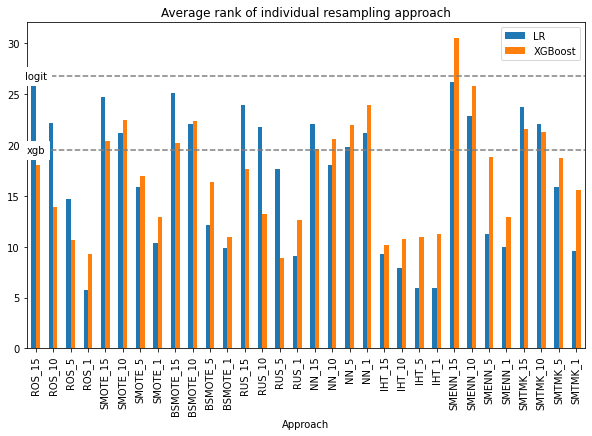

In [102]:
# create data
df = pd.DataFrame([['ROS_15', logit_appir_tr.iloc[1,3], xgb_appir_tr.iloc[1,3]], 
                   ['ROS_10', logit_appir_tr.iloc[2,3], xgb_appir_tr.iloc[2,3]], 
                   ['ROS_5', logit_appir_tr.iloc[3,3], xgb_appir_tr.iloc[3,3]],
                   ['ROS_1', logit_appir_tr.iloc[4,3], xgb_appir_tr.iloc[4,3]],
                   ['SMOTE_15', logit_appir_tr.iloc[5,3], xgb_appir_tr.iloc[5,3]], 
                   ['SMOTE_10', logit_appir_tr.iloc[6,3], xgb_appir_tr.iloc[6,3]], 
                   ['SMOTE_5', logit_appir_tr.iloc[7,3], xgb_appir_tr.iloc[7,3]],
                   ['SMOTE_1', logit_appir_tr.iloc[8,3], xgb_appir_tr.iloc[8,3]],
                   ['BSMOTE_15', logit_appir_tr.iloc[9,3], xgb_appir_tr.iloc[9,3]], 
                   ['BSMOTE_10', logit_appir_tr.iloc[10,3], xgb_appir_tr.iloc[10,3]], 
                   ['BSMOTE_5', logit_appir_tr.iloc[11,3], xgb_appir_tr.iloc[11,3]],
                   ['BSMOTE_1', logit_appir_tr.iloc[12,3], xgb_appir_tr.iloc[12,3]],
                   ['RUS_15', logit_appir_tr.iloc[13,3], xgb_appir_tr.iloc[13,3]], 
                   ['RUS_10', logit_appir_tr.iloc[14,3], xgb_appir_tr.iloc[14,3]], 
                   ['RUS_5', logit_appir_tr.iloc[15,3], xgb_appir_tr.iloc[15,3]],
                   ['RUS_1', logit_appir_tr.iloc[16,3], xgb_appir_tr.iloc[16,3]],
                   ['NN_15', logit_appir_tr.iloc[17,3], xgb_appir_tr.iloc[17,3]], 
                   ['NN_10', logit_appir_tr.iloc[18,3], xgb_appir_tr.iloc[18,3]], 
                   ['NN_5', logit_appir_tr.iloc[19,3], xgb_appir_tr.iloc[19,3]],
                   ['NN_1', logit_appir_tr.iloc[20,3], xgb_appir_tr.iloc[20,3]],
                   ['IHT_15', logit_appir_tr.iloc[21,3], xgb_appir_tr.iloc[21,3]], 
                   ['IHT_10', logit_appir_tr.iloc[22,3], xgb_appir_tr.iloc[22,3]], 
                   ['IHT_5', logit_appir_tr.iloc[23,3], xgb_appir_tr.iloc[23,3]],
                   ['IHT_1', logit_appir_tr.iloc[24,3], xgb_appir_tr.iloc[24,3]],
                   ['SMENN_15', logit_appir_tr.iloc[25,3], xgb_appir_tr.iloc[25,3]], 
                   ['SMENN_10', logit_appir_tr.iloc[26,3], xgb_appir_tr.iloc[26,3]], 
                   ['SMENN_5', logit_appir_tr.iloc[27,3], xgb_appir_tr.iloc[27,3]],
                   ['SMENN_1', logit_appir_tr.iloc[28,3], xgb_appir_tr.iloc[28,3]],
                   ['SMTMK_15', logit_appir_tr.iloc[29,3], xgb_appir_tr.iloc[29,3]], 
                   ['SMTMK_10', logit_appir_tr.iloc[30,3], xgb_appir_tr.iloc[30,3]], 
                   ['SMTMK_5', logit_appir_tr.iloc[31,3], xgb_appir_tr.iloc[31,3]],
                   ['SMTMK_1', logit_appir_tr.iloc[32,3], xgb_appir_tr.iloc[32,3]]              
                  ],
                  columns=['Approach', 'LR','XGBoost'])
# view data
print(df)

# plot grouped bar chart
df.plot(x='Approach',
        kind='bar',
        stacked=False,
        title='Average rank of individual resampling approach')

#add a dash line of avaerage logit fmeasure

plt.axhline(y= logit_appir_tr.iloc[0,3],color='grey', linestyle ='dashed')
plt.text(0, logit_appir_tr.iloc[0,3], 'logit', fontsize=10, va='center', ha='center', backgroundcolor='w')
plt.axhline(y= xgb_appir_tr.iloc[0,3],color='grey', linestyle ='dashed')
plt.text(0, xgb_appir_tr.iloc[0,3], 'xgb', fontsize=10, va='center', ha='center', backgroundcolor='w')

#adjust the size of plot    
plt.rcParams["figure.figsize"] = [20, 15]
plt.savefig('./result/appir.jpg')
plt.show()

# 4. Shap correlation analysis

In [103]:
#read result files
hmeq_shapco = pd.read_csv("../HMEQ/result/rank_shap.csv", sep=",", index_col=0)
ucid_shapco = pd.read_csv("../UCI_D/result/rank_shap.csv", sep=",", index_col=0)
ucig_shapco = pd.read_csv("../UCI_G/result/rank_shap.csv", sep=",", index_col=0)
ucip_shapco = pd.read_csv("../UCI_P/result/rank_shap.csv", sep=",", index_col=0)
kaggle_shapco = pd.read_csv("../GMC/result/rank_shap.csv", sep=",", index_col=0)

In [104]:
#construct dataframe: 
#the correlation between resampling methods with original xgboost for fie data sets
shap_rankco = {
    'hmeq' : hmeq_shapco.iloc[0,:],
    'ucid' : ucid_shapco.iloc[0,:],
    'ucig': ucig_shapco.iloc[0,:],
    'ucip': ucip_shapco.iloc[0,:],
    'kaggle': kaggle_shapco.iloc[0,:],
}
shap_rankco_df = pd.DataFrame(shap_rankco)
shap_rankco_dftr =shap_rankco_df.transpose()
shap_rankco_dftr = shap_rankco_dftr.drop(['xgb'], axis=1)
#add average row
shap_rankco_dftr.loc[len(shap_rankco_dftr)] =shap_rankco_dftr.mean()
shap_rankco_dftr.rename(index ={5: 'average'},inplace=True)
#sort by average
shap_rankco_dftr = shap_rankco_dftr.sort_values(by = 'average', axis = 1)
shap_rankco_dftr =shap_rankco_dftr.round(3)
shap_rankco_dftr

,iht1,iht5,iht10,rus1,iht15,rus5,rus15,rus10
hmeq,0.788,0.848,0.931,0.940,0.845,0.931,0.868,0.984
ucid,-0.063,0.686,0.731,0.844,0.880,0.832,0.806,0.835
ucig,0.612,0.721,0.444,0.101,0.780,0.721,0.900,0.810
ucip,0.568,0.751,0.725,0.747,0.774,0.837,0.859,0.801
kaggle,-0.043,0.535,0.740,0.988,0.688,0.985,0.954,0.997
average,0.372,0.708,0.714,0.724,0.793,0.861,0.877,0.885


  approach   HMEQ   UCID   UCIG   UCIP    GMC   mean
0     iht1  0.788 -0.063  0.612  0.568 -0.043  0.372
1     iht5  0.848  0.686  0.721  0.751  0.535  0.708
2    iht10  0.931  0.731  0.444  0.725  0.740  0.714
3     rus1  0.940  0.844  0.101  0.747  0.988  0.724
4    iht15  0.845  0.880  0.780  0.774  0.688  0.793
5     rus5  0.931  0.832  0.721  0.837  0.985  0.861
6    rus10  0.868  0.806  0.900  0.859  0.954  0.877
7    rus15  0.984  0.835  0.810  0.801  0.997  0.885


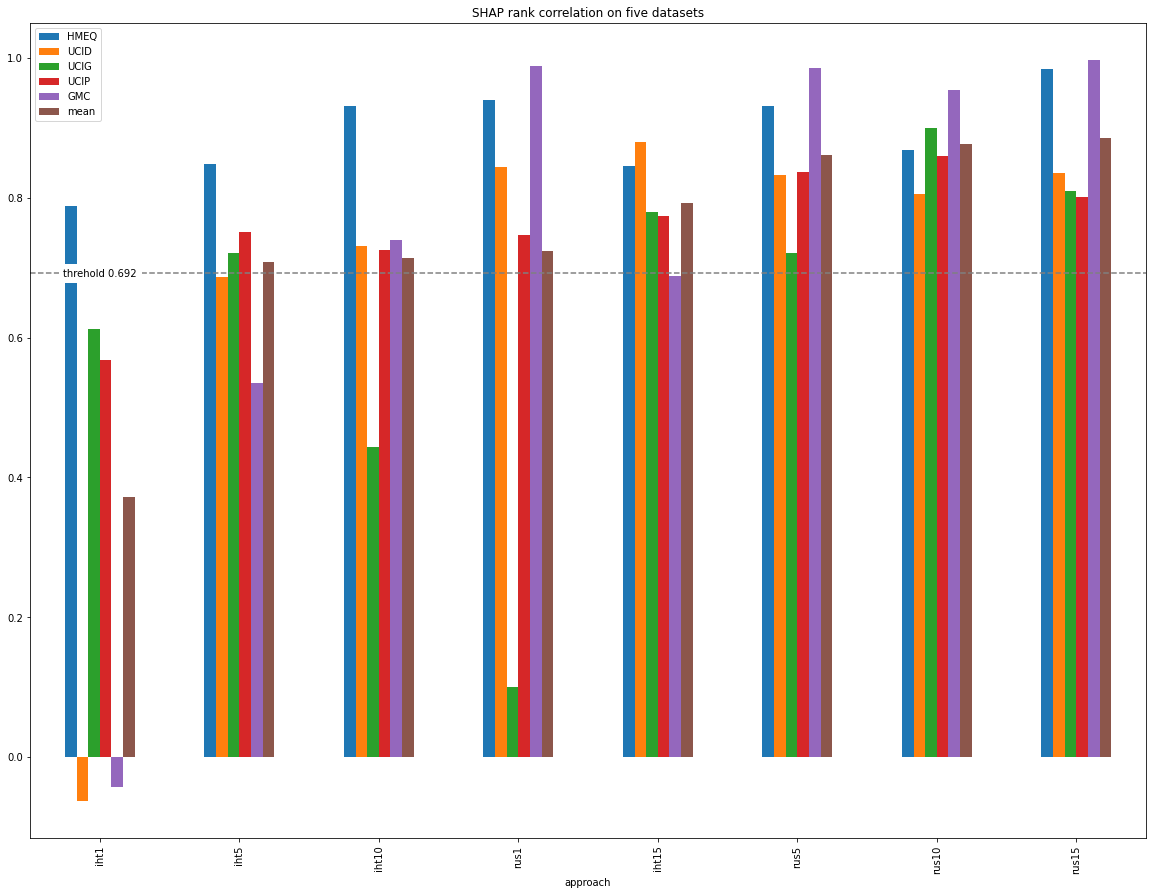

In [105]:
df = pd.DataFrame([['iht1', shap_rankco_dftr.iloc[0,0], shap_rankco_dftr.iloc[1,0], shap_rankco_dftr.iloc[2,0], shap_rankco_dftr.iloc[3,0], shap_rankco_dftr.iloc[4,0],shap_rankco_dftr.iloc[5,0]],
                   ['iht5', shap_rankco_dftr.iloc[0,1], shap_rankco_dftr.iloc[1,1], shap_rankco_dftr.iloc[2,1], shap_rankco_dftr.iloc[3,1], shap_rankco_dftr.iloc[4,1],shap_rankco_dftr.iloc[5,1]],
                   ['iht10', shap_rankco_dftr.iloc[0,2], shap_rankco_dftr.iloc[1,2], shap_rankco_dftr.iloc[2,2], shap_rankco_dftr.iloc[3,2], shap_rankco_dftr.iloc[4,2],shap_rankco_dftr.iloc[5,2]],
                   ['rus1', shap_rankco_dftr.iloc[0,3], shap_rankco_dftr.iloc[1,3], shap_rankco_dftr.iloc[2,3], shap_rankco_dftr.iloc[3,3], shap_rankco_dftr.iloc[4,3],shap_rankco_dftr.iloc[5,3]],
                   ['iht15', shap_rankco_dftr.iloc[0,4], shap_rankco_dftr.iloc[1,4], shap_rankco_dftr.iloc[2,4], shap_rankco_dftr.iloc[3,4], shap_rankco_dftr.iloc[4,4],shap_rankco_dftr.iloc[5,4]],
                   ['rus5', shap_rankco_dftr.iloc[0,5], shap_rankco_dftr.iloc[1,5], shap_rankco_dftr.iloc[2,5], shap_rankco_dftr.iloc[3,5], shap_rankco_dftr.iloc[4,5],shap_rankco_dftr.iloc[5,5]],
                   ['rus10', shap_rankco_dftr.iloc[0,6], shap_rankco_dftr.iloc[1,6], shap_rankco_dftr.iloc[2,6], shap_rankco_dftr.iloc[3,6], shap_rankco_dftr.iloc[4,6],shap_rankco_dftr.iloc[5,6]],                
                   ['rus15', shap_rankco_dftr.iloc[0,7], shap_rankco_dftr.iloc[1,7], shap_rankco_dftr.iloc[2,7], shap_rankco_dftr.iloc[3,7], shap_rankco_dftr.iloc[4,7],shap_rankco_dftr.iloc[5,7]]],
                  columns=['approach', 'HMEQ','UCID', 'UCIG', 'UCIP','GMC', 'mean'])
print(df)
  
# plot grouped bar chart
df.plot(x='approach',
        kind='bar',
        stacked=False,
        title='SHAP rank correlation on five datasets')
plt.axhline(y= 0.692,color='grey', linestyle ='dashed')
plt.text(0, 0.692, 'threhold 0.692', fontsize=10, va='center', ha='center', backgroundcolor='w')    
plt.rcParams["figure.figsize"] = [10, 6]
plt.savefig('./result/shap_cor.jpg')
plt.show()

# 5. PFI correlation analysis

In [106]:
#read result files
hmeq_pfico = pd.read_csv("../HMEQ/result/rank_pfi.csv", sep=",", index_col=0)
ucid_pfico = pd.read_csv("../UCI_D/result/rank_pfi.csv", sep=",", index_col=0)
ucig_pfico = pd.read_csv("../UCI_G/result/rank_pfi.csv", sep=",", index_col=0)
ucip_pfico = pd.read_csv("../UCI_P/result/rank_pfi.csv", sep=",", index_col=0)
kaggle_pfico = pd.read_csv("../GMC/result/rank_pfi.csv", sep=",", index_col=0)

In [107]:
#construct dataframe: 
#the correlation between resampling methods with original xgboost for fie data sets
pfi_rankco = {
    'hmeq' : hmeq_pfico.iloc[0,:],
    'ucid' : ucid_pfico.iloc[0,:],
    'ucig': ucig_pfico.iloc[0,:],
    'ucip': ucip_pfico.iloc[0,:],
    'kaggle': kaggle_pfico.iloc[0,:],
}
pfi_rankco_df = pd.DataFrame(pfi_rankco)
pfi_rankco_dftr =pfi_rankco_df.transpose()
pfi_rankco_dftr = pfi_rankco_dftr.drop(['xgb'], axis=1)
#add average row
pfi_rankco_dftr.loc[len(pfi_rankco_dftr)] =pfi_rankco_dftr.mean()
pfi_rankco_dftr.rename(index ={5: 'average'},inplace=True)
#sort by average
pfi_rankco_dftr = pfi_rankco_dftr.sort_values(by = 'average', axis = 1)
pfi_rankco_dftr =pfi_rankco_dftr.round(3)
pfi_rankco_dftr

,iht1,iht5,iht10,rus1,iht15,rus10,rus5,rus15
hmeq,0.759,0.674,0.940,0.929,0.938,0.943,0.926,0.982
ucid,0.251,0.710,0.321,0.793,0.704,0.511,0.895,0.841
ucig,0.573,0.698,0.483,0.144,0.683,0.852,0.719,0.931
ucip,0.574,0.437,0.684,0.743,0.787,0.780,0.787,0.958
kaggle,0.074,0.631,0.765,0.997,0.682,1.000,0.988,0.997
average,0.446,0.630,0.639,0.721,0.759,0.817,0.863,0.942


  approach   HMEQ   UCID   UCIG   UCIP    GMC   mean
0     iht1  0.759  0.251  0.573  0.574  0.074  0.446
1     iht5  0.674  0.710  0.698  0.437  0.631  0.630
2    iht10  0.940  0.321  0.483  0.684  0.765  0.639
3     rus1  0.929  0.793  0.144  0.743  0.997  0.721
4    iht15  0.938  0.704  0.683  0.787  0.682  0.759
5     rus5  0.943  0.511  0.852  0.780  1.000  0.817
6    rus10  0.926  0.895  0.719  0.787  0.988  0.863
7    rus15  0.982  0.841  0.931  0.958  0.997  0.942


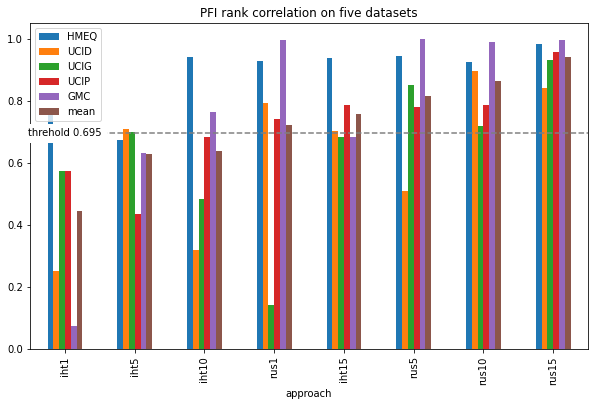

In [108]:
df = pd.DataFrame([['iht1', pfi_rankco_dftr.iloc[0,0], pfi_rankco_dftr.iloc[1,0], pfi_rankco_dftr.iloc[2,0], pfi_rankco_dftr.iloc[3,0], pfi_rankco_dftr.iloc[4,0],pfi_rankco_dftr.iloc[5,0]],
                   ['iht5', pfi_rankco_dftr.iloc[0,1], pfi_rankco_dftr.iloc[1,1], pfi_rankco_dftr.iloc[2,1], pfi_rankco_dftr.iloc[3,1], pfi_rankco_dftr.iloc[4,1],pfi_rankco_dftr.iloc[5,1]],
                   ['iht10', pfi_rankco_dftr.iloc[0,2], pfi_rankco_dftr.iloc[1,2], pfi_rankco_dftr.iloc[2,2], pfi_rankco_dftr.iloc[3,2], pfi_rankco_dftr.iloc[4,2],pfi_rankco_dftr.iloc[5,2]],
                   ['rus1', pfi_rankco_dftr.iloc[0,3], pfi_rankco_dftr.iloc[1,3], pfi_rankco_dftr.iloc[2,3], pfi_rankco_dftr.iloc[3,3], pfi_rankco_dftr.iloc[4,3],pfi_rankco_dftr.iloc[5,3]],
                   ['iht15', pfi_rankco_dftr.iloc[0,4], pfi_rankco_dftr.iloc[1,4], pfi_rankco_dftr.iloc[2,4], pfi_rankco_dftr.iloc[3,4], pfi_rankco_dftr.iloc[4,4],pfi_rankco_dftr.iloc[5,4]],
                   ['rus5', pfi_rankco_dftr.iloc[0,5], pfi_rankco_dftr.iloc[1,5], pfi_rankco_dftr.iloc[2,5], pfi_rankco_dftr.iloc[3,5], pfi_rankco_dftr.iloc[4,5],pfi_rankco_dftr.iloc[5,5]],
                   ['rus10', pfi_rankco_dftr.iloc[0,6], pfi_rankco_dftr.iloc[1,6], pfi_rankco_dftr.iloc[2,6], pfi_rankco_dftr.iloc[3,6], pfi_rankco_dftr.iloc[4,6],pfi_rankco_dftr.iloc[5,6]],                
                   ['rus15', pfi_rankco_dftr.iloc[0,7], pfi_rankco_dftr.iloc[1,7], pfi_rankco_dftr.iloc[2,7], pfi_rankco_dftr.iloc[3,7], pfi_rankco_dftr.iloc[4,7],pfi_rankco_dftr.iloc[5,7]]],
                  columns=['approach', 'HMEQ','UCID', 'UCIG', 'UCIP','GMC', 'mean'])
print(df)
  
# plot grouped bar chart
df.plot(x='approach',
        kind='bar',
        stacked=False,
        title='PFI rank correlation on five datasets')
plt.axhline(y= 0.695,color='grey', linestyle ='dashed')
plt.text(0, 0.695, 'threhold 0.695', fontsize=10, va='center', ha='center', backgroundcolor='w')
    
plt.rcParams["figure.figsize"] = [10, 6]
plt.savefig('./result/pfi_cor.jpg')
plt.show()